This notebook demonstrates performance of tSSA model. It also saves/loads some data and figures. Model's parameters can be changed in the corresponding sections here.

In [1]:
# add path to ssa package
import sys
sys.path.append('../../..')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pathlib

import pickle

%matplotlib inline 

In [3]:
# tssa model
from src.ssa_methods.t_ssa import t_SSA

# plot with large fonts and other stuff
from src.plot.journal_style import EnableJournalStylePlotting

# data extraction methods
import src.data.weather as weather_data

# partition finding algorithms
from src.ssa_methods.ssa_complementary.ssa_multidim_partition import NextDichotomyPartition

## Data preprocessing

In [4]:
# names of observed signals
sig_names = ['Average Temperature', 'Precipitation', 'Average Pressure']
# measure units
sig_units = ['$^\circ C$', 'Mm', 'HPa']

num_signals = 3

In [5]:
# retrive signals and corresponding time grids
# they are already preproccessed
(train_data, time_grid_train), (test_data, time_grid_test) = weather_data.GetBerlinData(
    test_ratio=0.2
)

In [6]:
print(f'Train length = {train_data.shape[0]}')
print(f'Test length = {test_data.shape[0]}')

Train length = 2921
Test length = 731


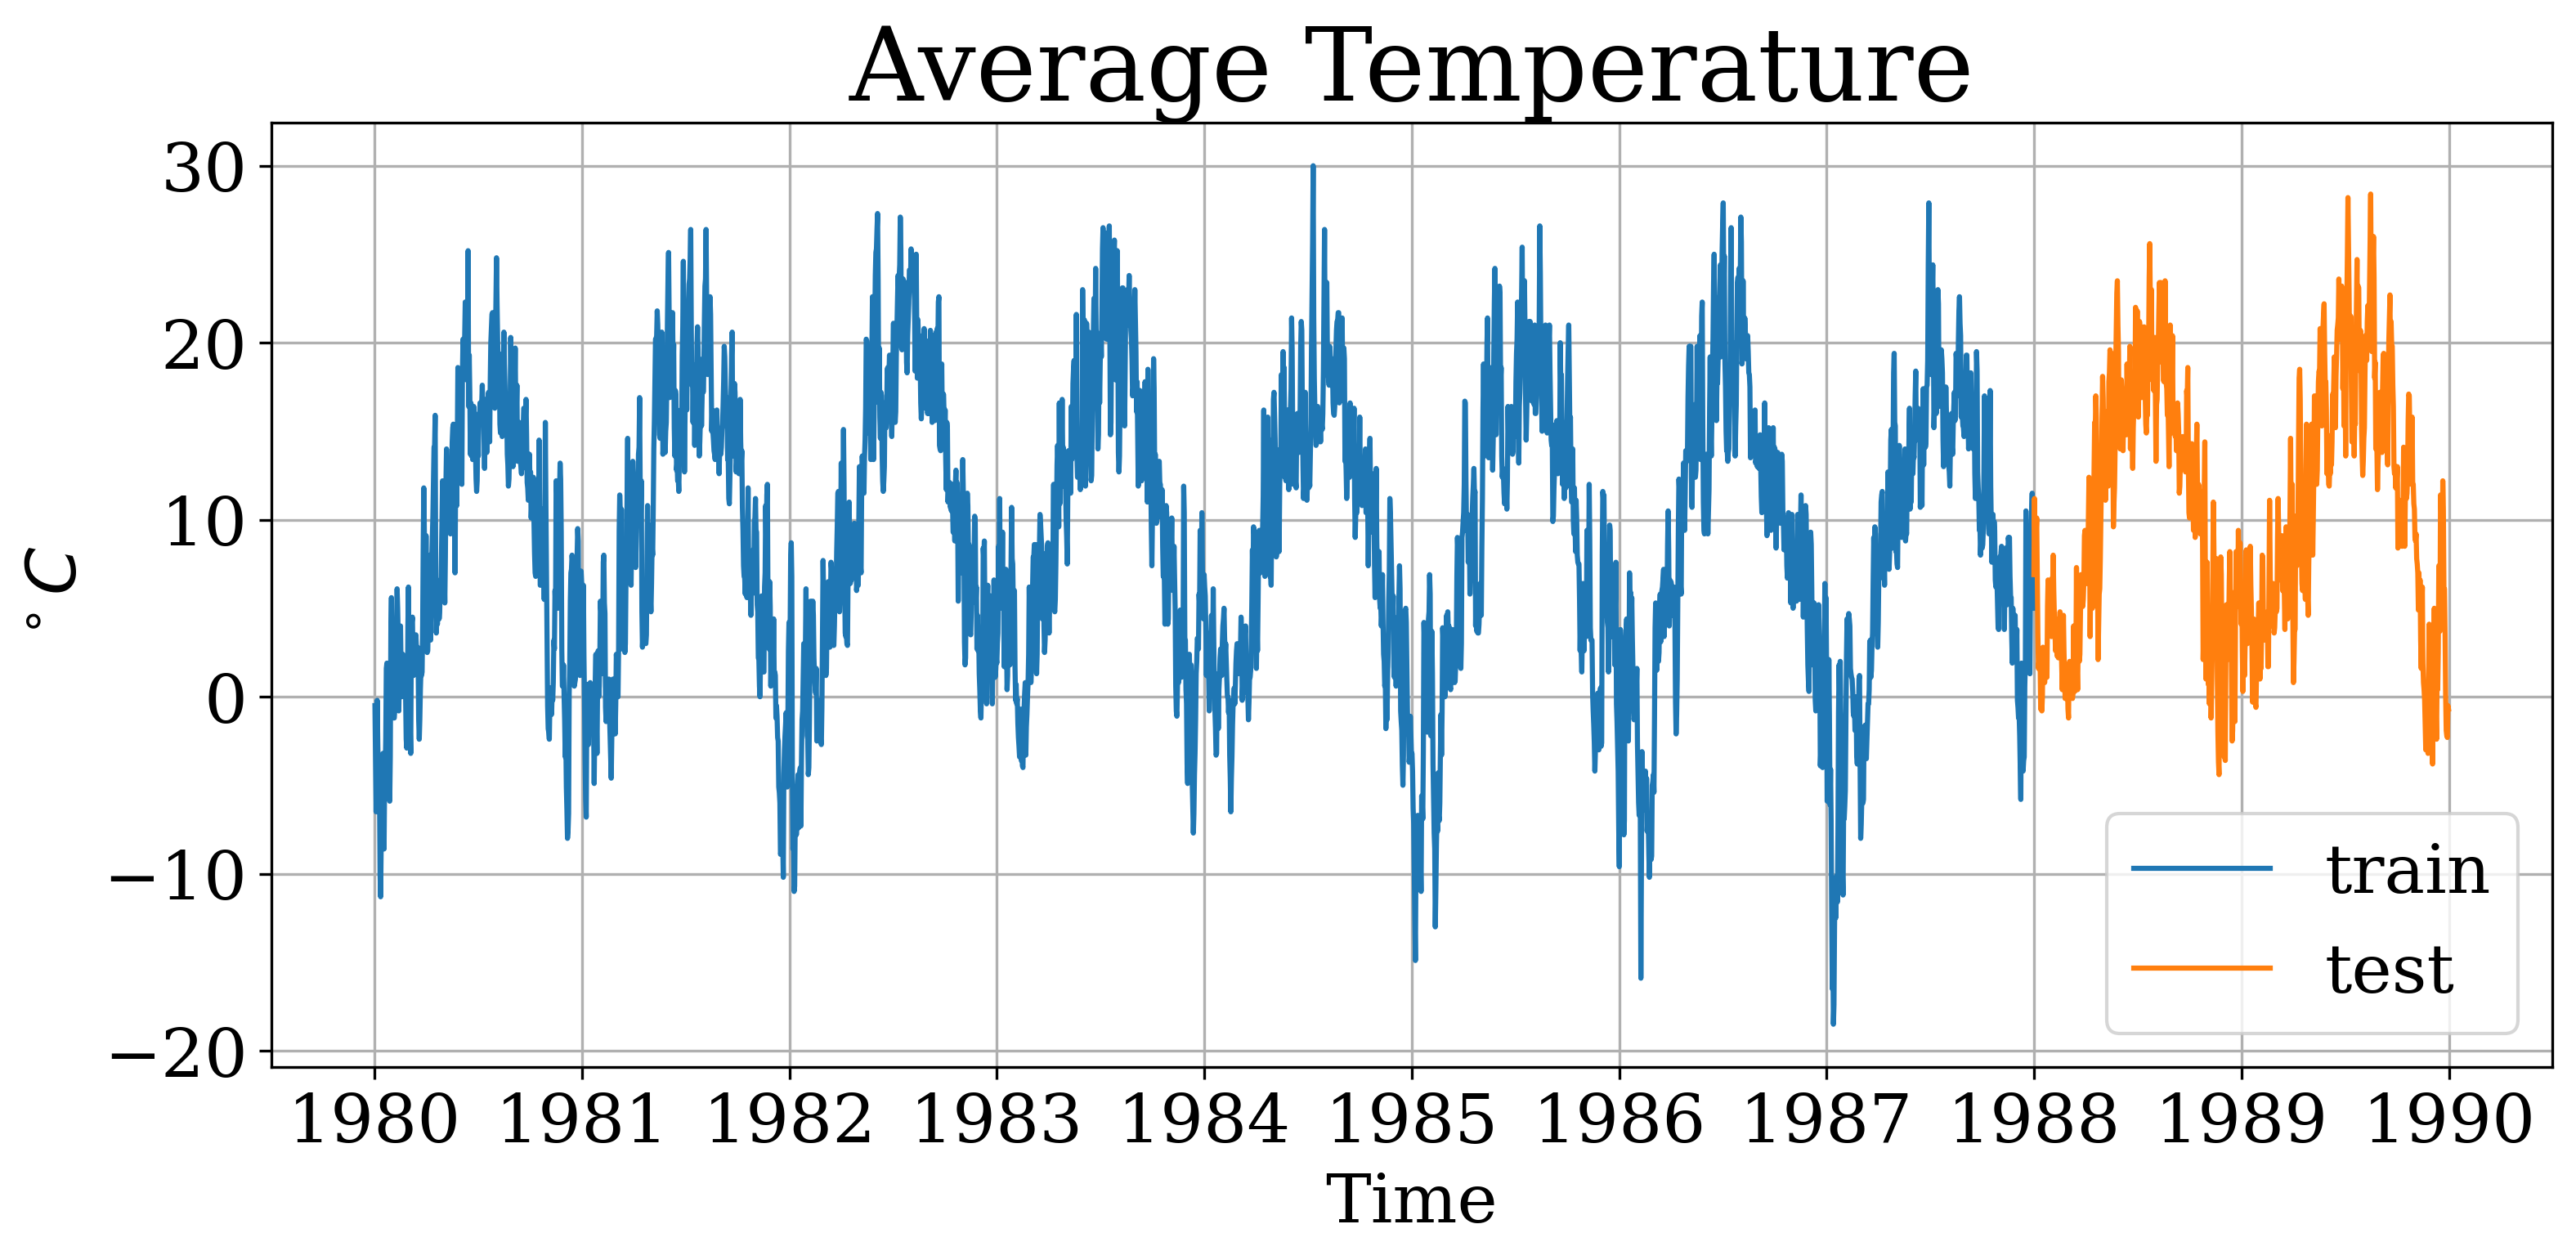

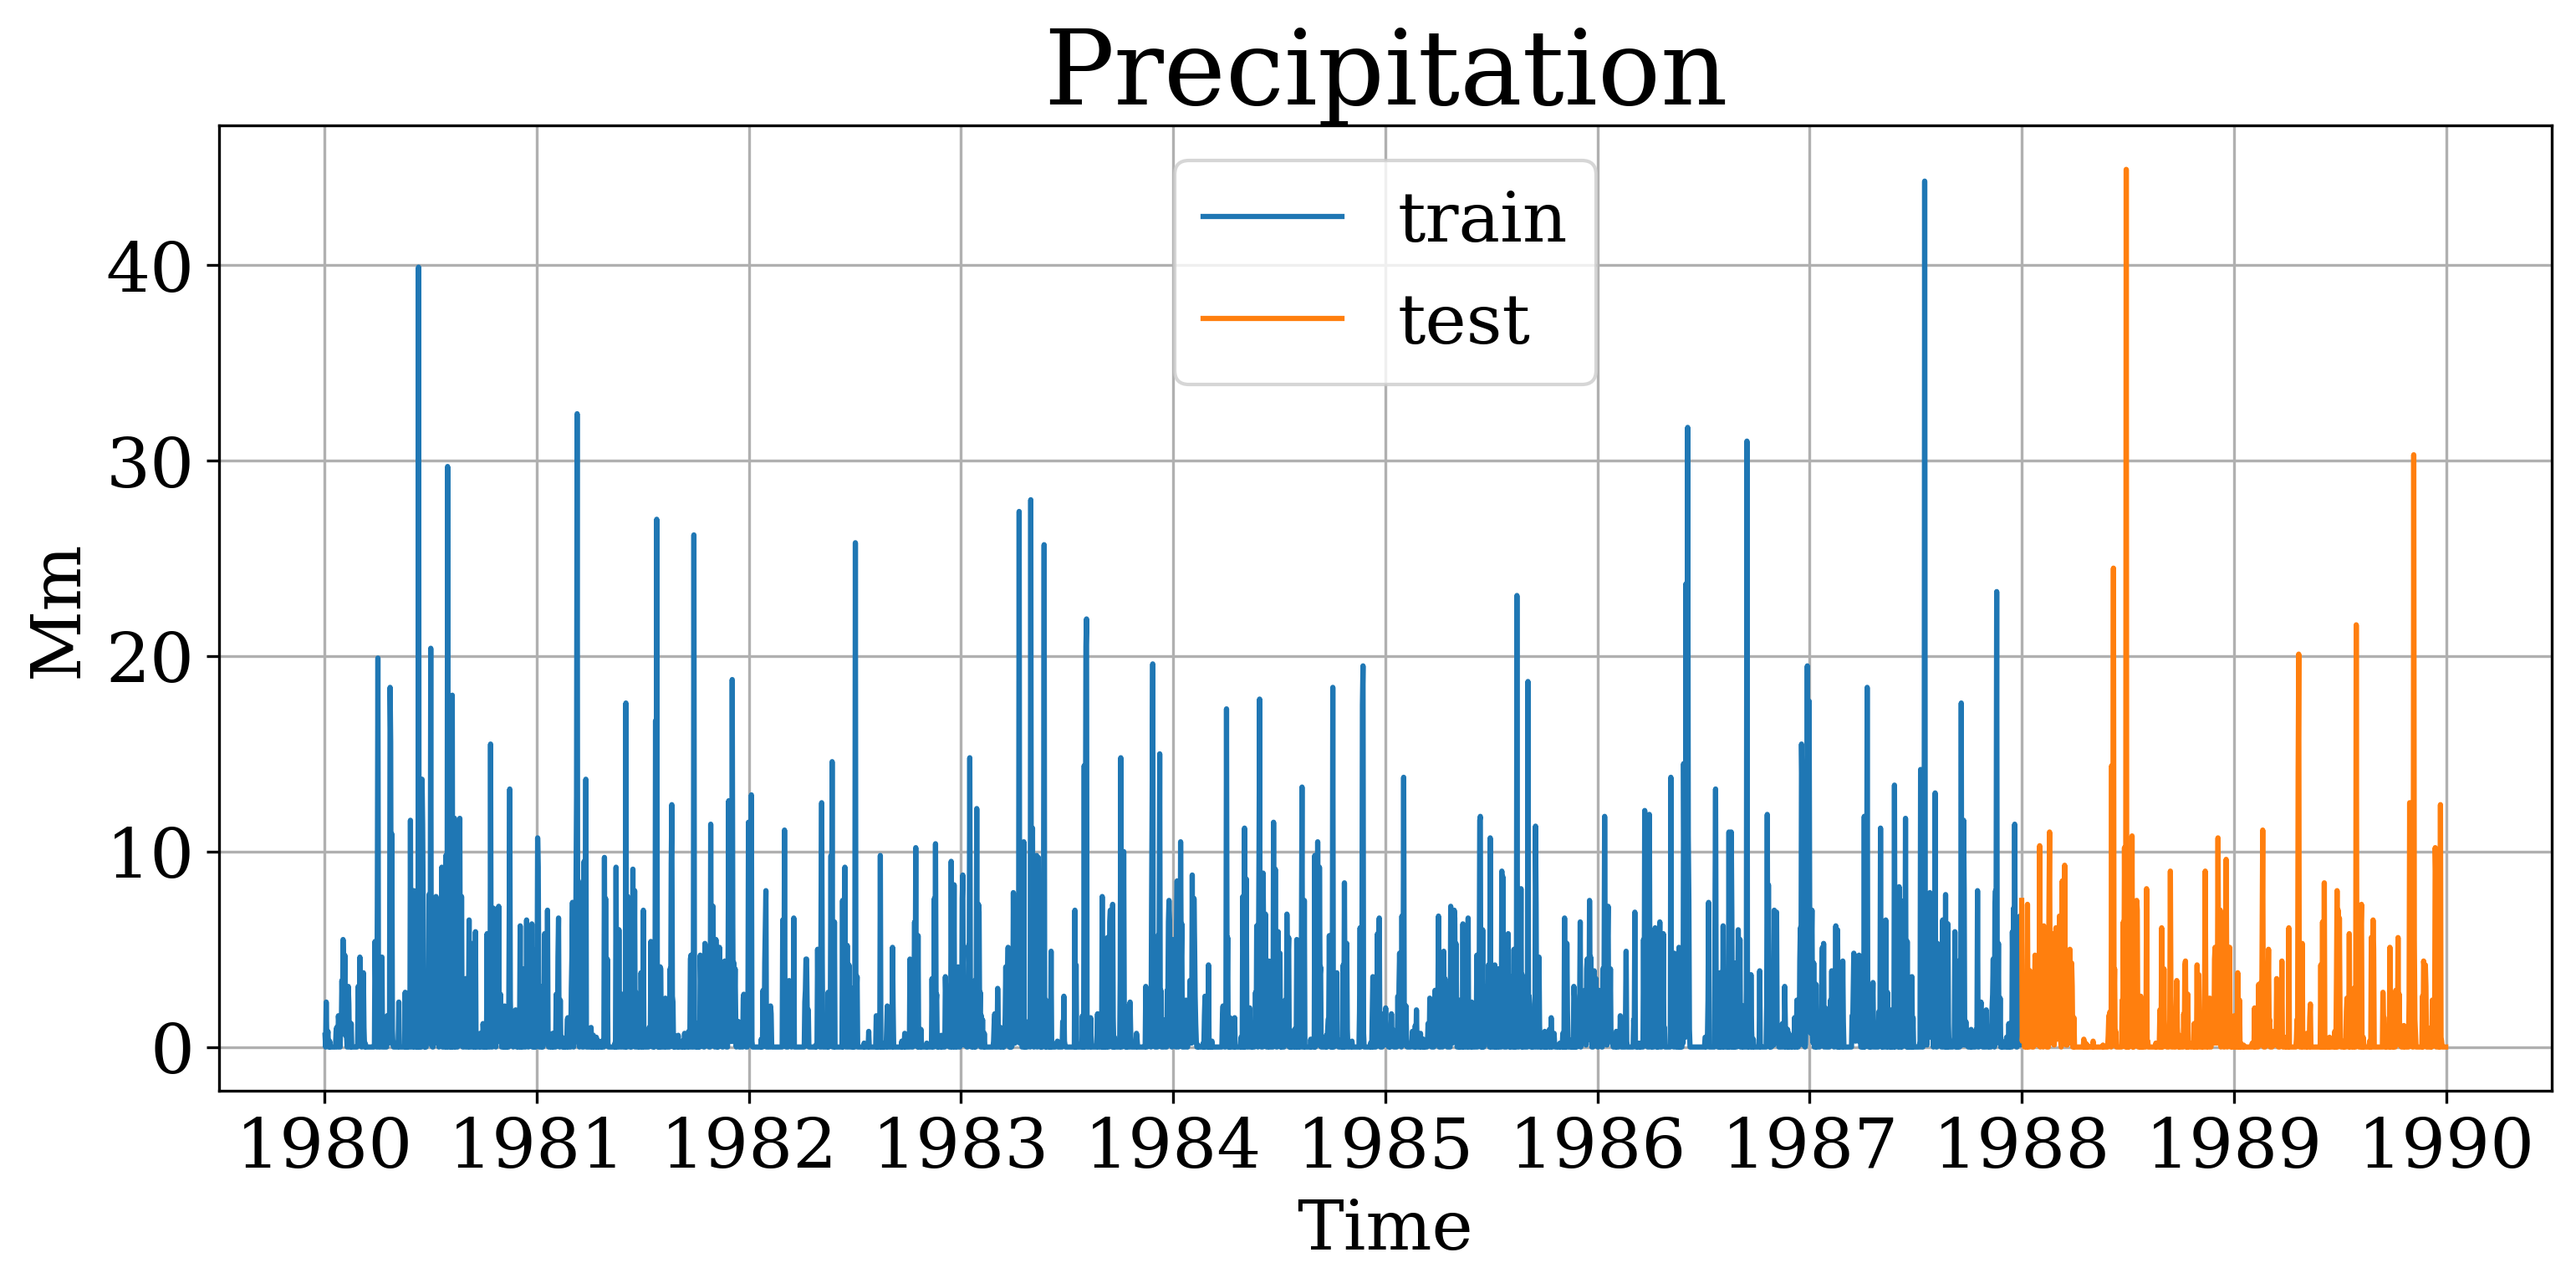

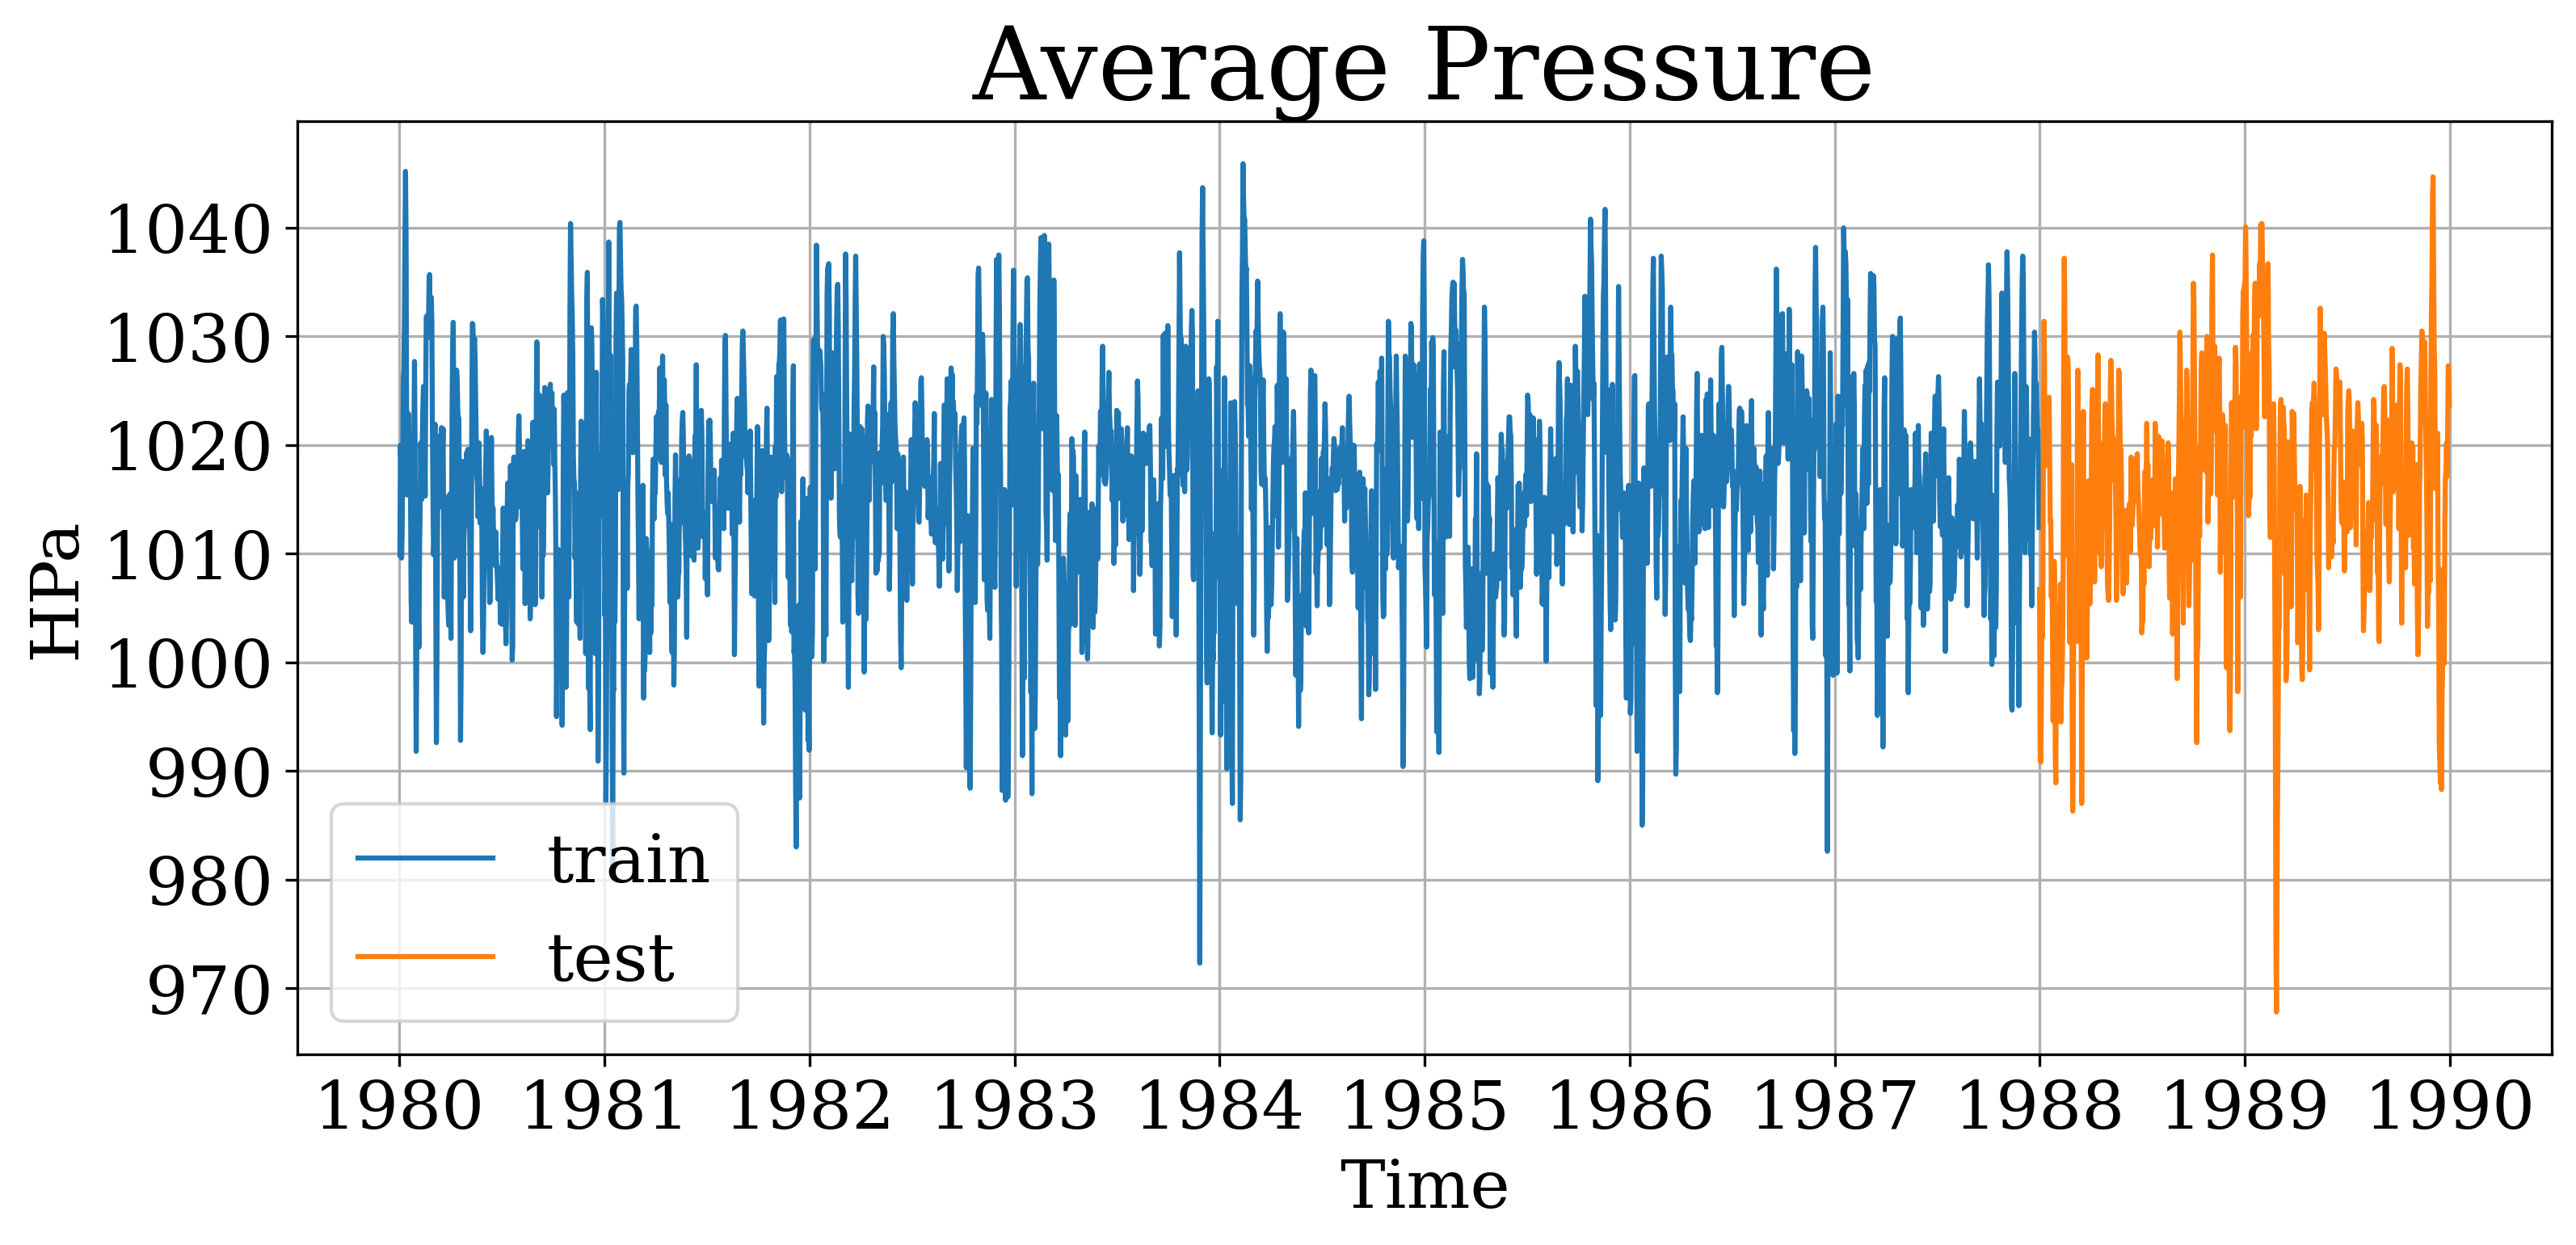

In [7]:
# draw signals
for i in range(num_signals):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(12, 5))

        ax.plot(time_grid_train, train_data.T[i], label='train')
        ax.plot(time_grid_test, test_data.T[i], label='test')

        ax.grid(True)
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel(sig_units[i])
        ax.set_title(sig_names[i])

## Global method parameters

In [8]:
# aka L parameter
ssa_window_size = 500

# parameter for detereministic behaviour of tSSA
random_state = 42

## tSSA fitting

In [9]:
# make directory for models
pathlib.Path(f'./saved_model').mkdir(parents=True, exist_ok=True)

---

In [10]:
# take this rank
cp_rank = 25

In [11]:
# load model if it already exists
if pathlib.Path(f'./saved_model/cpd_rank_{cp_rank}.pkl').exists():
    with open(f'./saved_model/cpd_rank_{cp_rank}.pkl', 'rb') as f:
        t_ssa_obj = pickle.load(f)
else:
    t_ssa_obj = t_SSA(ssa_window_size, train_data.T, cp_rank)

    t_ssa_obj.decompose_tt(random_state=random_state)

    # save model
    with open(f'./saved_model/cpd_rank_{cp_rank}.pkl', 'wb') as f:
        pickle.dump(t_ssa_obj, f)

Relative residual norm = 0.009275018918663462
Absolute residual norm = 10368.280100041191


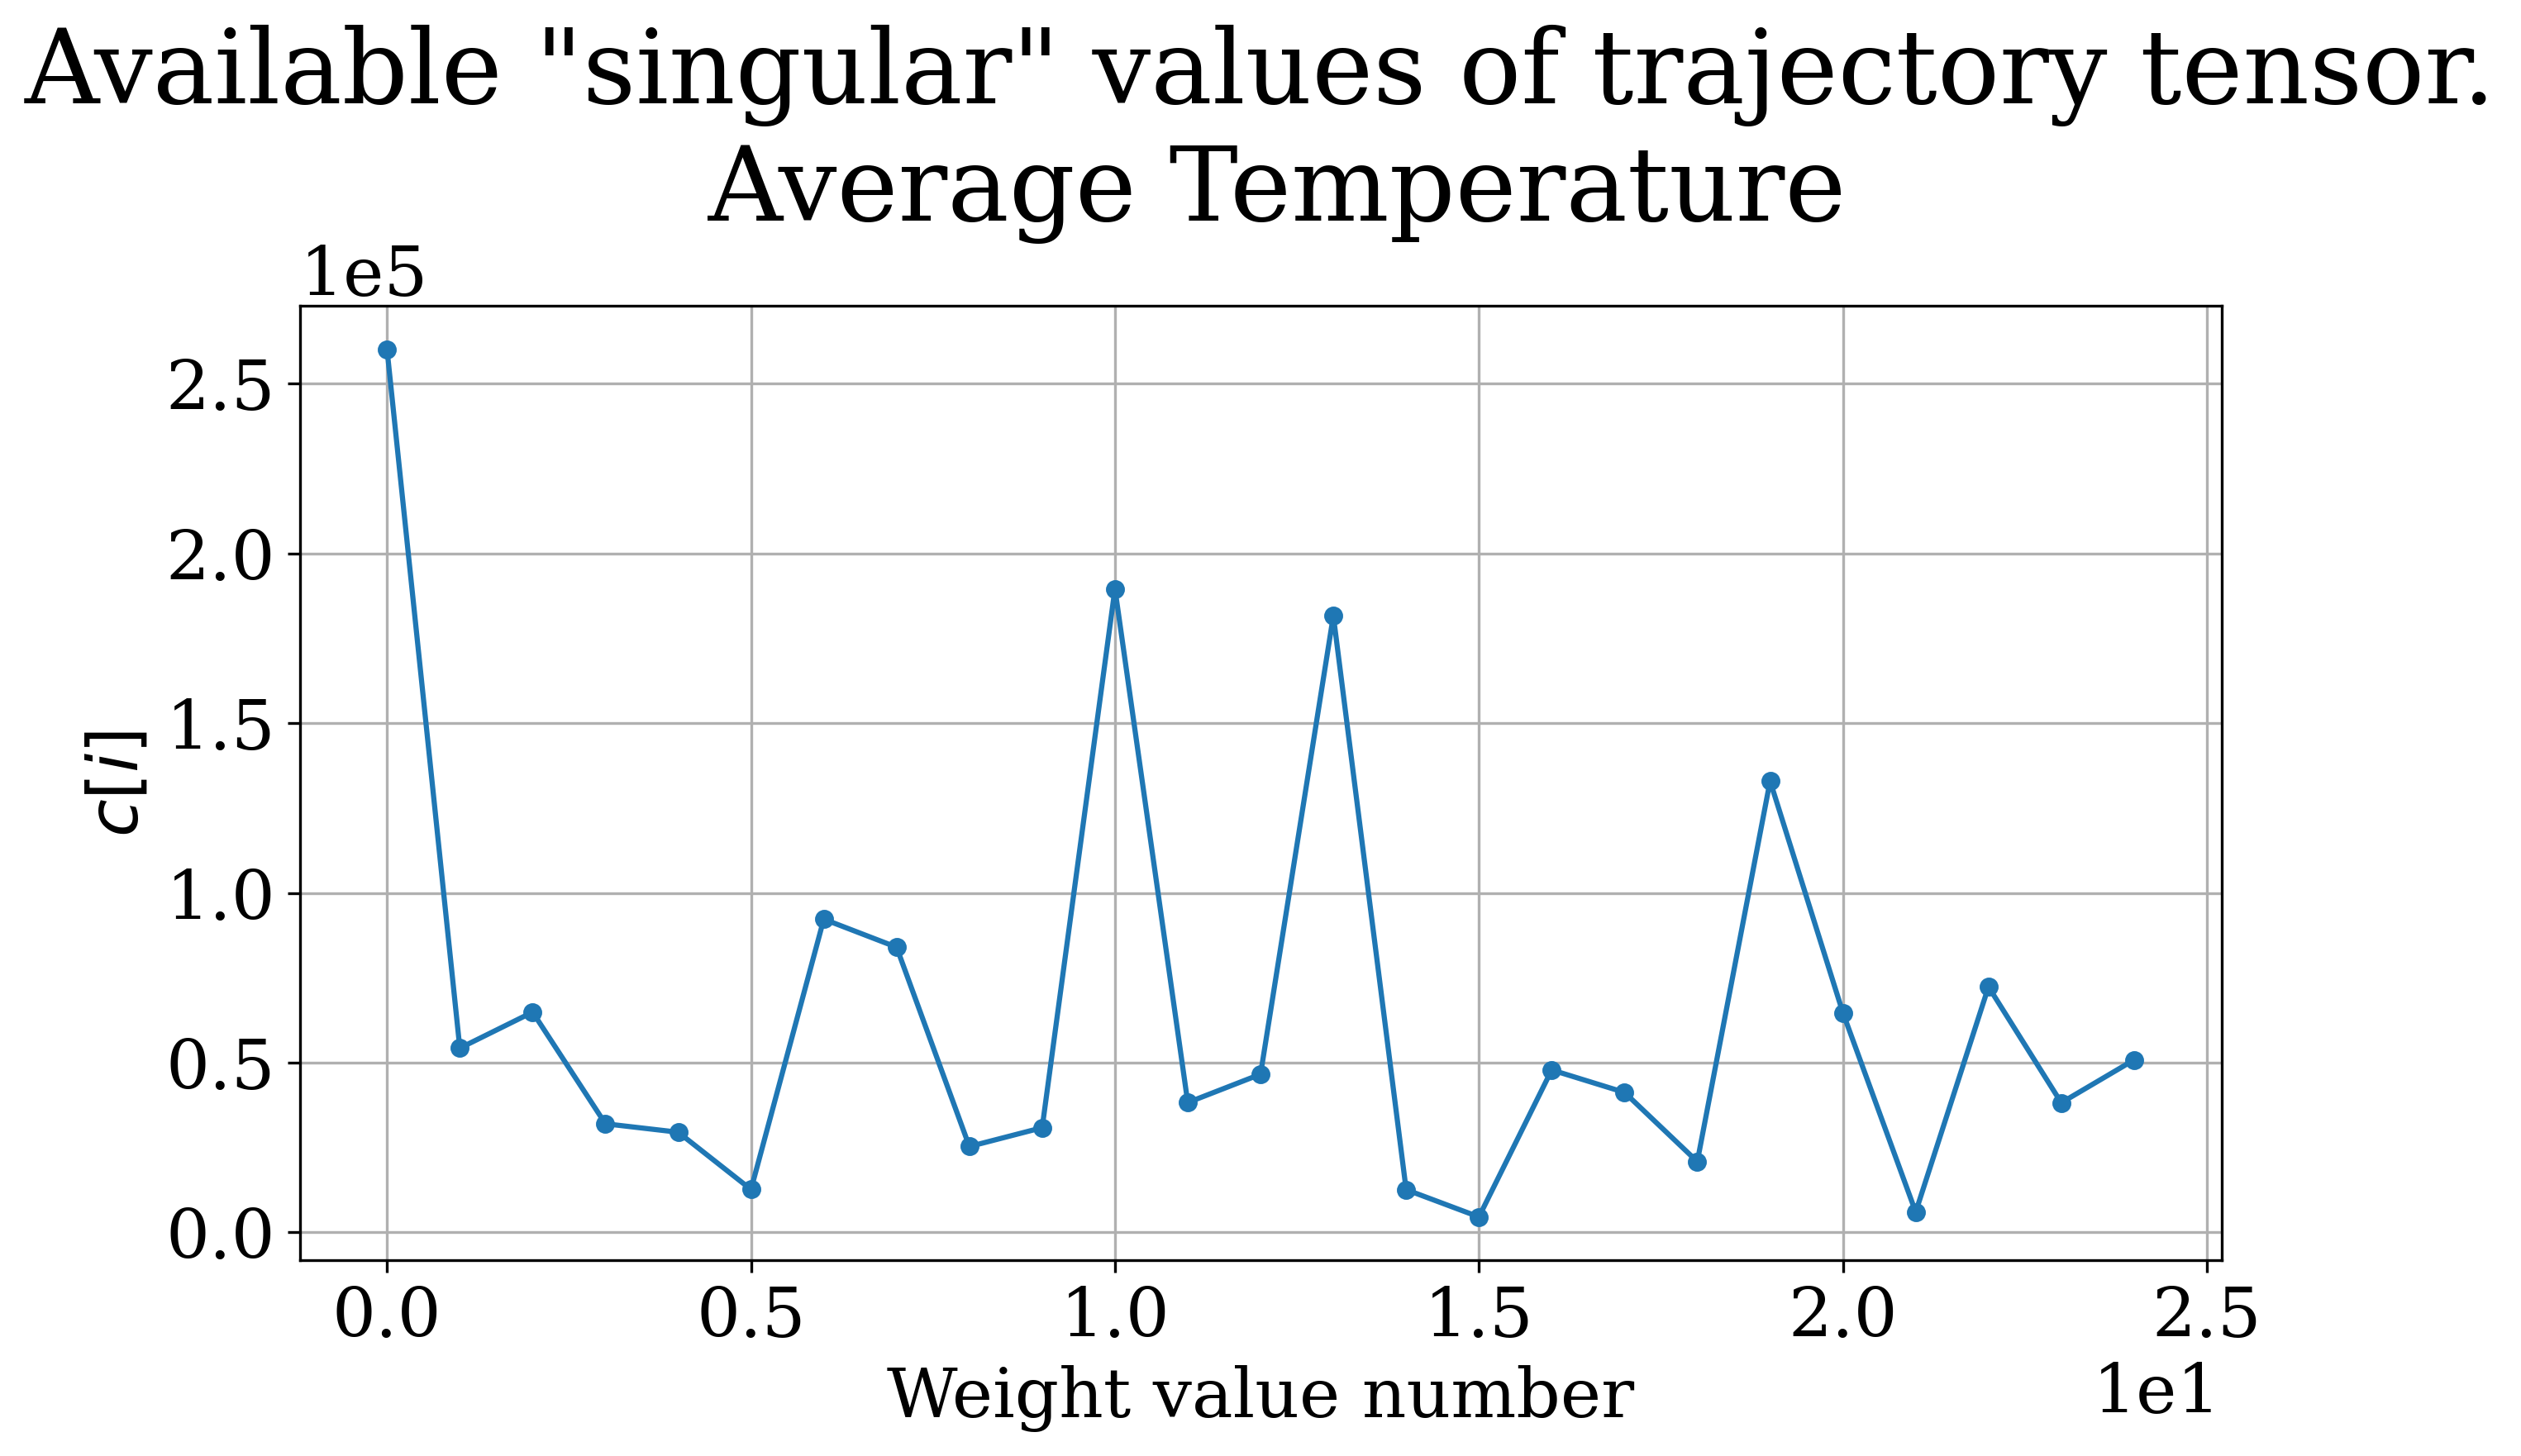

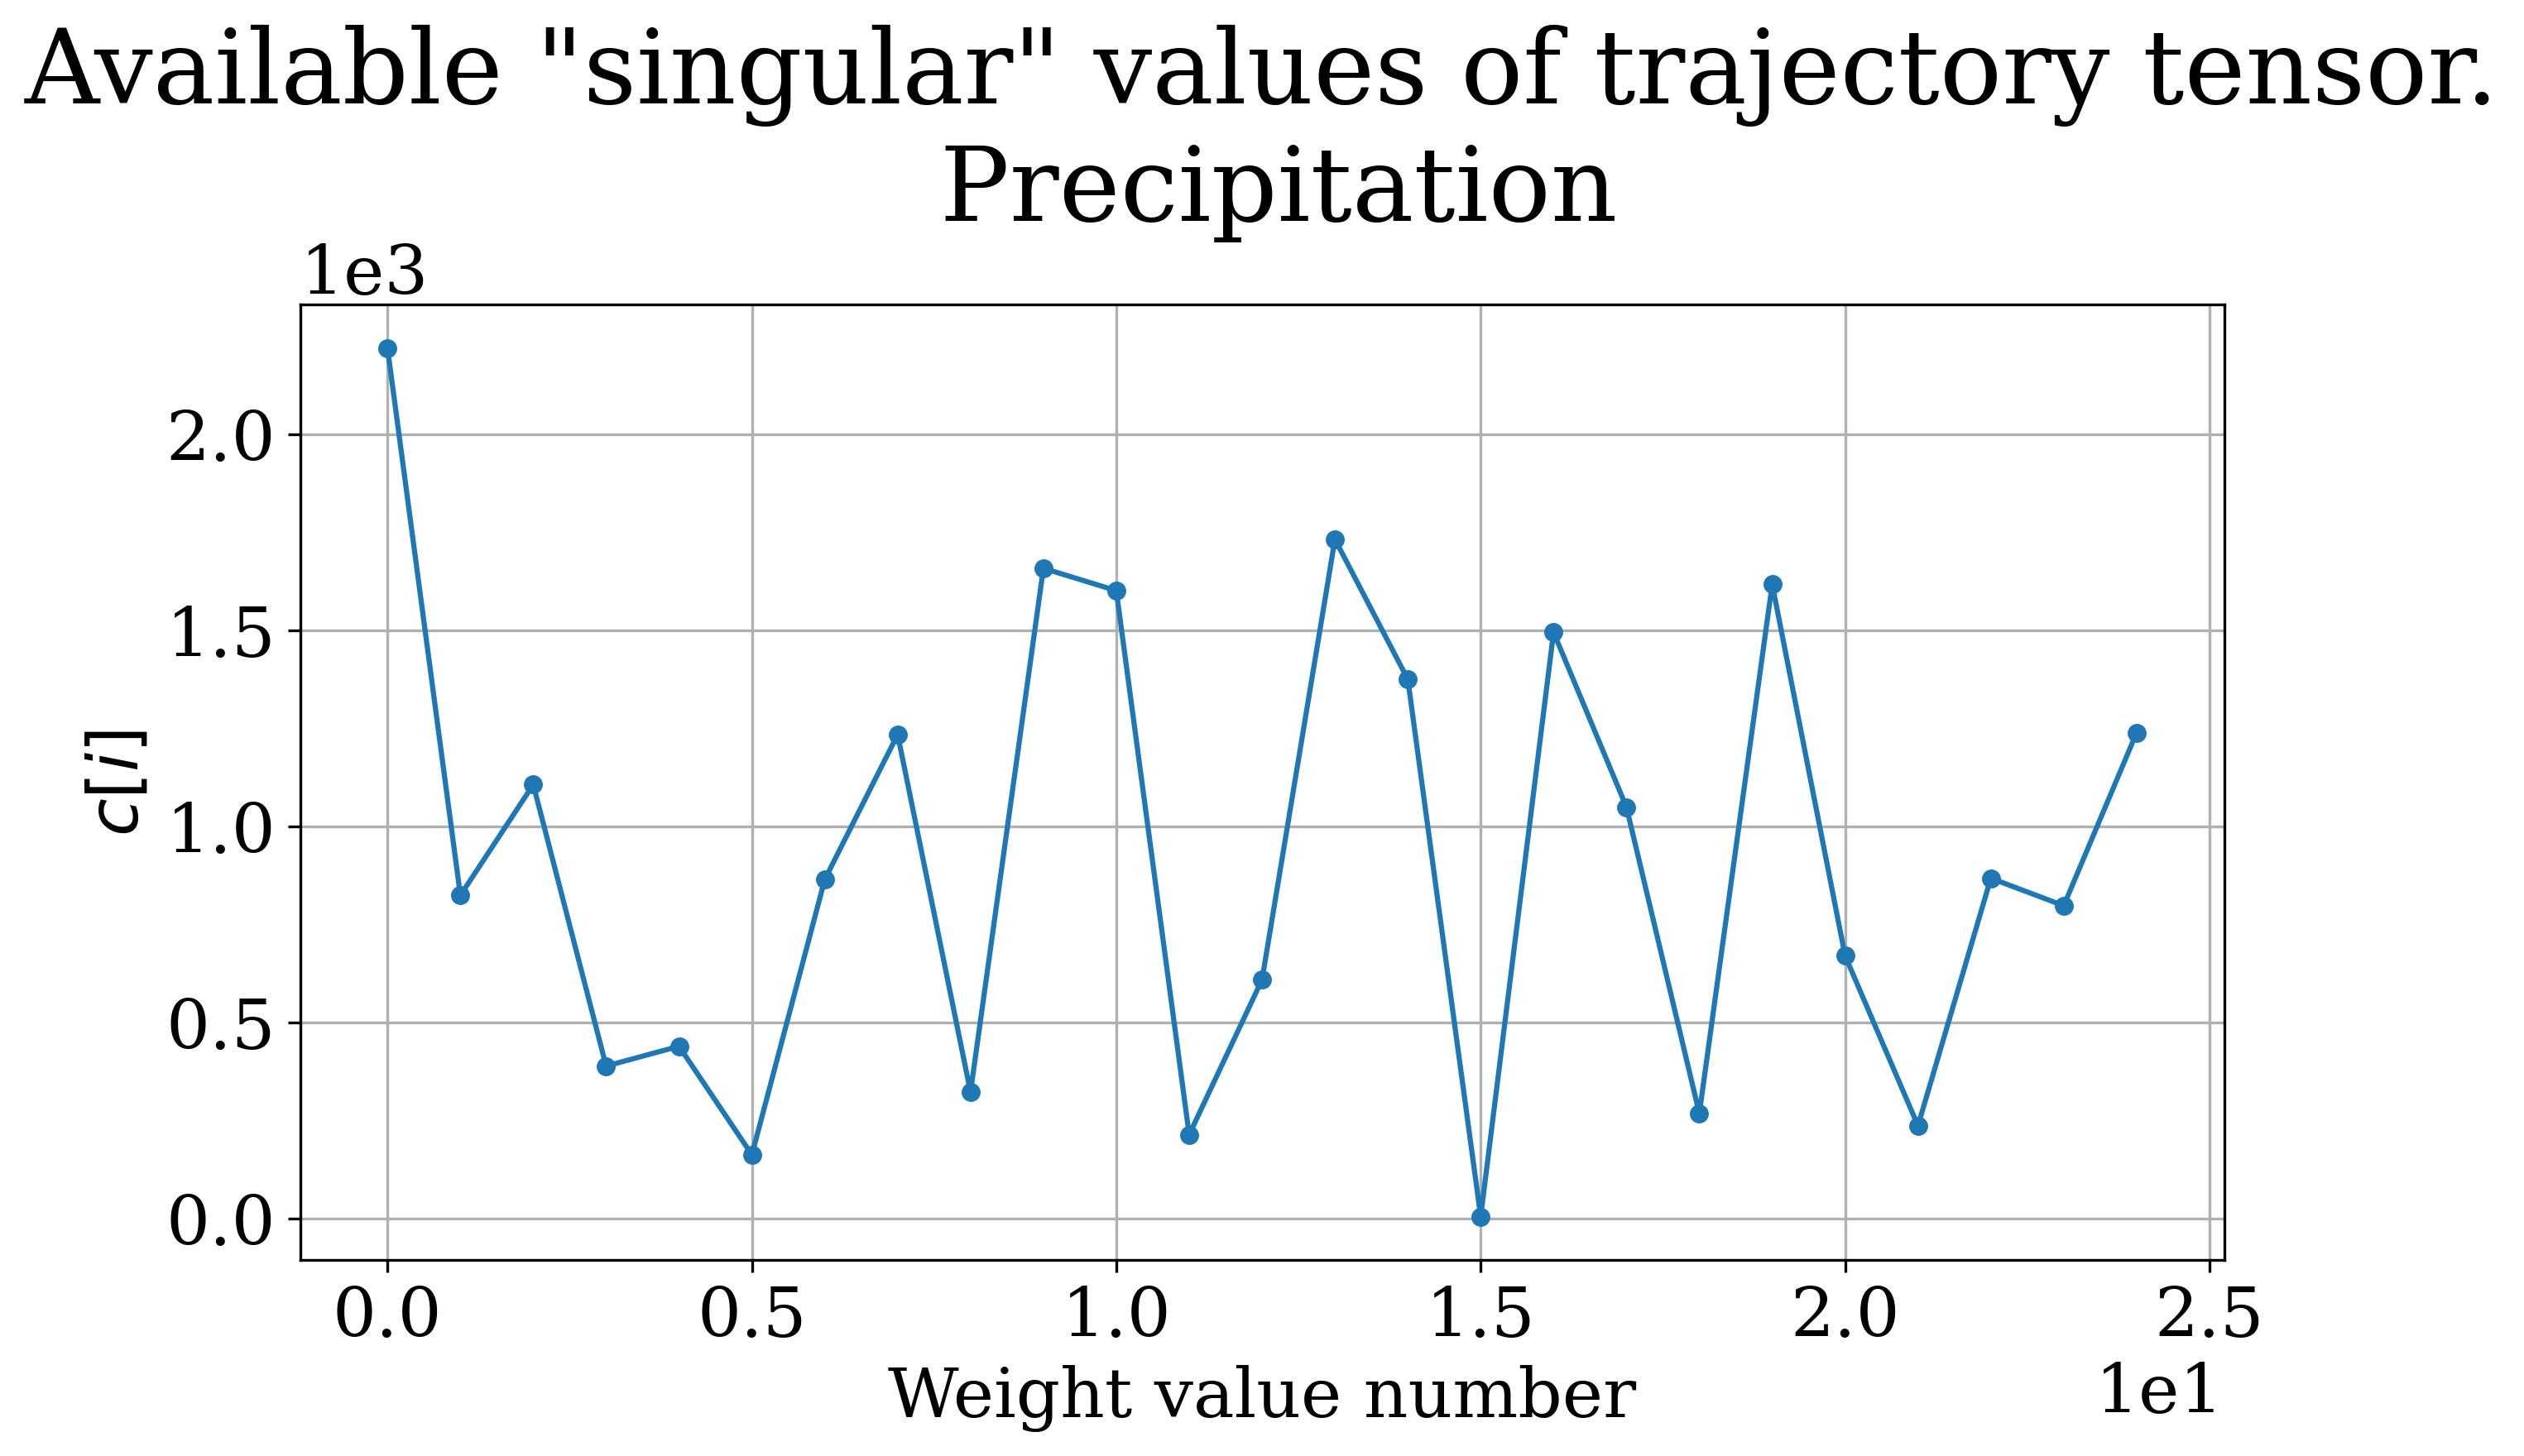

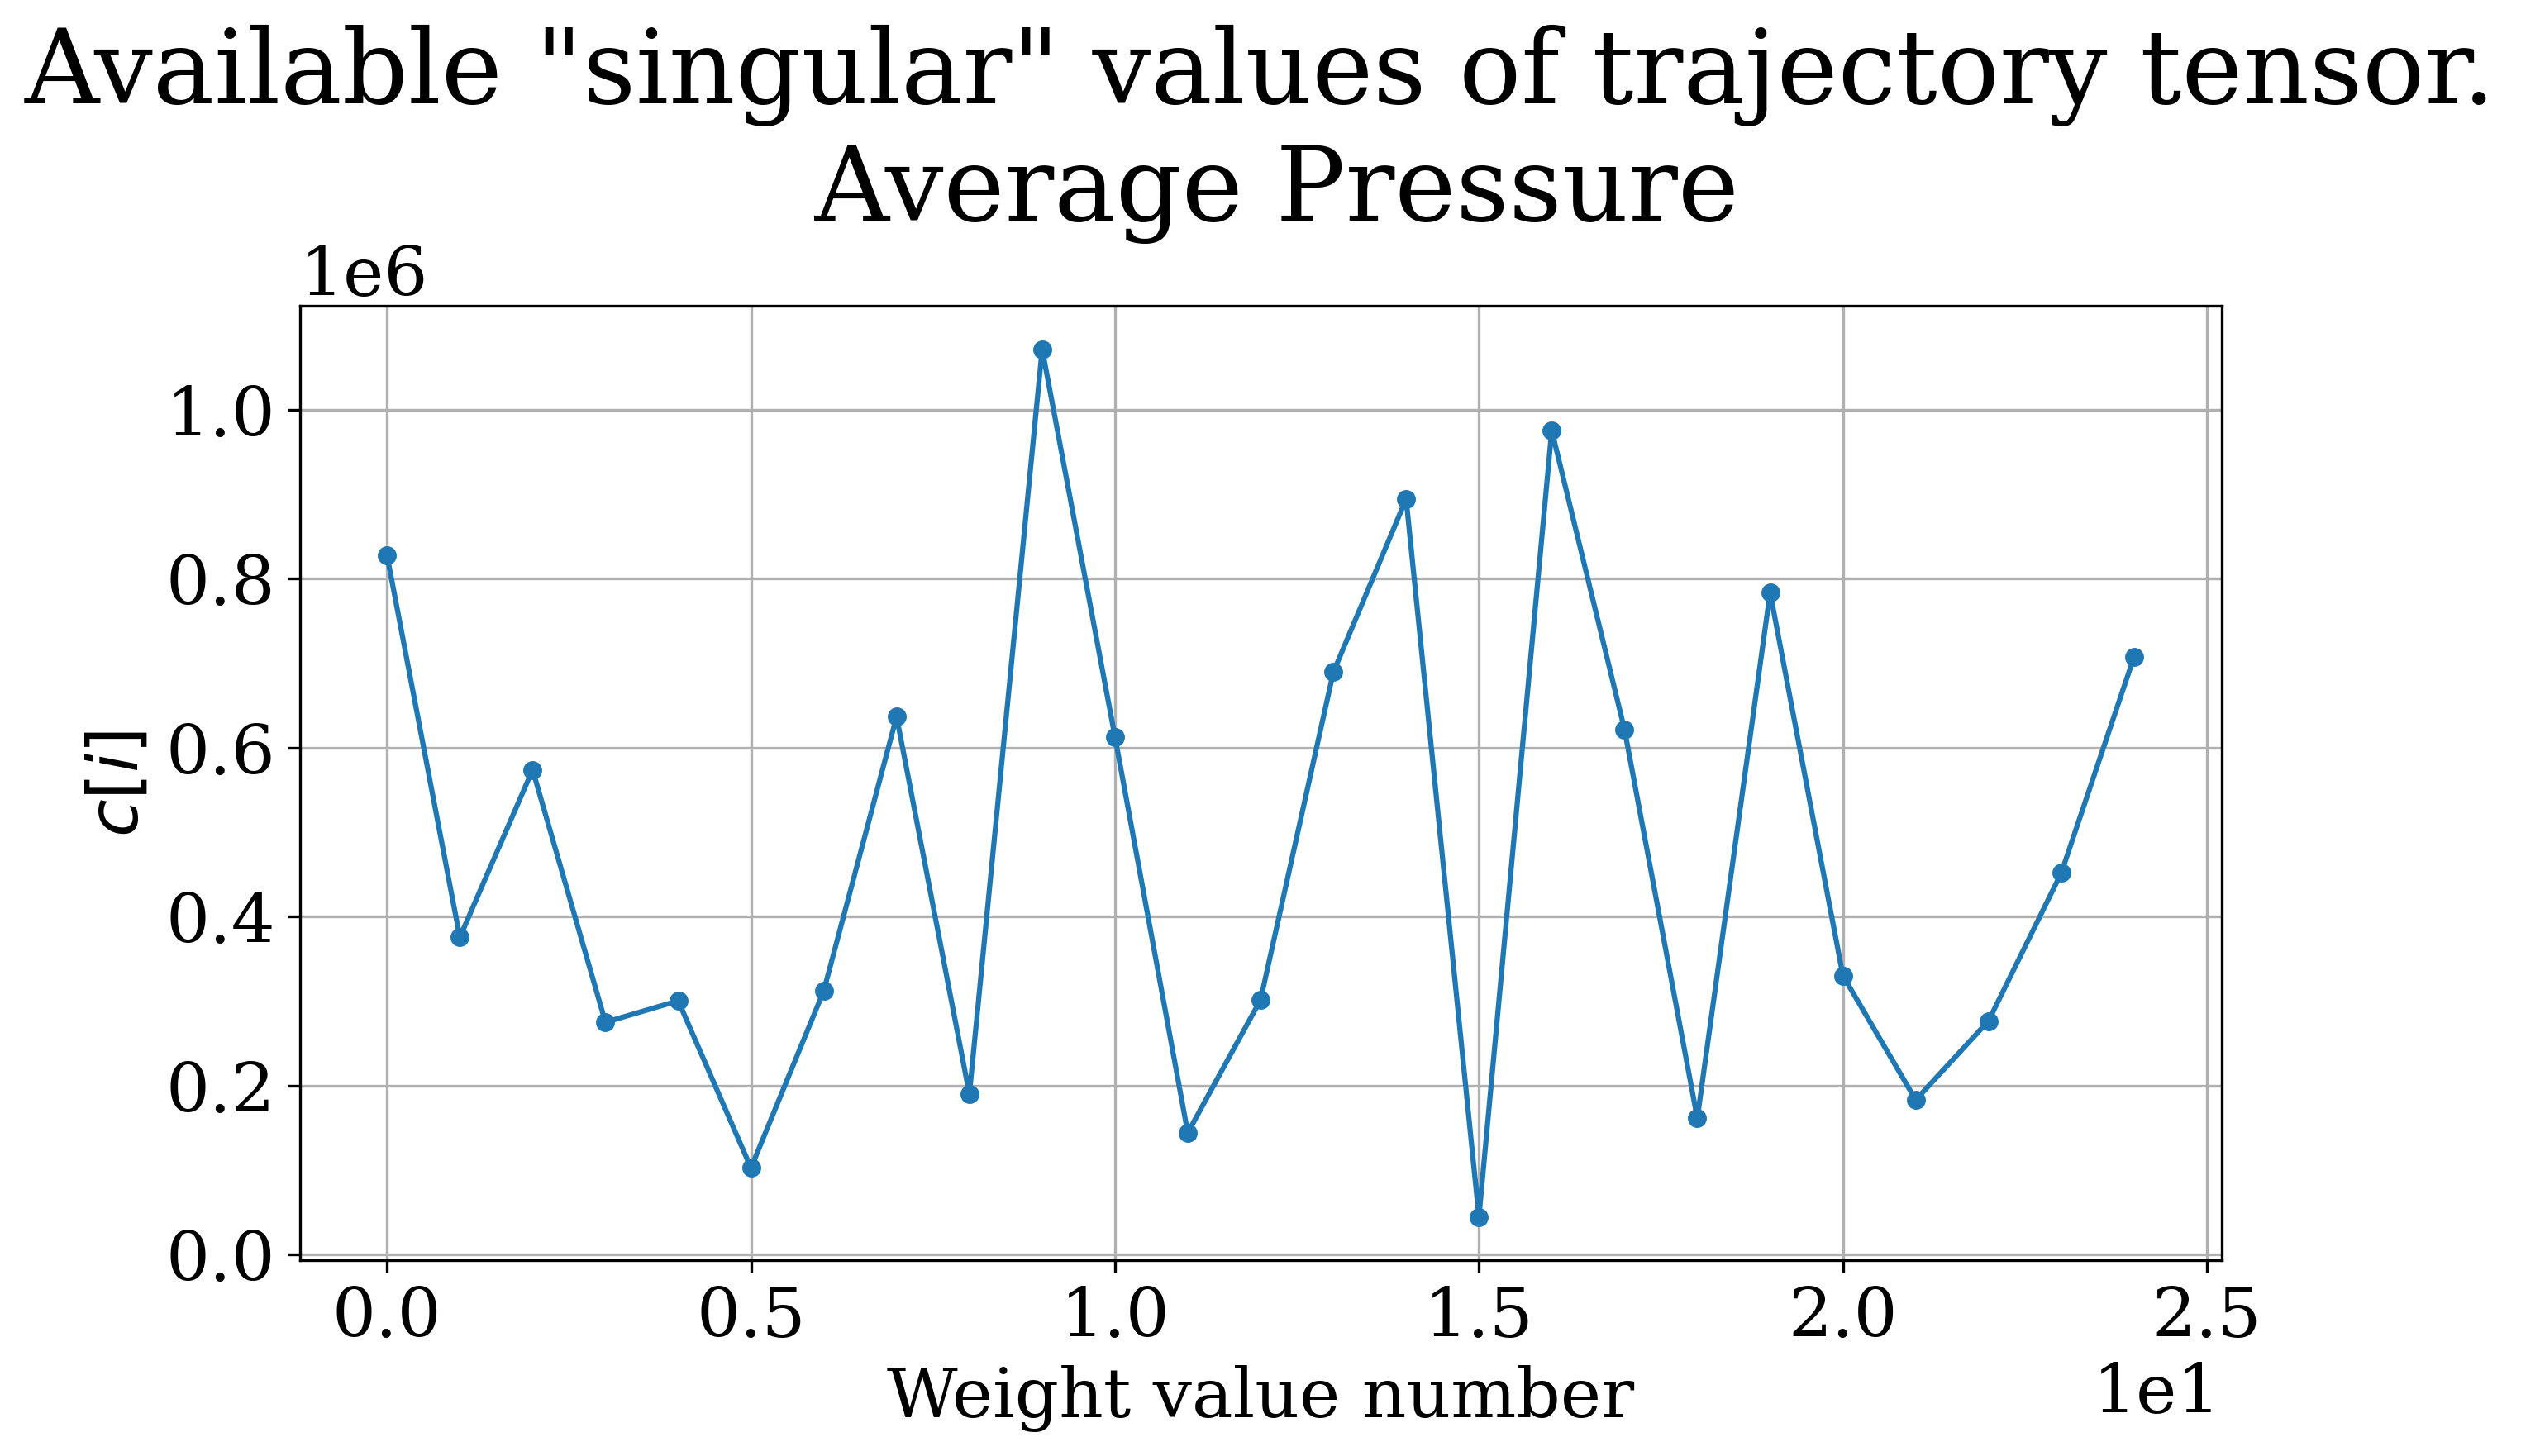

In [12]:
# have a look on "singular" values
for i in range(train_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(t_ssa_obj.weights[i], marker='.')

        ax.grid(True)
        ax.set_title(f'Available "singular" values of trajectory tensor.\n {sig_names[i]}')
        ax.set_xlabel('Weight value number')
        ax.set_ylabel(r'$c[i]$')
        ax.ticklabel_format(style='sci', scilimits=(0, 0))

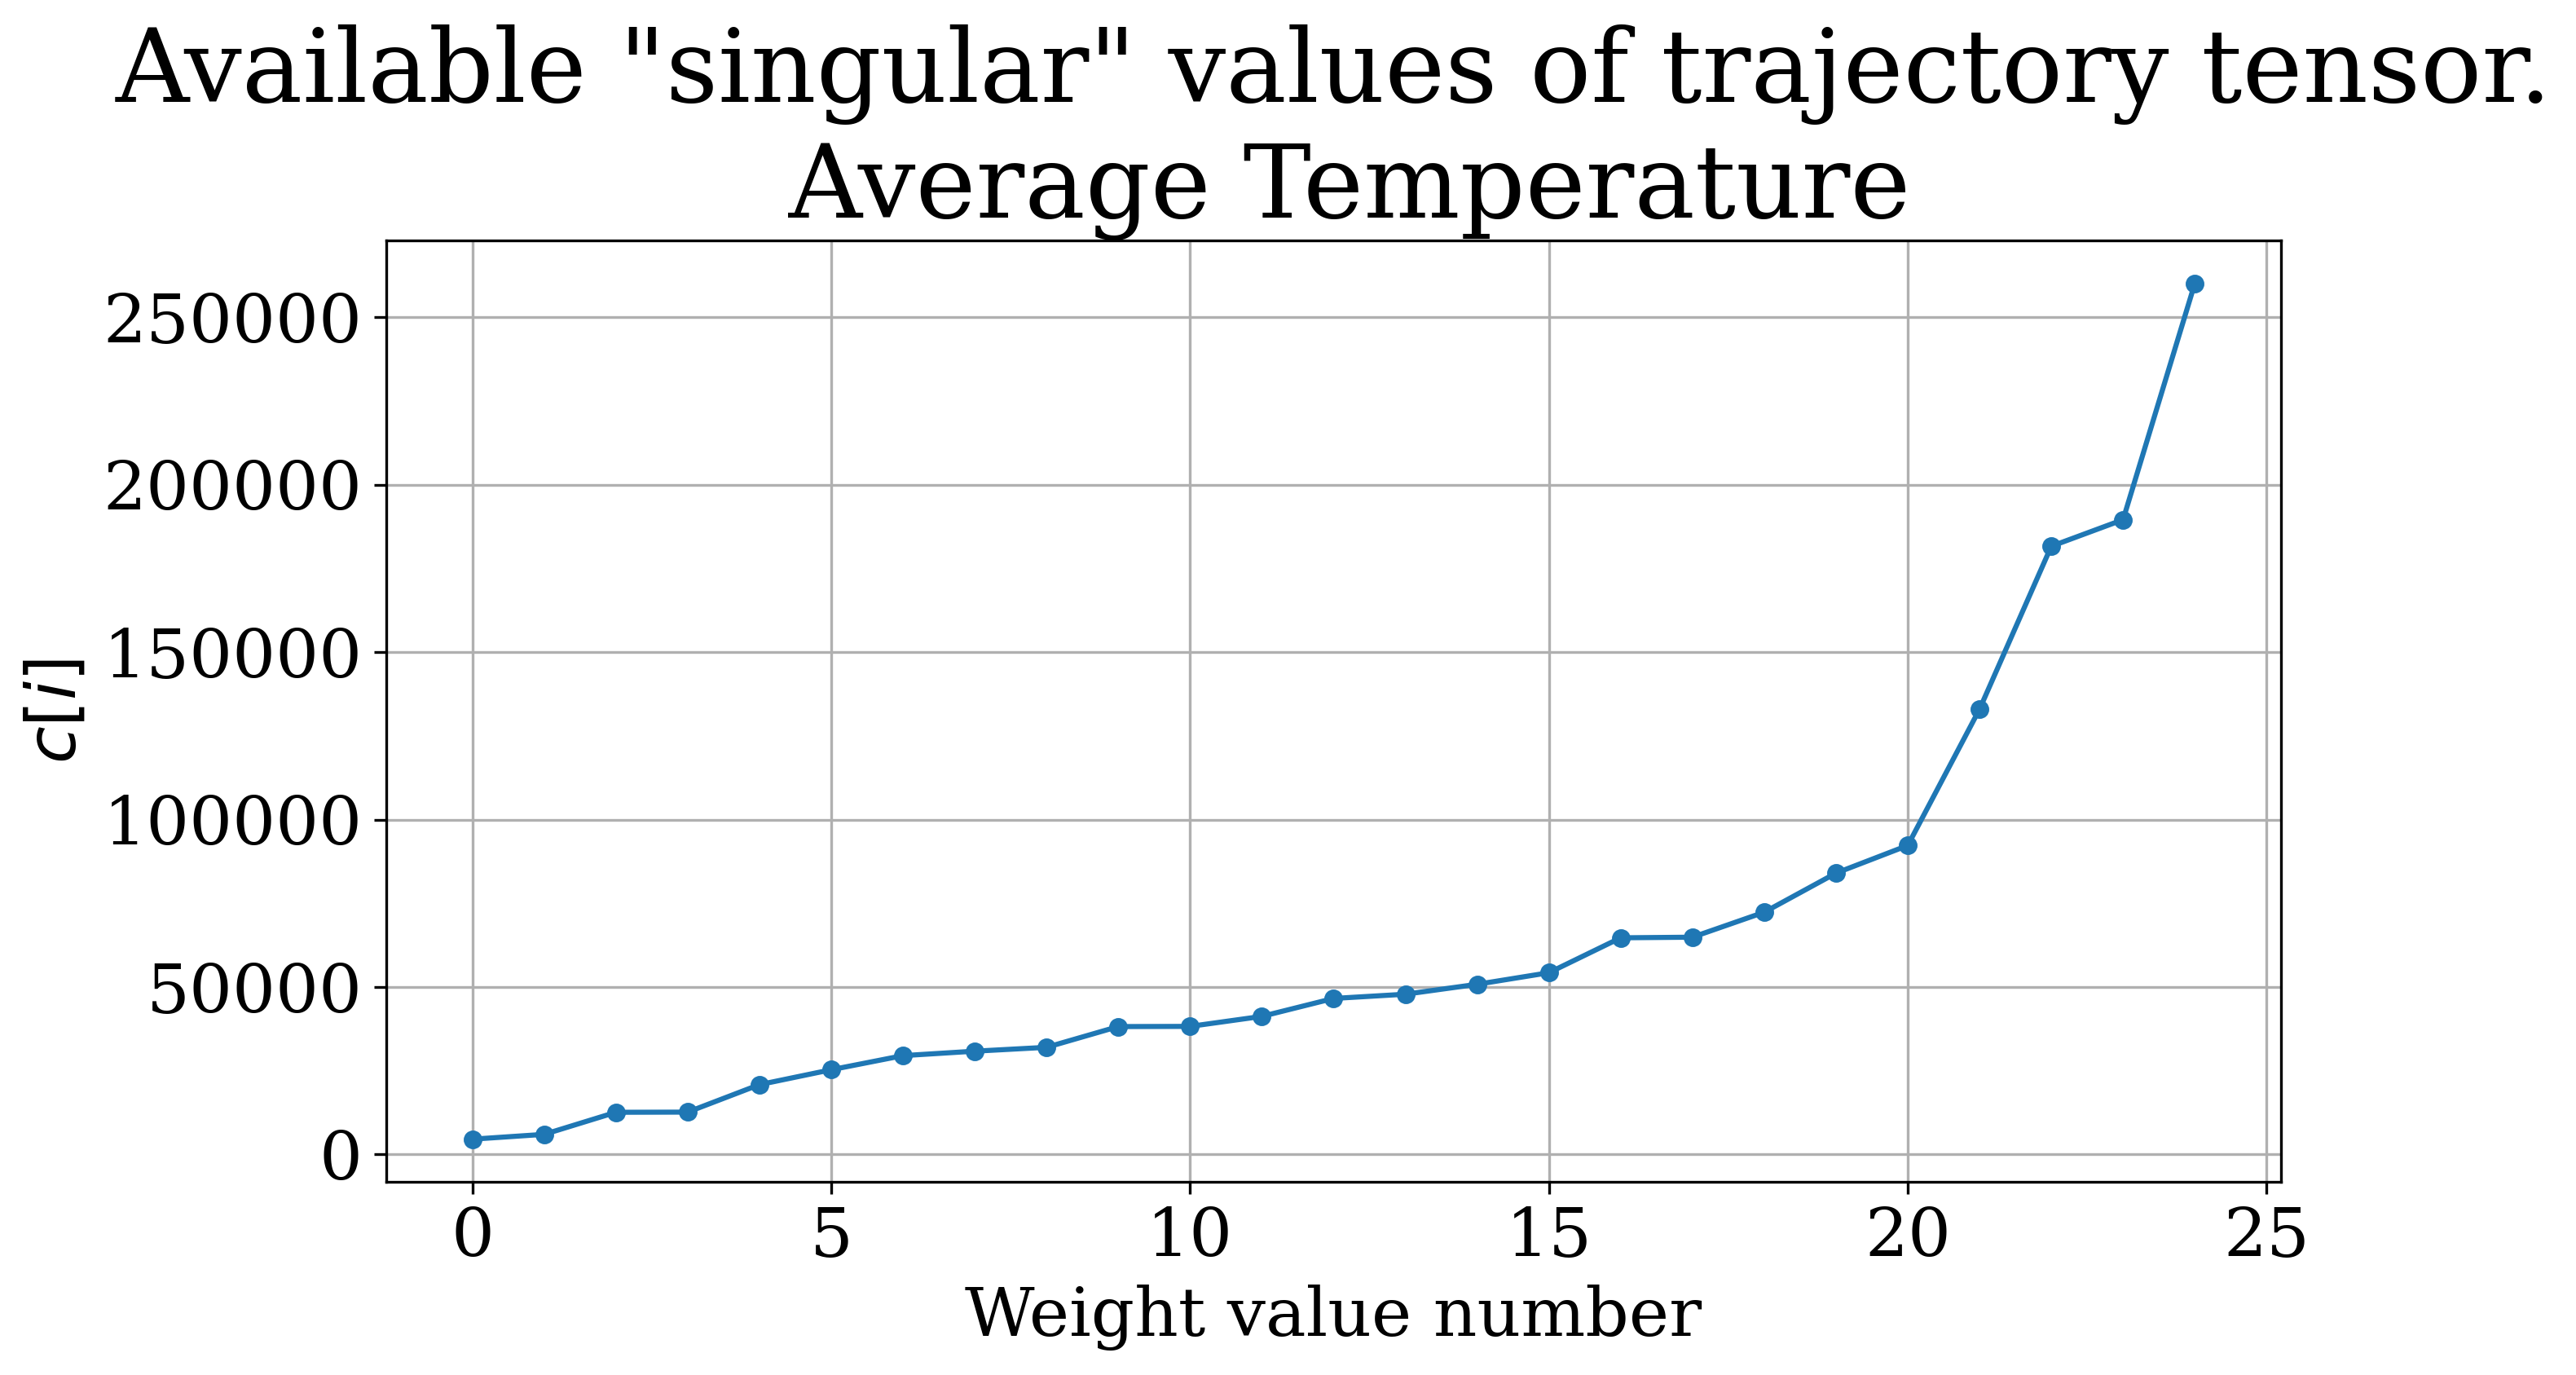

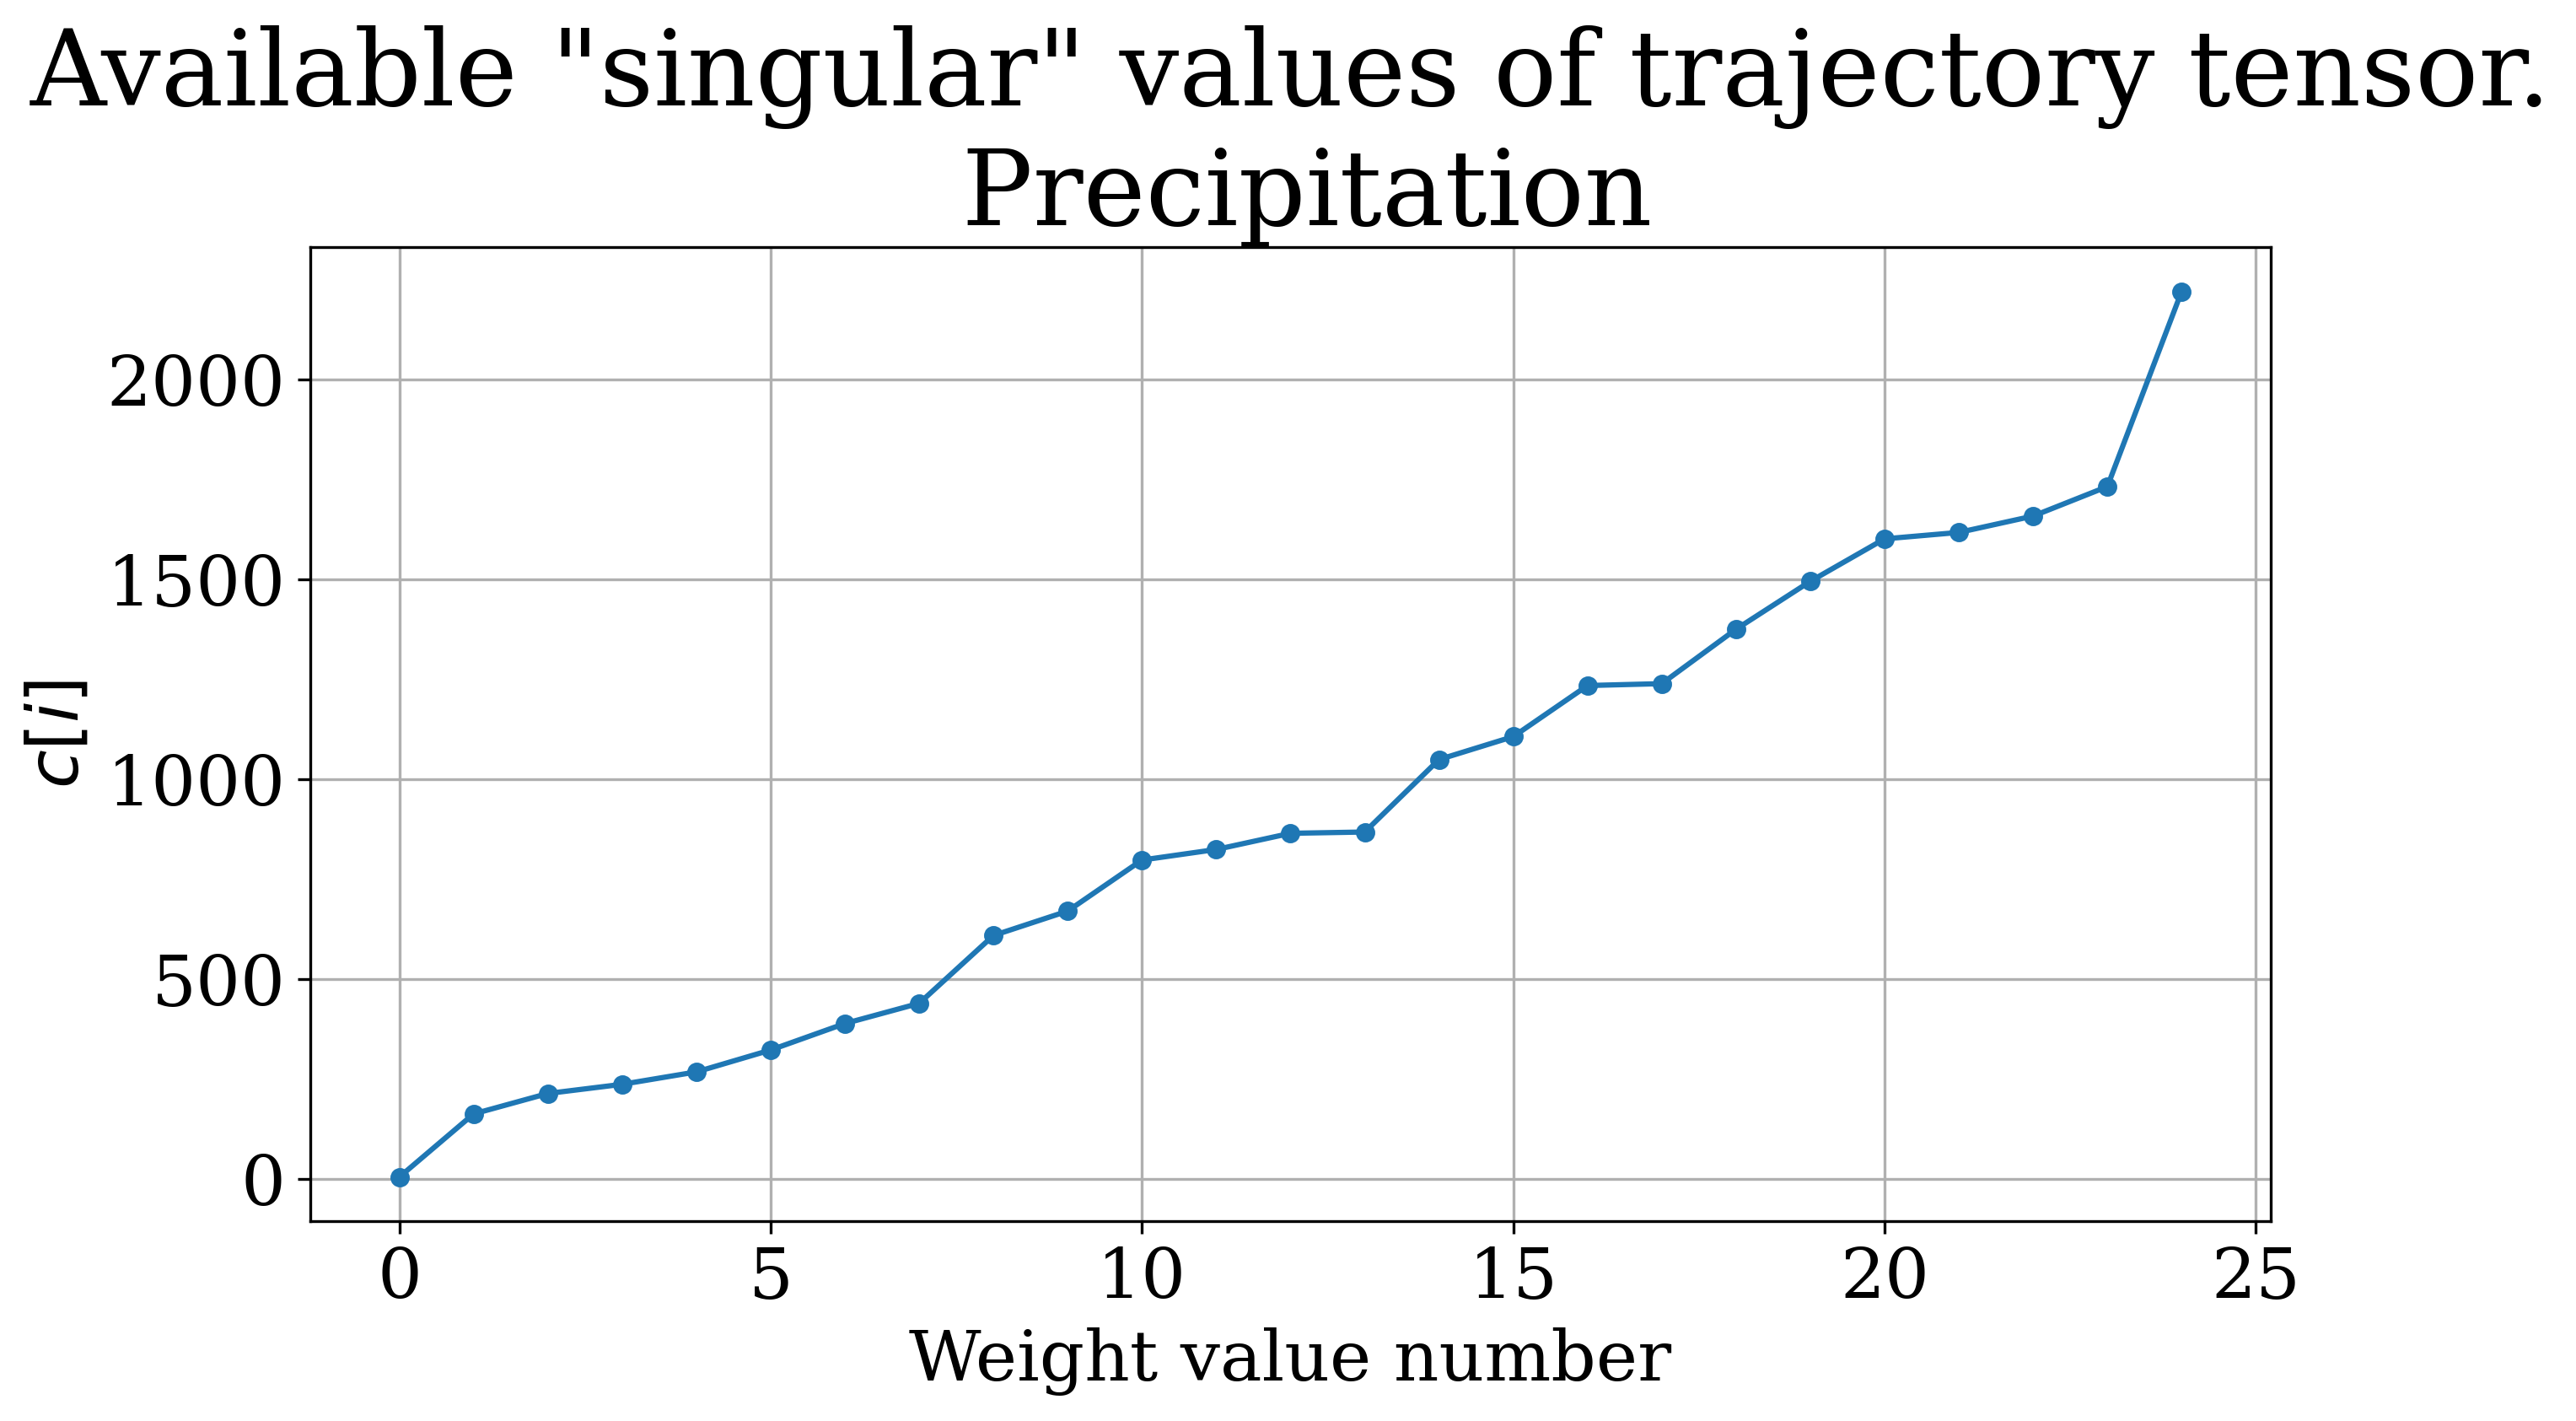

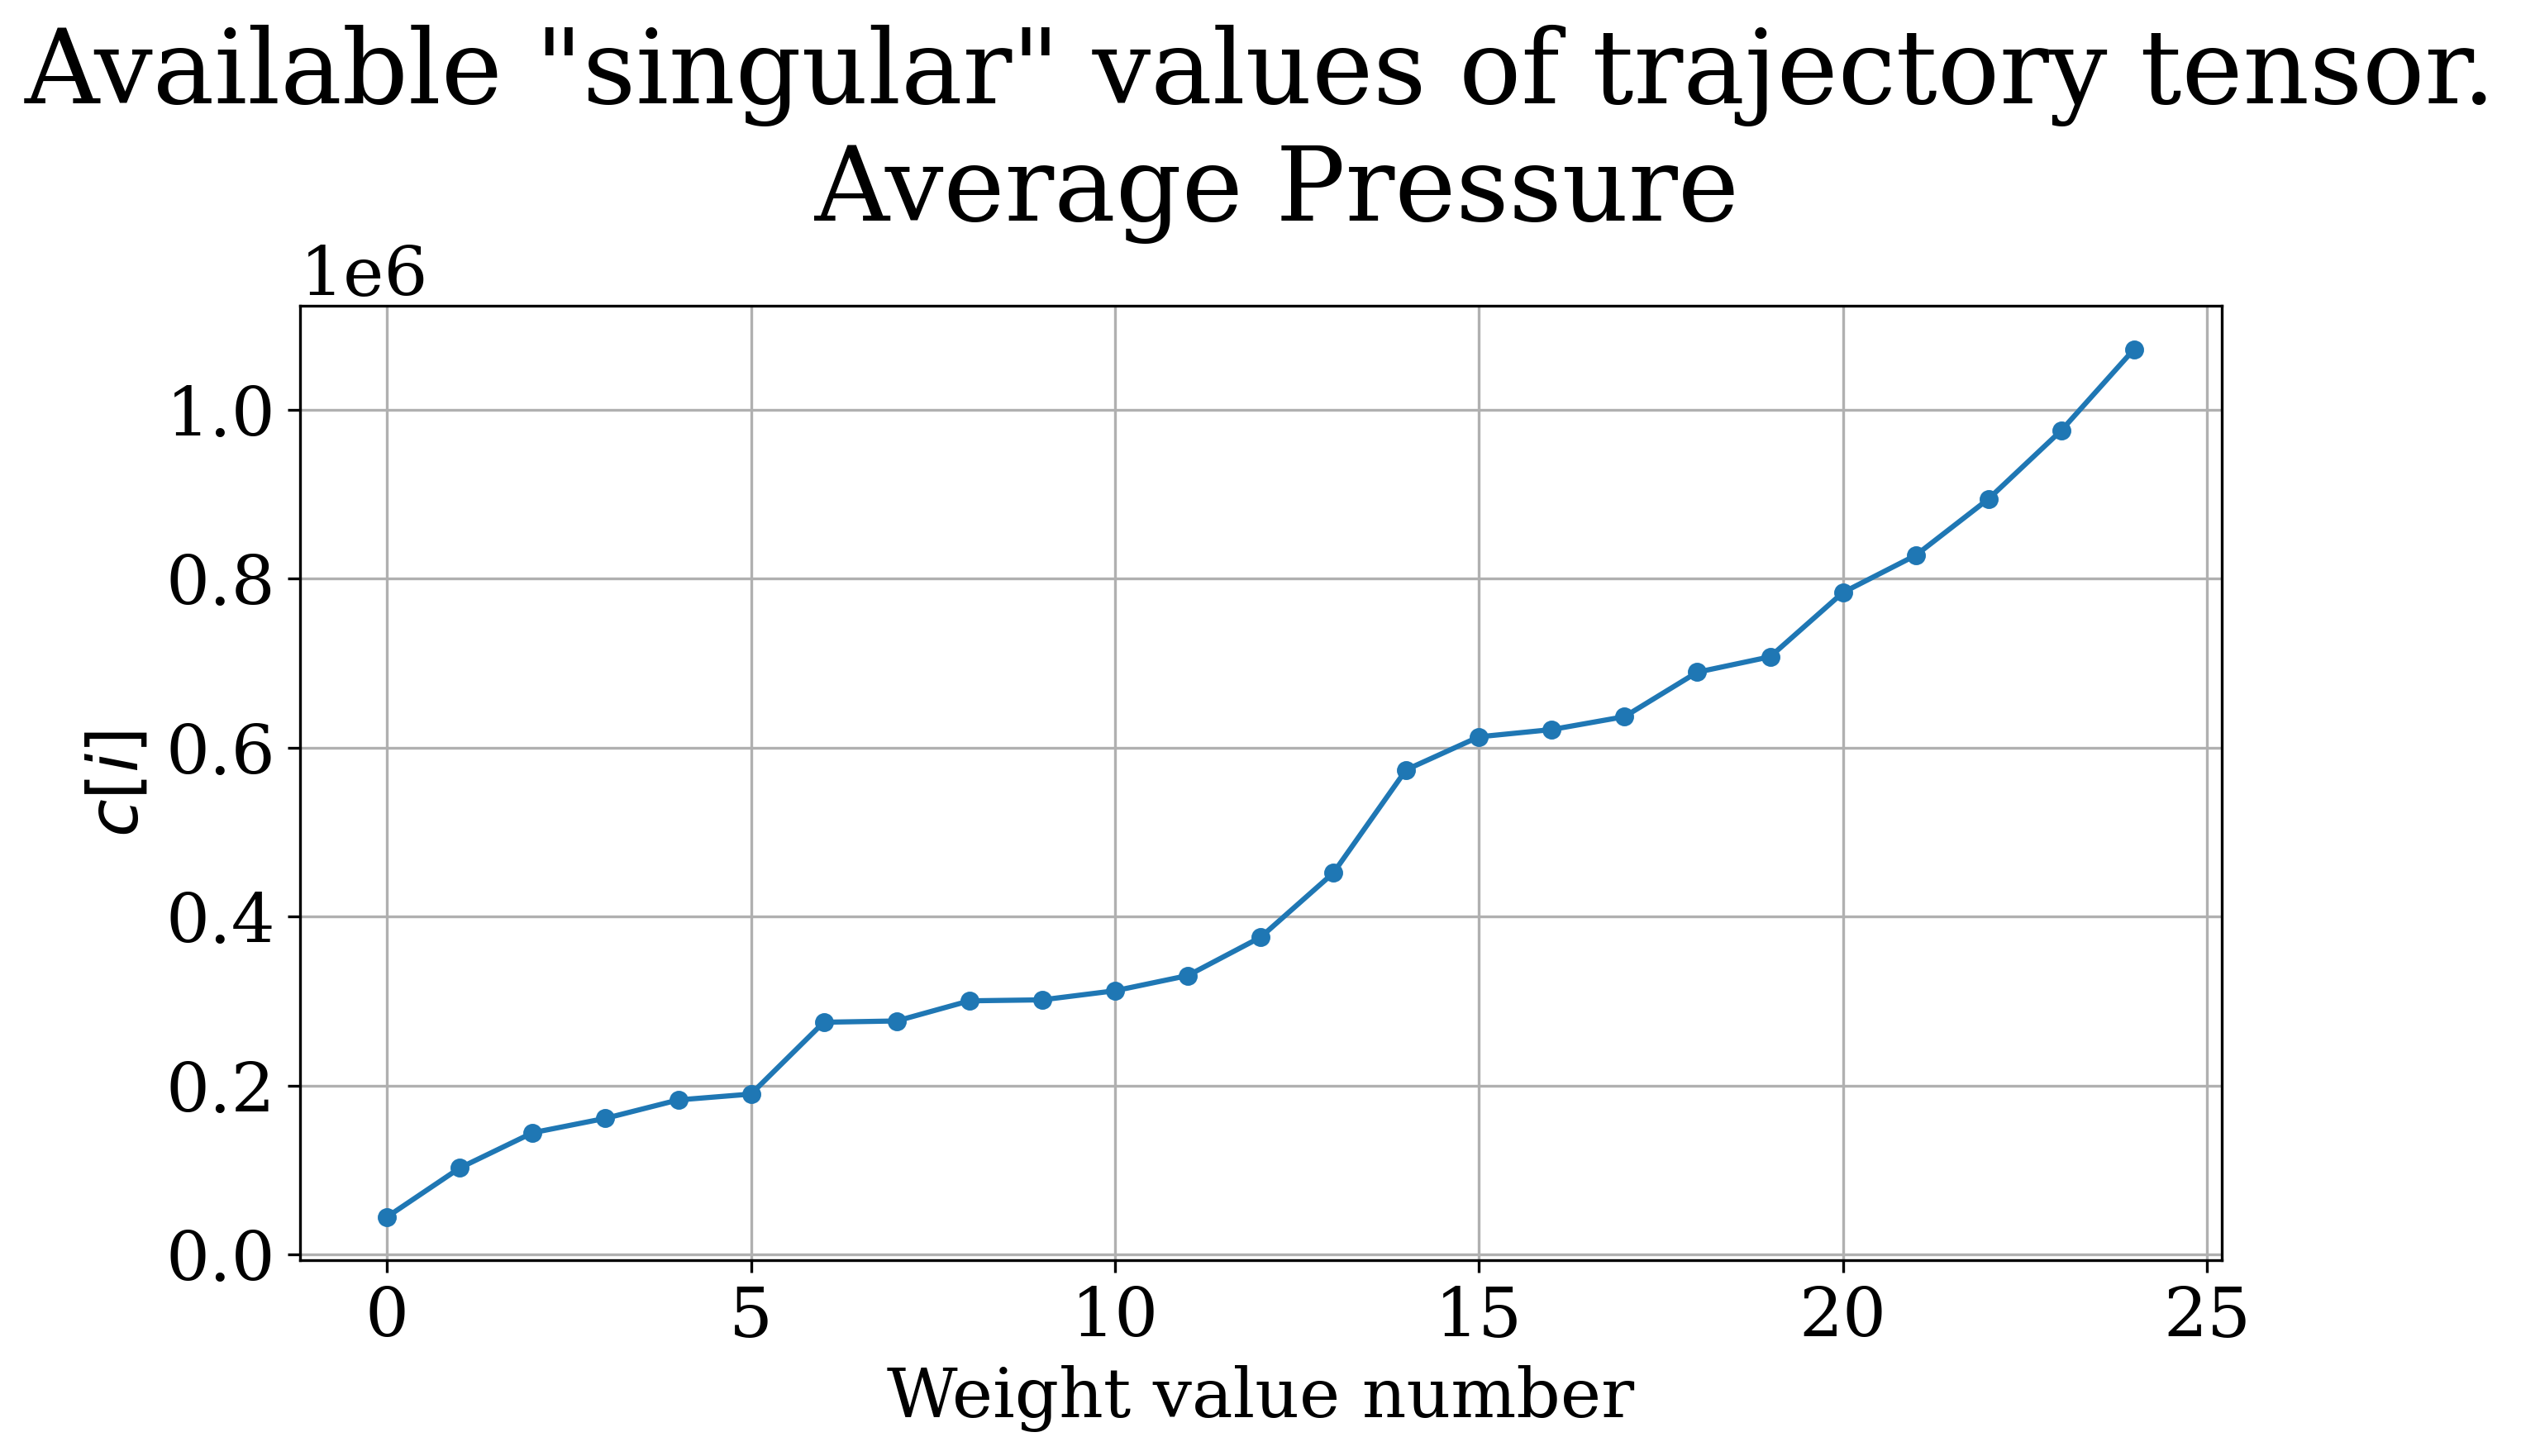

In [13]:
# plot them in descending order (in absolute values)

# as we see sign(c[i]) is the same among signals
# therefore we can assume all c[i] being positive
# (sign is drifting in factor-matrices)

weights_abs_ordered = np.sort(np.abs(t_ssa_obj.weights), axis=1)

for i in range(train_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(weights_abs_ordered[i], marker='.')

        ax.grid(True)
        ax.set_title(f'Available "singular" values of trajectory tensor.\n {sig_names[i]}')
        ax.set_xlabel('Weight value number')
        ax.set_ylabel(r'$c[i]$')
        #ax.ticklabel_format(style='sci', scilimits=(0, 0))

Now we can dispose some factors if they have small weights (or relatively small)

In [14]:
pass

In [15]:
# colours for our signals (https://colorhunt.co/palette/7f27ff9f70fdfdbf60ff8911)
# last color is for prediction drawing
color_list = ['#7F27FF', '#FF8911', '#337357', '#EE4266']

## ILS Decomposition

Простроим факторы для одного сигнала, посчитаем матрицы-невязки ганкелизации, решим на них ILS

Для уменьшения размерности задачи давайте попробуем брать только части матриц-невязки - первые $num\_columns$ столбцов

In [43]:
num_columns = 1

signal_num = 0

factor_parts = t_ssa_obj.get_available_factors(signal_num)

In [44]:
factor_parts[1].shape

(500, 25)

In [45]:
num_factors = len(factor_parts[0])

hankel_residuals = []

for i in range(num_factors):
    factor = factor_parts[0][i] * np.outer(factor_parts[1][:, i], factor_parts[2][i, :])

    hankelized_factor = factor.copy()
    t_SSA._hankelize_matrix(hankelized_factor)

    # take only a few first columns
    hankel_residuals.append((factor - hankelized_factor)[:, :num_columns])

In [46]:
# vectorize
for i in range(num_factors):
    hankel_residuals[i] = hankel_residuals[i].reshape(-1, 1)

In [47]:
# we only approximate CP-decomposition therefore sum of factors is not perfect hankel matrix
np.allclose(sum(hankel_residuals), 0)

False

In [48]:
# print residual sum's inf norm
print(np.max(np.abs(sum(hankel_residuals))))

2.3478185270709595


Будем считать, что сумма матриц-невязок равна нулю. Тогда эта система будет линейно зависимой, можем убрать один из факторов $H_0$. В оставшихся завиксируем $H_1$ в первой группе, дальше ILSом найдём разбиение

In [49]:
#build system parameters
h_0 = hankel_residuals[0]
h_1 = hankel_residuals[1].reshape(-1)

A_matrix = np.concatenate(hankel_residuals[2:], axis=1)

In [50]:
# dim of the task
A_matrix.shape

(500, 23)

In [51]:
import cvxpy

lambd = cvxpy.Variable(num_factors - 2, boolean=True)
obj = cvxpy.Minimize(cvxpy.norm(A_matrix @ lambd + h_1))

prob = cvxpy.Problem(obj)
prob.solve(solver='SCIP')

88.70738155688608

In [52]:
print(prob.value)
print(lambd.value)

88.70738155688608
[0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]


In [60]:
# form grouping
lambd_full = np.concatenate(([0, 1], lambd.value))
first_group = (lambd_full == 1)

cur_grouping = [np.argwhere(first_group).flatten().tolist(), np.argwhere(~first_group).flatten().tolist()]
cur_grouping

[[1, 5, 8, 9, 22, 23],
 [0, 2, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24]]

In [61]:
overall_grouping = []

for i in range(num_signals):
    if i == signal_num:
        overall_grouping.append(cur_grouping)
    else:
        overall_grouping.append([[j for j in range(cp_rank)]])

In [66]:
def FitAndDescribe(groups: list):
    """fit tssa object with grouping, print hankel residuals, plot signal's components

    Args:
        groups (list): 
    Returns: components figures
    """
    for i in range(train_data.shape[1]):
        t_ssa_obj.set_factors_grouping(groups[i], i)

    comp_sigs, hank_resid_abs, hank_resid_rel = t_ssa_obj.decompose_signals()

    # view relative hankerlization errors
    for i in range(train_data.shape[1]):
        print(f'Group for {sig_names[i]}: {groups[i]}')
        print(f'Rel hankel. errors for {sig_names[i]}\n{hank_resid_rel[i].tolist()}\nMean = {np.mean(hank_resid_rel[i])}\n')
        print(f'Abs hankel. errors for {sig_names[i]}\n{hank_resid_abs[i].tolist()}\nMean = {np.mean(hank_resid_abs[i])}\n')


    figs_container = []

    # plot results
    for i in range(train_data.shape[1]):
        with EnableJournalStylePlotting():
            fig, axs = plt.subplots(nrows=len(comp_sigs[i]), ncols=1, figsize=(15, 8))
            figs_container.append(fig)

            if len(comp_sigs[i]) == 1:
                axs = [axs]
    
            for j in range(len(comp_sigs[i])):
                axs[j].plot(time_grid_train, comp_sigs[i][j], label=f'Component {j + 1}', color=color_list[i])
    
                if j != len(comp_sigs[i]) - 1:
                    axs[j].tick_params(axis='x', labelsize=0)
    
                axs[j].grid(True)
                axs[j].legend()
    
            fig.supylabel(f'{sig_units[i]}', fontsize=20)
            fig.supxlabel('$t$', fontsize=20)
            fig.suptitle(f'{sig_names[i]}', fontsize=30)
    
    return figs_container

Group for Average Temperature: [[1, 5, 8, 9, 22, 23], [0, 2, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24]]
Rel hankel. errors for Average Temperature
[0.9659977729124194, 0.9935240444582892]
Mean = 0.9797609086853543

Abs hankel. errors for Average Temperature
[54083.12109375, 54095.203125]
Mean = 54089.162109375

Group for Precipitation: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]
Rel hankel. errors for Precipitation
[0.03715746570070483]
Mean = 0.03715746570070483

Abs hankel. errors for Precipitation
[63.10709762573242]
Mean = 63.10709762573242

Group for Average Pressure: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]
Rel hankel. errors for Average Pressure
[0.0020668626575057877]
Mean = 0.0020668626575057877

Abs hankel. errors for Average Pressure
[2310.228759765625]
Mean = 2310.228759765625



[<Figure size 4500x2400 with 2 Axes>,
 <Figure size 4500x2400 with 1 Axes>,
 <Figure size 4500x2400 with 1 Axes>]

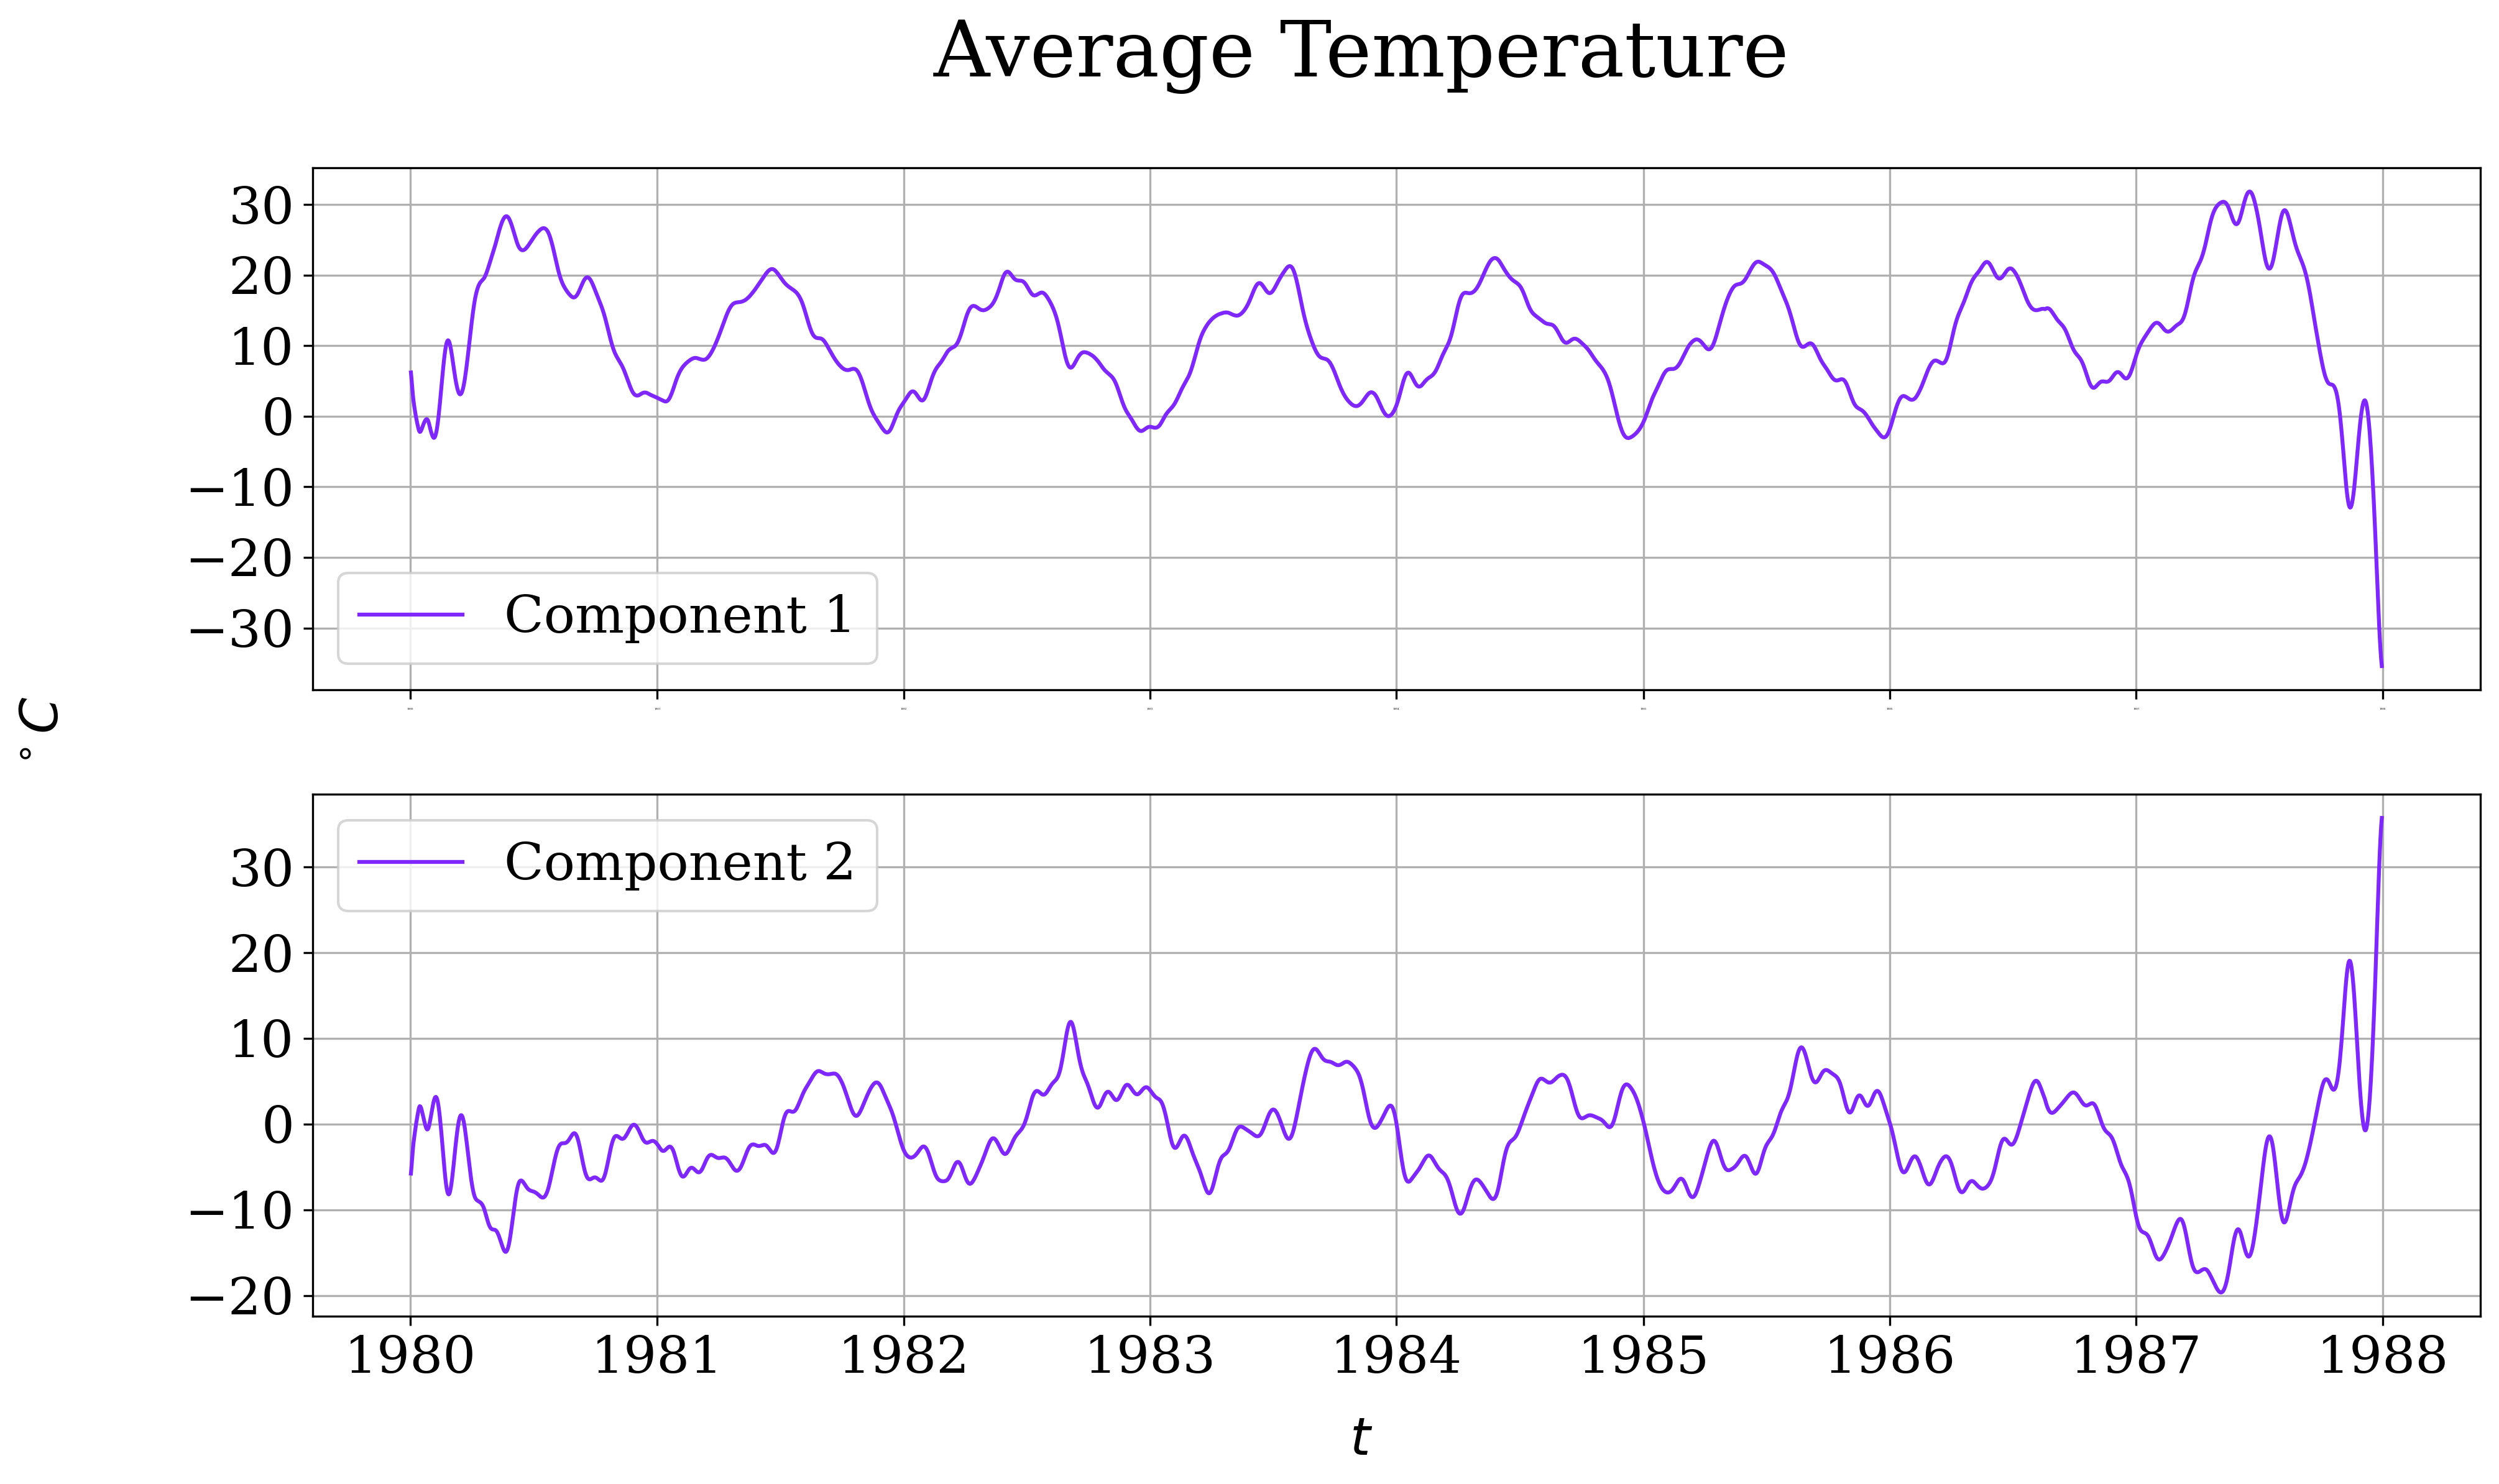

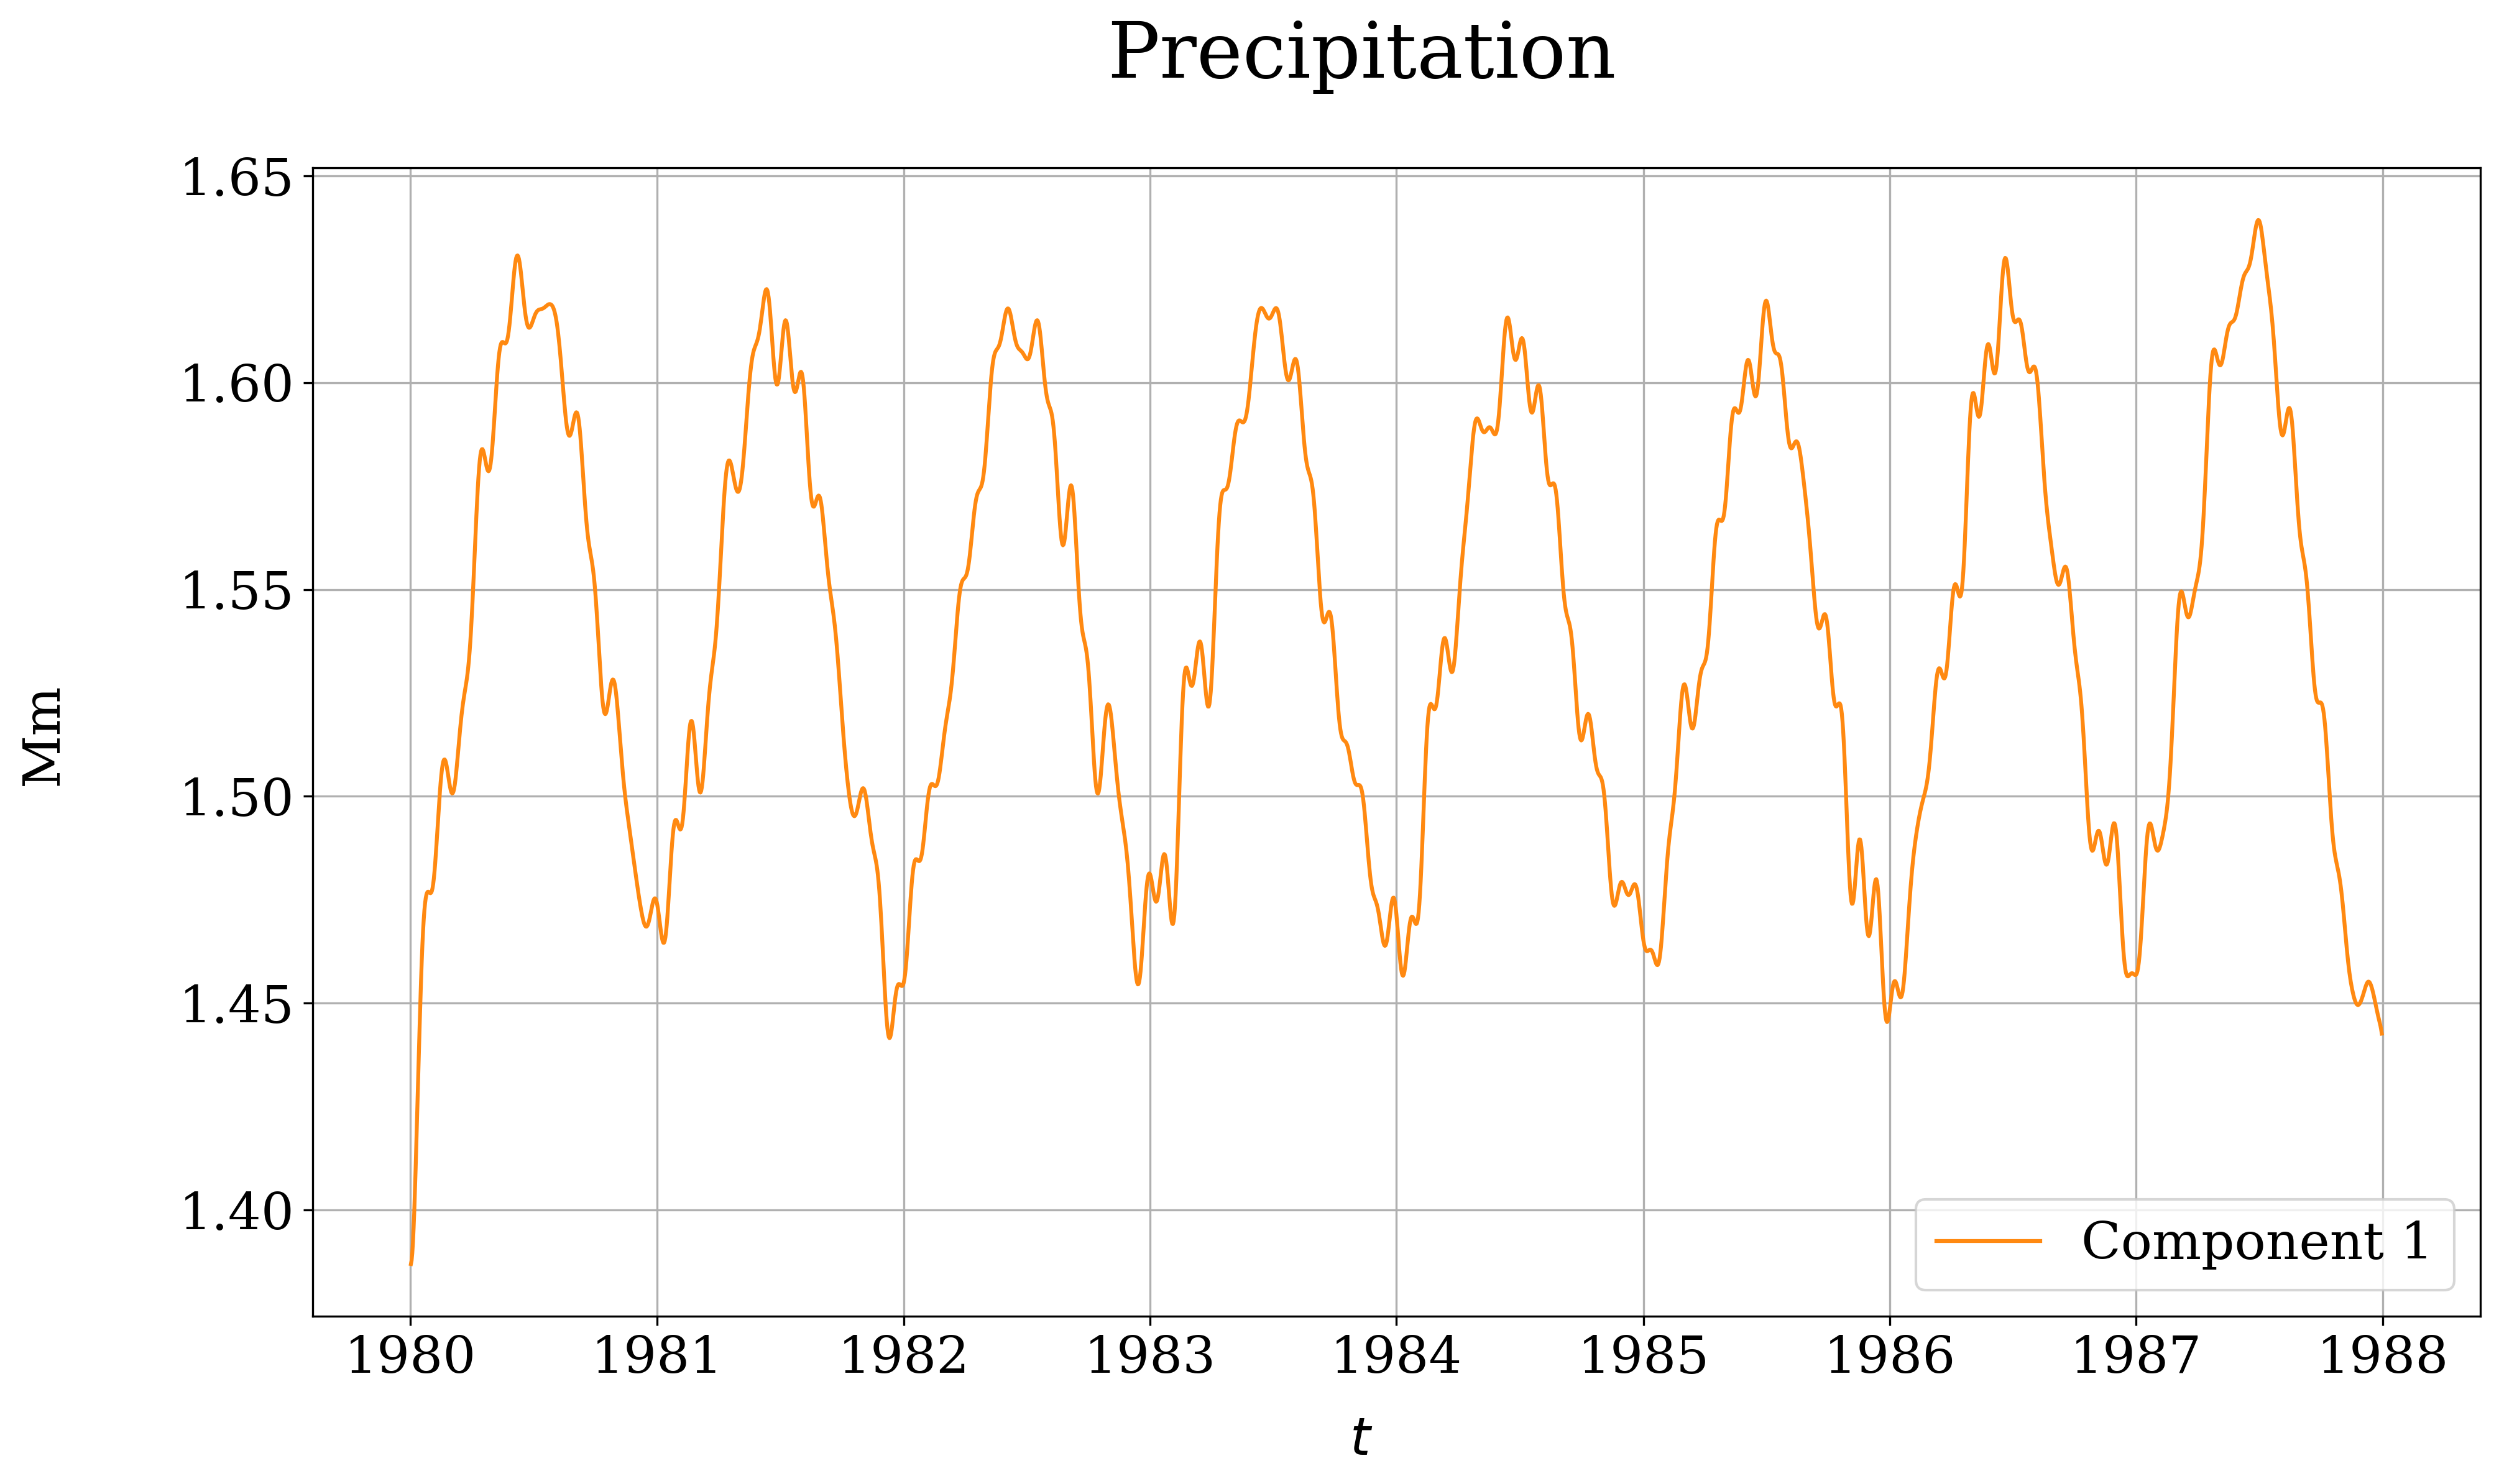

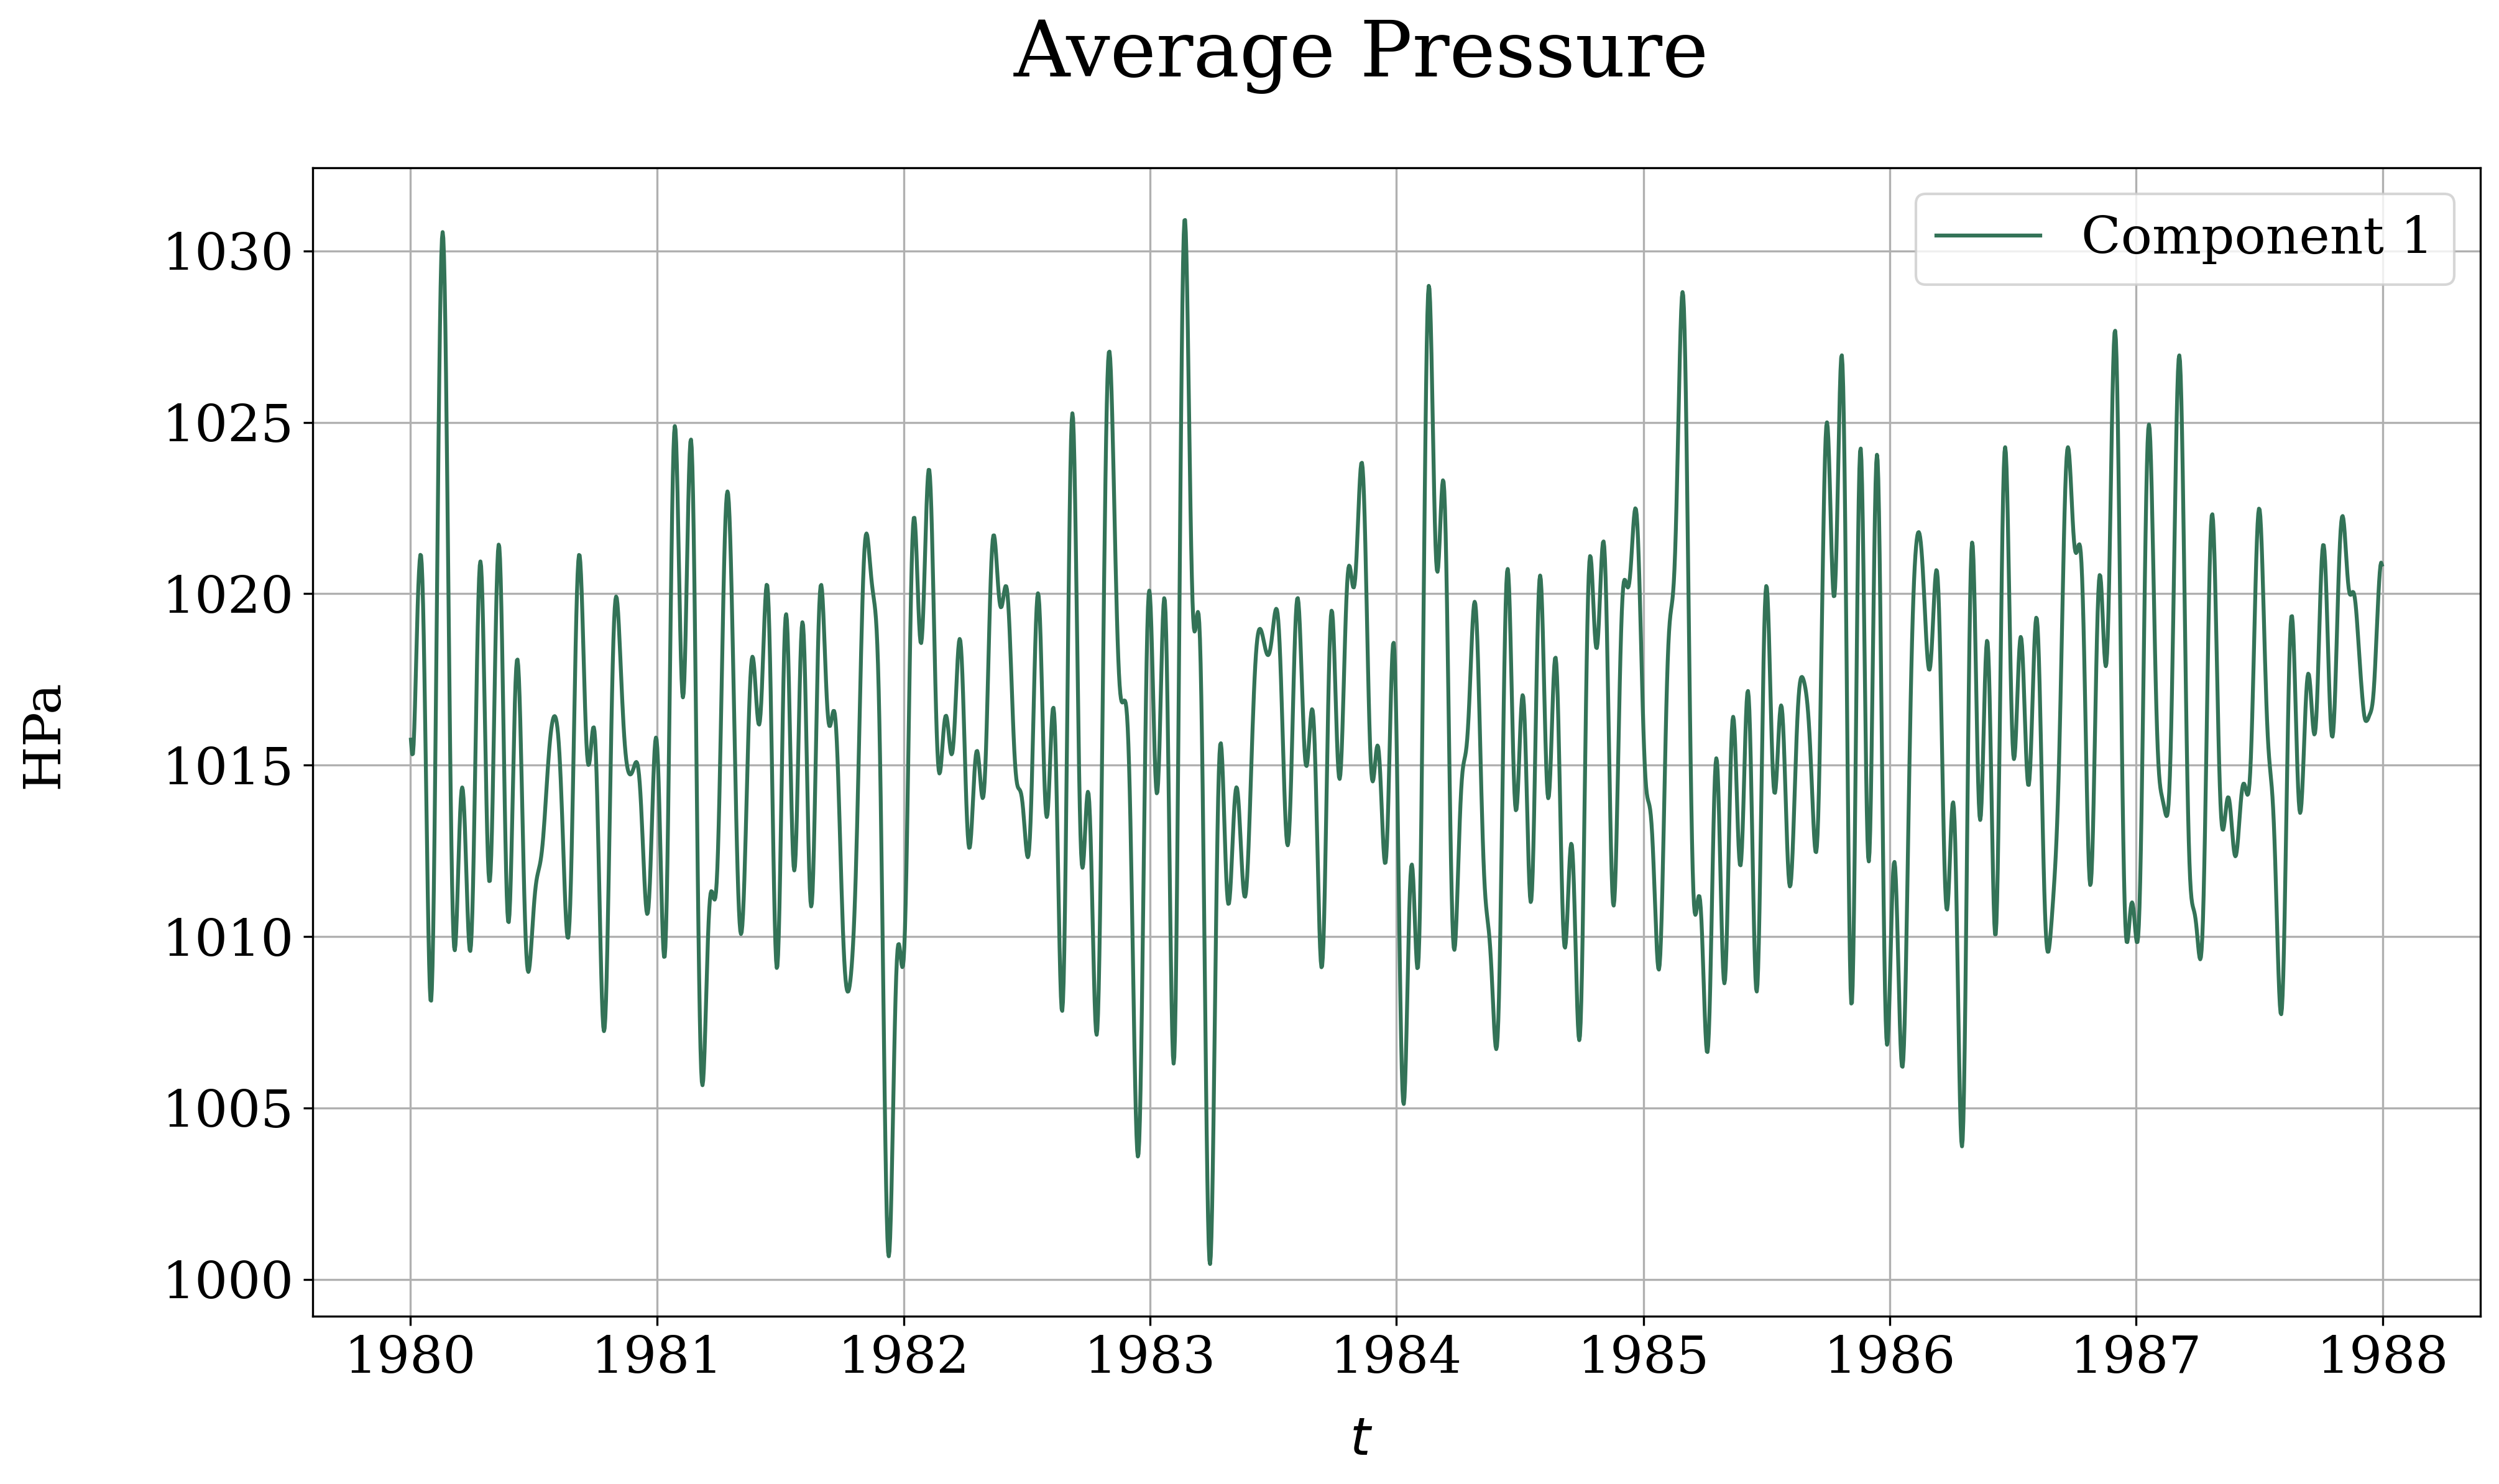

In [67]:
FitAndDescribe(overall_grouping)

---

In [96]:
num_columns = 4

# try 3rd signal
signal_num = 2

factor_parts = t_ssa_obj.get_available_factors(signal_num)

In [97]:
factor_parts[1].shape

(500, 25)

In [98]:
num_factors = len(factor_parts[0])

hankel_residuals = []

for i in range(num_factors):
    factor = factor_parts[0][i] * np.outer(factor_parts[1][:, i], factor_parts[2][i, :])

    hankelized_factor = factor.copy()
    t_SSA._hankelize_matrix(hankelized_factor)

    # take only a few first columns
    hankel_residuals.append((factor - hankelized_factor)[:, :num_columns])

In [99]:
# vectorize
for i in range(num_factors):
    hankel_residuals[i] = hankel_residuals[i].reshape(-1, 1)

In [100]:
# we only approximate CP-decomposition therefore sum of factors is not perfect hankel matrix
np.allclose(sum(hankel_residuals), 0)

False

In [101]:
# print residual sum's inf norm
print(np.max(np.abs(sum(hankel_residuals))))

7.831597919152443


Будем считать, что сумма матриц-невязок равна нулю. Тогда эта система будет линейно зависимой, можем убрать один из факторов $H_0$. В оставшихся завиксируем $H_1$ в первой группе, дальше ILSом найдём разбиение

In [102]:
#build system parameters
h_0 = hankel_residuals[0]
h_1 = hankel_residuals[1].reshape(-1)

A_matrix = np.concatenate(hankel_residuals[2:], axis=1)

In [103]:
# dim of the task
A_matrix.shape

(2000, 23)

In [104]:
import cvxpy

lambd = cvxpy.Variable(num_factors - 2, boolean=True)
obj = cvxpy.Minimize(cvxpy.norm(A_matrix @ lambd + h_1))

prob = cvxpy.Problem(obj)
prob.solve(solver='SCIP')

1357.4131382861347

In [105]:
print(prob.value)
print(lambd.value)

1357.4131382861347
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  0.00000000e+00 -1.04627422e-15  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00]


In [106]:
# form grouping
lambd_full = np.concatenate(([0, 1], lambd.value))
first_group = (lambd_full == 1)

cur_grouping = [np.argwhere(first_group).flatten().tolist(), np.argwhere(~first_group).flatten().tolist()]
cur_grouping

[[1, 2, 3, 4, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 21, 22, 23, 24],
 [0, 5, 6, 10, 13, 19, 20]]

In [107]:
overall_grouping = []

for i in range(num_signals):
    if i == signal_num:
        overall_grouping.append(cur_grouping)
    else:
        overall_grouping.append([[j for j in range(cp_rank)]])

In [108]:
def FitAndDescribe(groups: list):
    """fit tssa object with grouping, print hankel residuals, plot signal's components

    Args:
        groups (list): 
    Returns: components figures
    """
    for i in range(train_data.shape[1]):
        t_ssa_obj.set_factors_grouping(groups[i], i)

    comp_sigs, hank_resid_abs, hank_resid_rel = t_ssa_obj.decompose_signals()

    # view relative hankerlization errors
    for i in range(train_data.shape[1]):
        print(f'Group for {sig_names[i]}: {groups[i]}')
        print(f'Rel hankel. errors for {sig_names[i]}\n{hank_resid_rel[i].tolist()}\nMean = {np.mean(hank_resid_rel[i])}\n')
        print(f'Abs hankel. errors for {sig_names[i]}\n{hank_resid_abs[i].tolist()}\nMean = {np.mean(hank_resid_abs[i])}\n')


    figs_container = []

    # plot results
    for i in range(train_data.shape[1]):
        with EnableJournalStylePlotting():
            fig, axs = plt.subplots(nrows=len(comp_sigs[i]), ncols=1, figsize=(15, 8))
            figs_container.append(fig)

            if len(comp_sigs[i]) == 1:
                axs = [axs]
    
            for j in range(len(comp_sigs[i])):
                axs[j].plot(time_grid_train, comp_sigs[i][j], label=f'Component {j + 1}', color=color_list[i])
    
                if j != len(comp_sigs[i]) - 1:
                    axs[j].tick_params(axis='x', labelsize=0)
    
                axs[j].grid(True)
                axs[j].legend()
    
            fig.supylabel(f'{sig_units[i]}', fontsize=20)
            fig.supxlabel('$t$', fontsize=20)
            fig.suptitle(f'{sig_names[i]}', fontsize=30)
    
    return figs_container

Group for Average Temperature: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]
Rel hankel. errors for Average Temperature
[0.06400409688940169]
Mean = 0.06400409688940169

Abs hankel. errors for Average Temperature
[838.7006225585938]
Mean = 838.7006225585938

Group for Precipitation: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]
Rel hankel. errors for Precipitation
[0.03715746570070483]
Mean = 0.03715746570070483

Abs hankel. errors for Precipitation
[63.10709762573242]
Mean = 63.10709762573242

Group for Average Pressure: [[1, 2, 3, 4, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 21, 22, 23, 24], [0, 5, 6, 10, 13, 19, 20]]
Rel hankel. errors for Average Pressure
[0.3287318500320715, 0.9887418020830041]
Mean = 0.6587368260575378

Abs hankel. errors for Average Pressure
[408589.28125, 408590.9375]
Mean = 408590.109375



[<Figure size 4500x2400 with 1 Axes>,
 <Figure size 4500x2400 with 1 Axes>,
 <Figure size 4500x2400 with 2 Axes>]

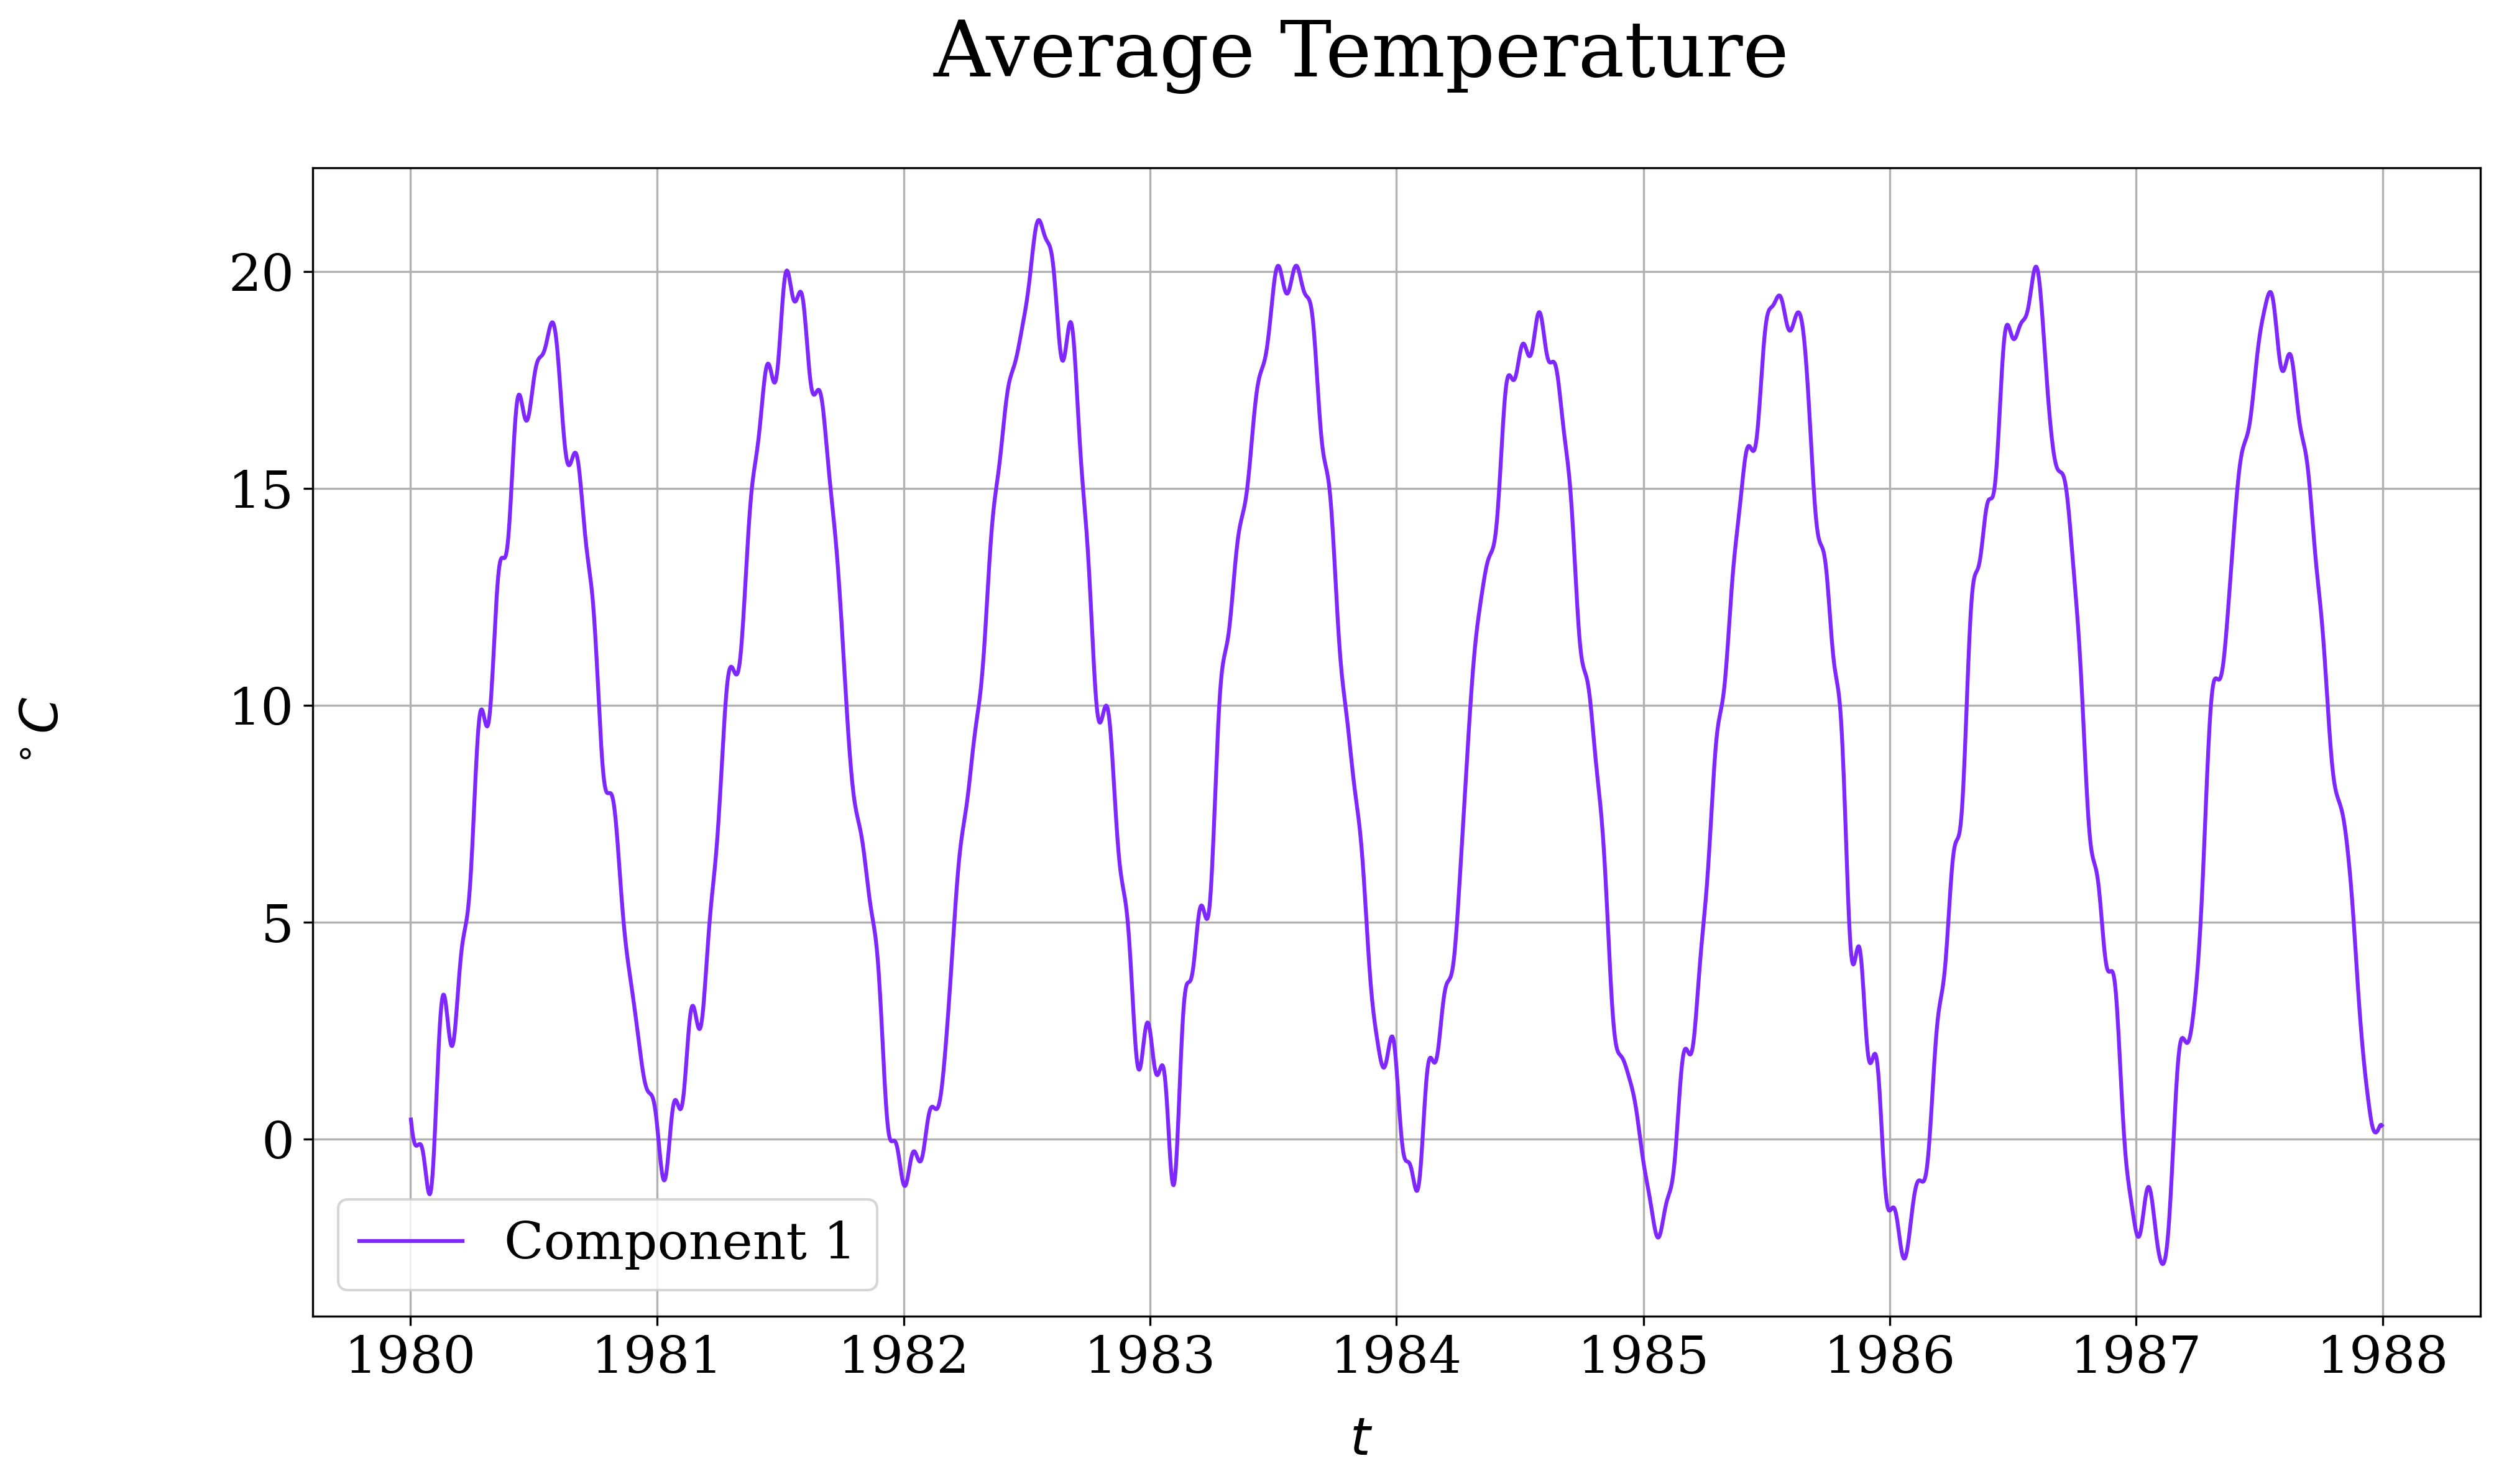

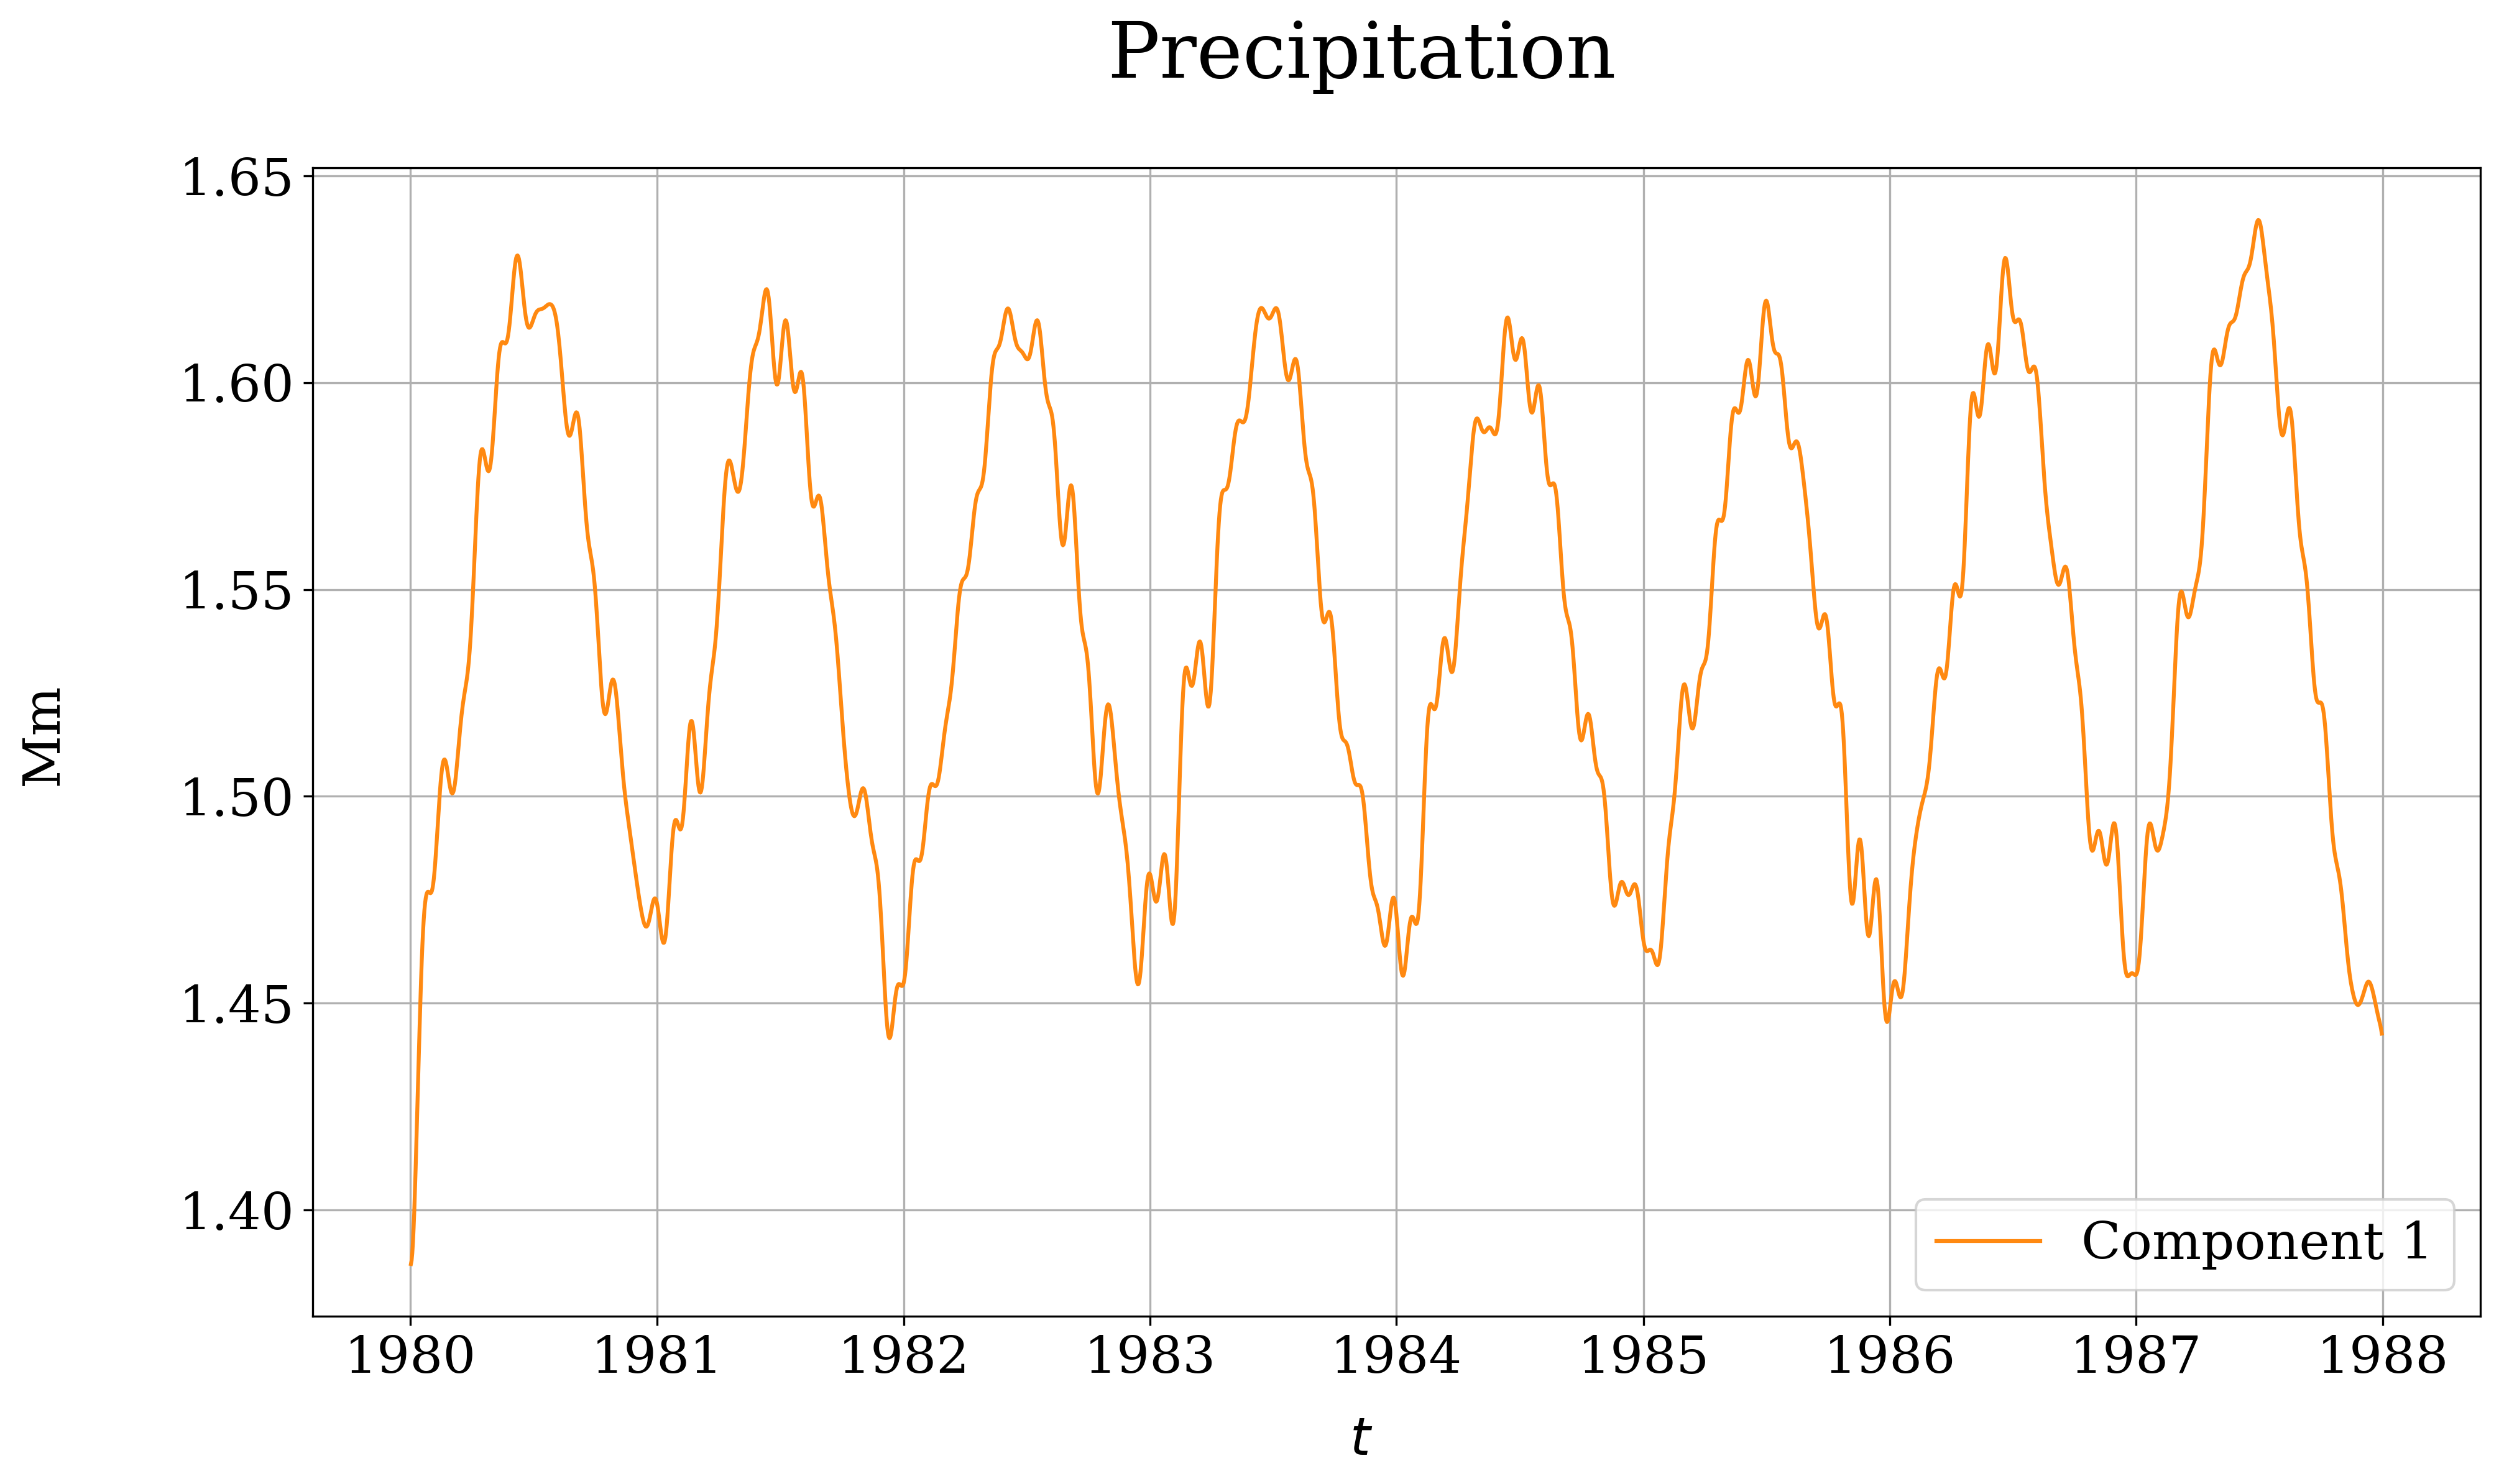

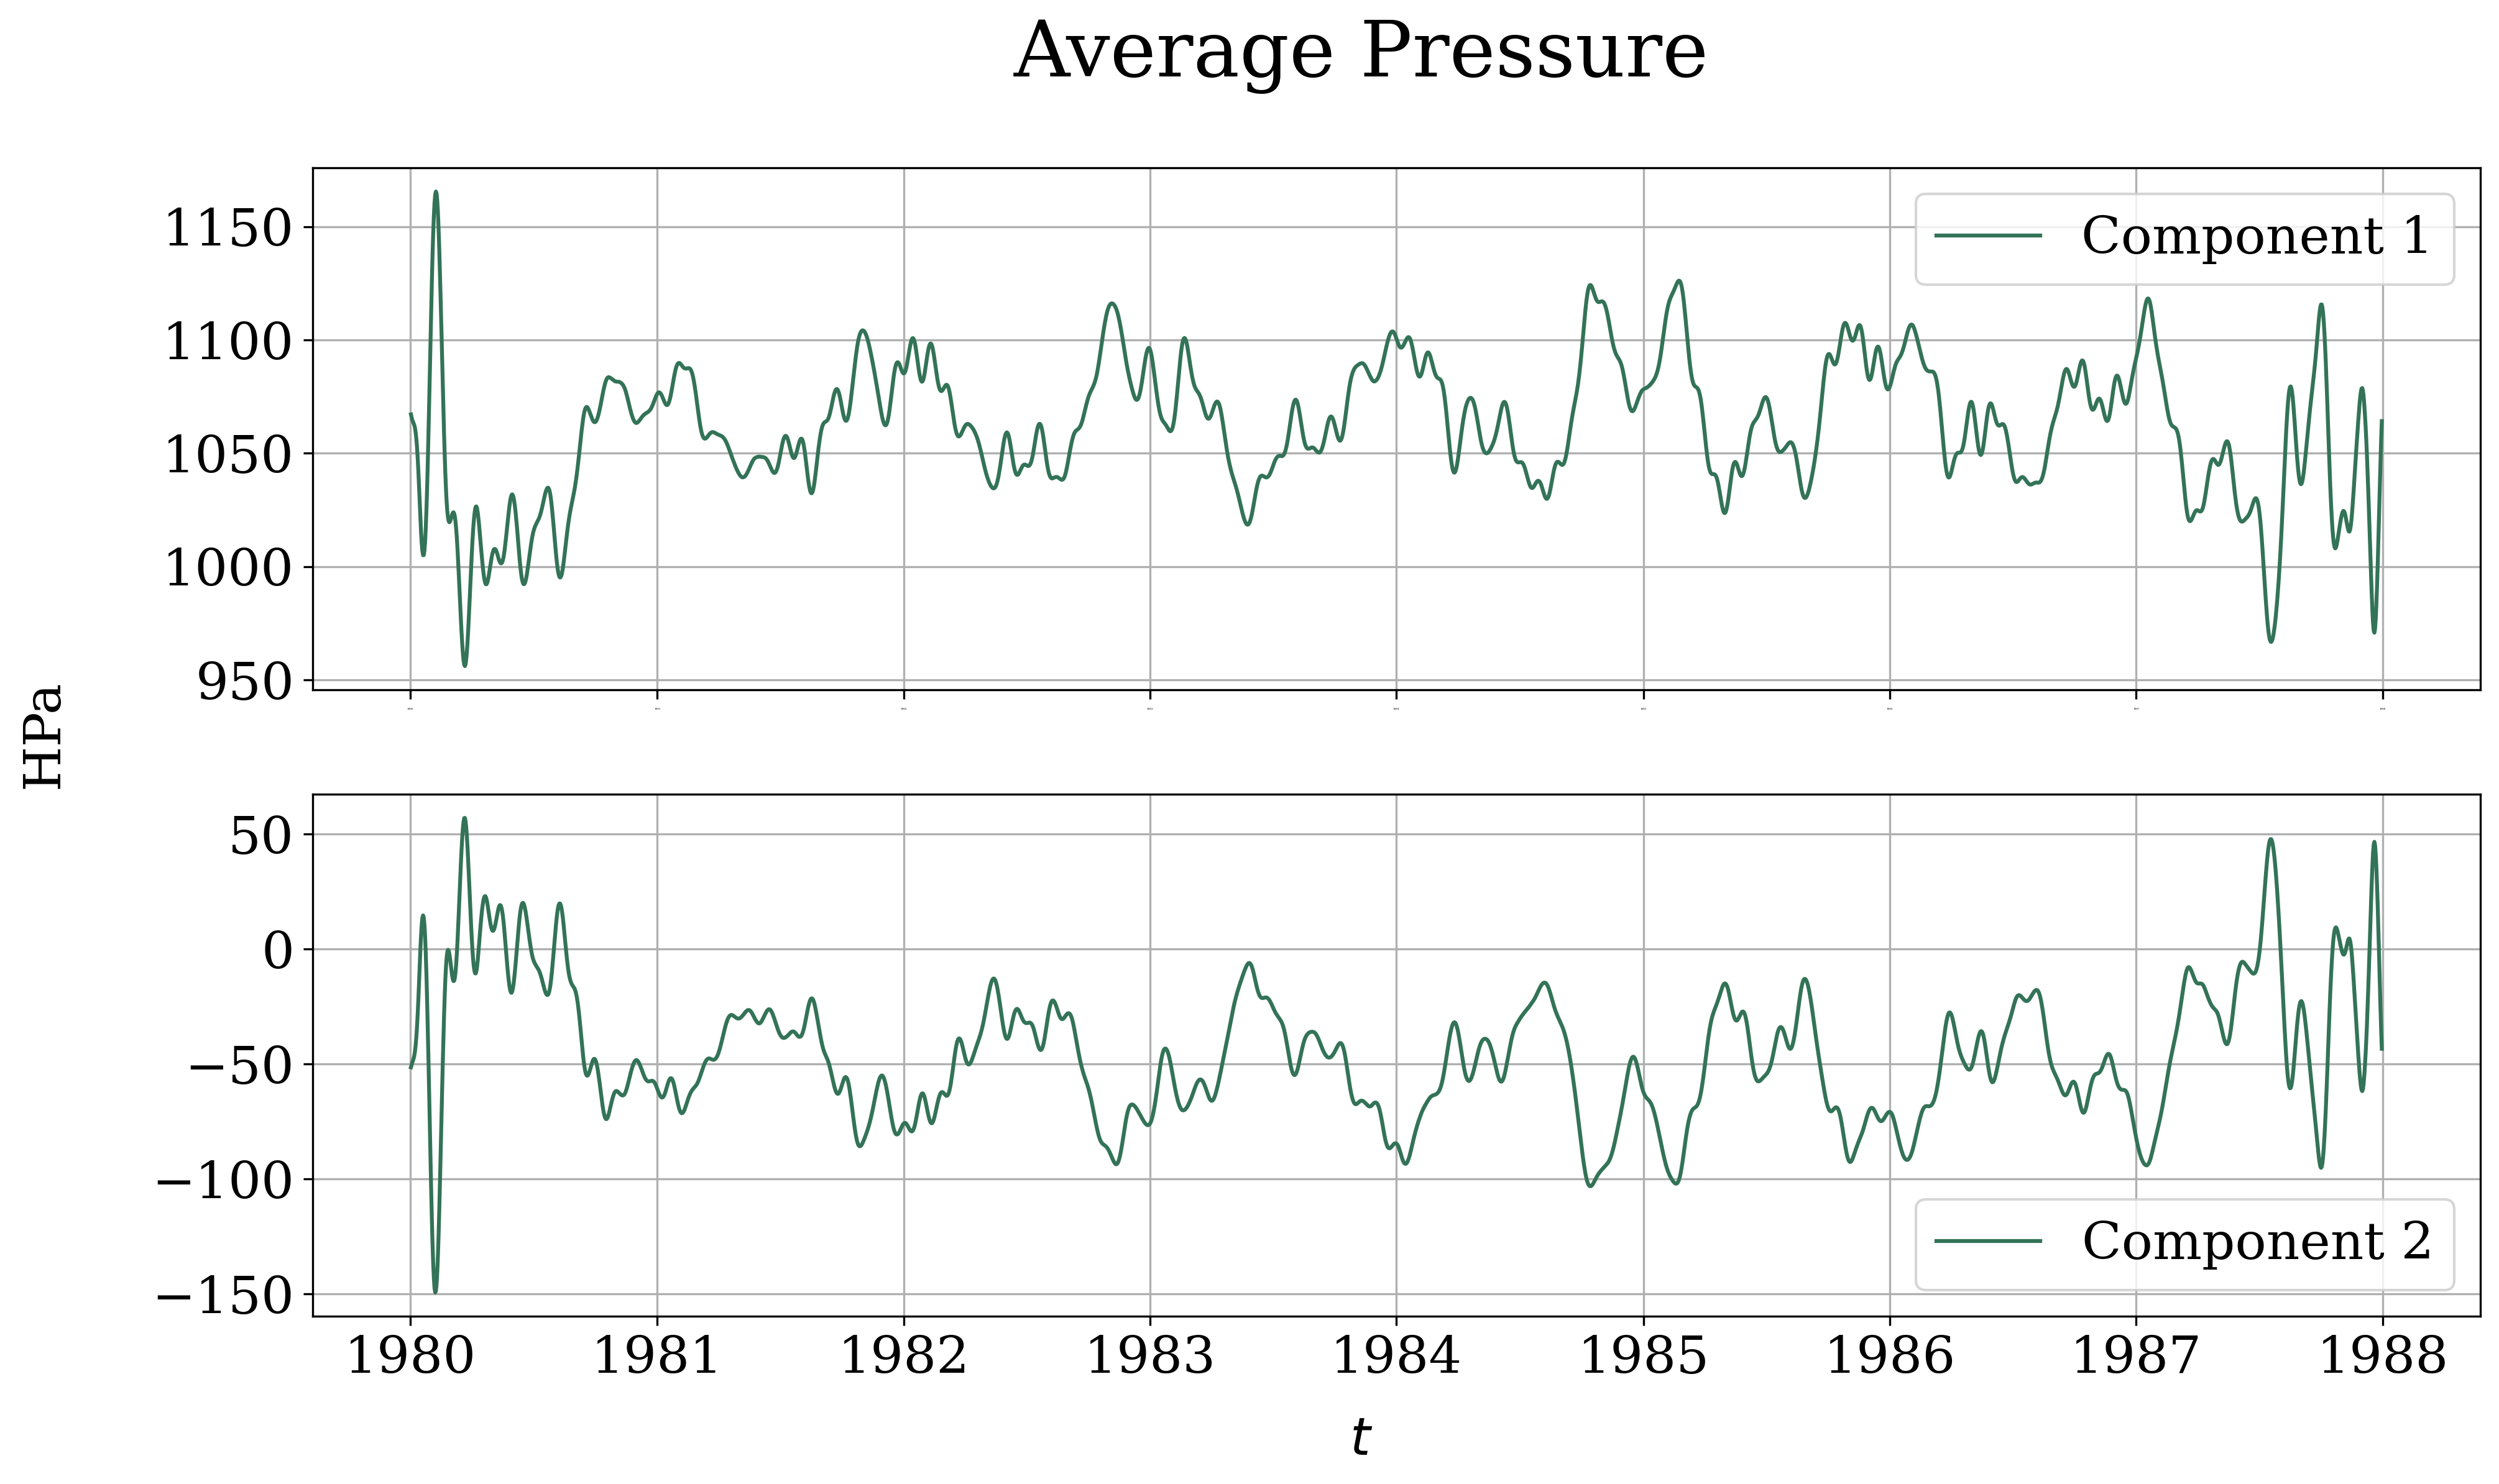

In [109]:
FitAndDescribe(overall_grouping)

## Dichotomy Decomposition

Utilizing dichotomy method

In [15]:
# make directory for figures
pathlib.Path(f'./figs/decomposition/cpd_rank_{cpd_rank}').mkdir(parents=True, exist_ok=True)

# make directory for groupings
pathlib.Path(f'./saved_grouping/cpd_rank_{cpd_rank}').mkdir(parents=True, exist_ok=True)

In [16]:
def FitAndDescribe(groups: list):
    """fit tssa object with grouping, print hankel residuals, plot signal's components

    Args:
        groups (list): 
    Returns: components figures
    """
    for i in range(train_data.shape[1]):
        t_ssa_obj.set_factors_grouping(groups[i], i)

    comp_sigs, hank_resid_abs, hank_resid_rel = t_ssa_obj.decompose_signals()

    # view relative hankerlization errors
    for i in range(train_data.shape[1]):
        print(f'Group for {sig_names[i]}: {groups[i]}')
        print(f'Rel hankel. errors for {sig_names[i]}\n{hank_resid_rel[i].tolist()}\nMean = {np.mean(hank_resid_rel[i])}\n')
        print(f'Abs hankel. errors for {sig_names[i]}\n{hank_resid_abs[i].tolist()}\nMean = {np.mean(hank_resid_abs[i])}\n')


    figs_container = []

    # plot results
    for i in range(train_data.shape[1]):
        with EnableJournalStylePlotting():
            fig, axs = plt.subplots(nrows=len(comp_sigs[i]), ncols=1, figsize=(15, 8))
            figs_container.append(fig)
    
            for j in range(len(comp_sigs[i])):
                axs[j].plot(time_grid_train, comp_sigs[i][j], label=f'Component {j + 1}', color=color_list[i])
    
                if j != len(comp_sigs[i]) - 1:
                    axs[j].tick_params(axis='x', labelsize=0)
    
                axs[j].grid(True)
                axs[j].legend()
    
            fig.supylabel(f'{sig_units[i]}', fontsize=20)
            fig.supxlabel('$t$', fontsize=20)
            fig.suptitle(f'{sig_names[i]}', fontsize=30)
    
    return figs_container

### Use precomputed groupings

In [17]:
# enter existing group id or leave it None
existing_group_id = None

if pathlib.Path(f'./saved_grouping/cpd_rank_{cpd_rank}/grouping_{existing_group_id}.pkl').exists():
    with open(f'./saved_grouping/cpd_rank_{cpd_rank}/grouping_{existing_group_id}.pkl', 'rb') as f:
        dichy_groups = pickle.load(f)

    # use grouping and obtain decomposition results
    component_figs = FitAndDescribe(dichy_groups)
    # may safe
    ...
else:
    print('No saved grouping')

No saved grouping


### Disect existing grouping or build new

In [22]:
# flag controlling execution of this section
want_to_disect = True

In [23]:
# creating grouping generator
if want_to_disect:
    # enter group id to further disect or None
    existing_group_id = 1

    # load initial grouping
    if pathlib.Path(f'./saved_grouping/cpd_rank_{cpd_rank}/grouping_{existing_group_id}.pkl').exists():
        with open(f'./saved_grouping/cpd_rank_{cpd_rank}/grouping_{existing_group_id}.pkl', 'rb') as f:
            init_dichy_groups = pickle.load(f)
    # go from the start
    else:
        init_dichy_groups = None

    # create grouping generator
    DichPartitionGenerator = NextDichotomyPartition(t_ssa_obj, init_dichy_groups)

In [24]:
# initialzing generator
if want_to_disect:
    # case: we build grouping from the start
    if init_dichy_groups is None:
        dichy_groups, dichy_hankel_resids = next(DichPartitionGenerator)

        # save generated grouping
        with open(f'./saved_grouping/cpd_rank_{cpd_rank}/grouping_1.pkl', 'wb') as f:
            pickle.dump(dichy_groups, f)

        # use our grouping and obtain decomposition results
        component_figs = FitAndDescribe(dichy_groups)

        # make directory for figures (grouping on two always have index 1)
        pathlib.Path(f'./figs/decomposition/cpd_rank_{cpd_rank}/grouping_1').mkdir(parents=True, exist_ok=True)

        # save figures
        for i in range(len(component_figs)):
            component_figs[i].savefig(
                f'./figs/decomposition/cpd_rank_{cpd_rank}/grouping_1/{sig_names[i].replace(" ", "_")}.eps',
                format='eps'
            )
    else:
        # we just initialize our generator
        next(DichPartitionGenerator)

Group for Average Temperature: [[0], [1, 2, 4, 5, 6, 8], [3, 7, 9]]
Rel hankel. errors for Average Temperature
[0.7297776149639017, 0.975672602475615, 0.9368276654837603]
Mean = 0.880759294307759

Abs hankel. errors for Average Temperature
[369290.1875, 772993.9375, 935185.875]
Mean = 692490.0

Group for Precipitation: [[0], [1, 2, 4, 5, 6, 8], [3, 7, 9]]
Rel hankel. errors for Precipitation
[0.7297775265400178, 0.9607414614815867, 0.9331636867268238]
Mean = 0.8745608915828095

Abs hankel. errors for Precipitation
[7384.11279296875, 8116.16748046875, 10772.4306640625]
Mean = 8757.5703125

Group for Average Pressure: [[0, 2, 3, 4, 5, 6, 7, 9], [8], [1]]
Rel hankel. errors for Average Pressure
[0.05725570502275675, 0.9735767544565013, 0.9861106029338974]
Mean = 0.6723143541377185

Abs hankel. errors for Average Pressure
[63951.6953125, 67867.90625, 17739.357421875]
Mean = 49852.986328125



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


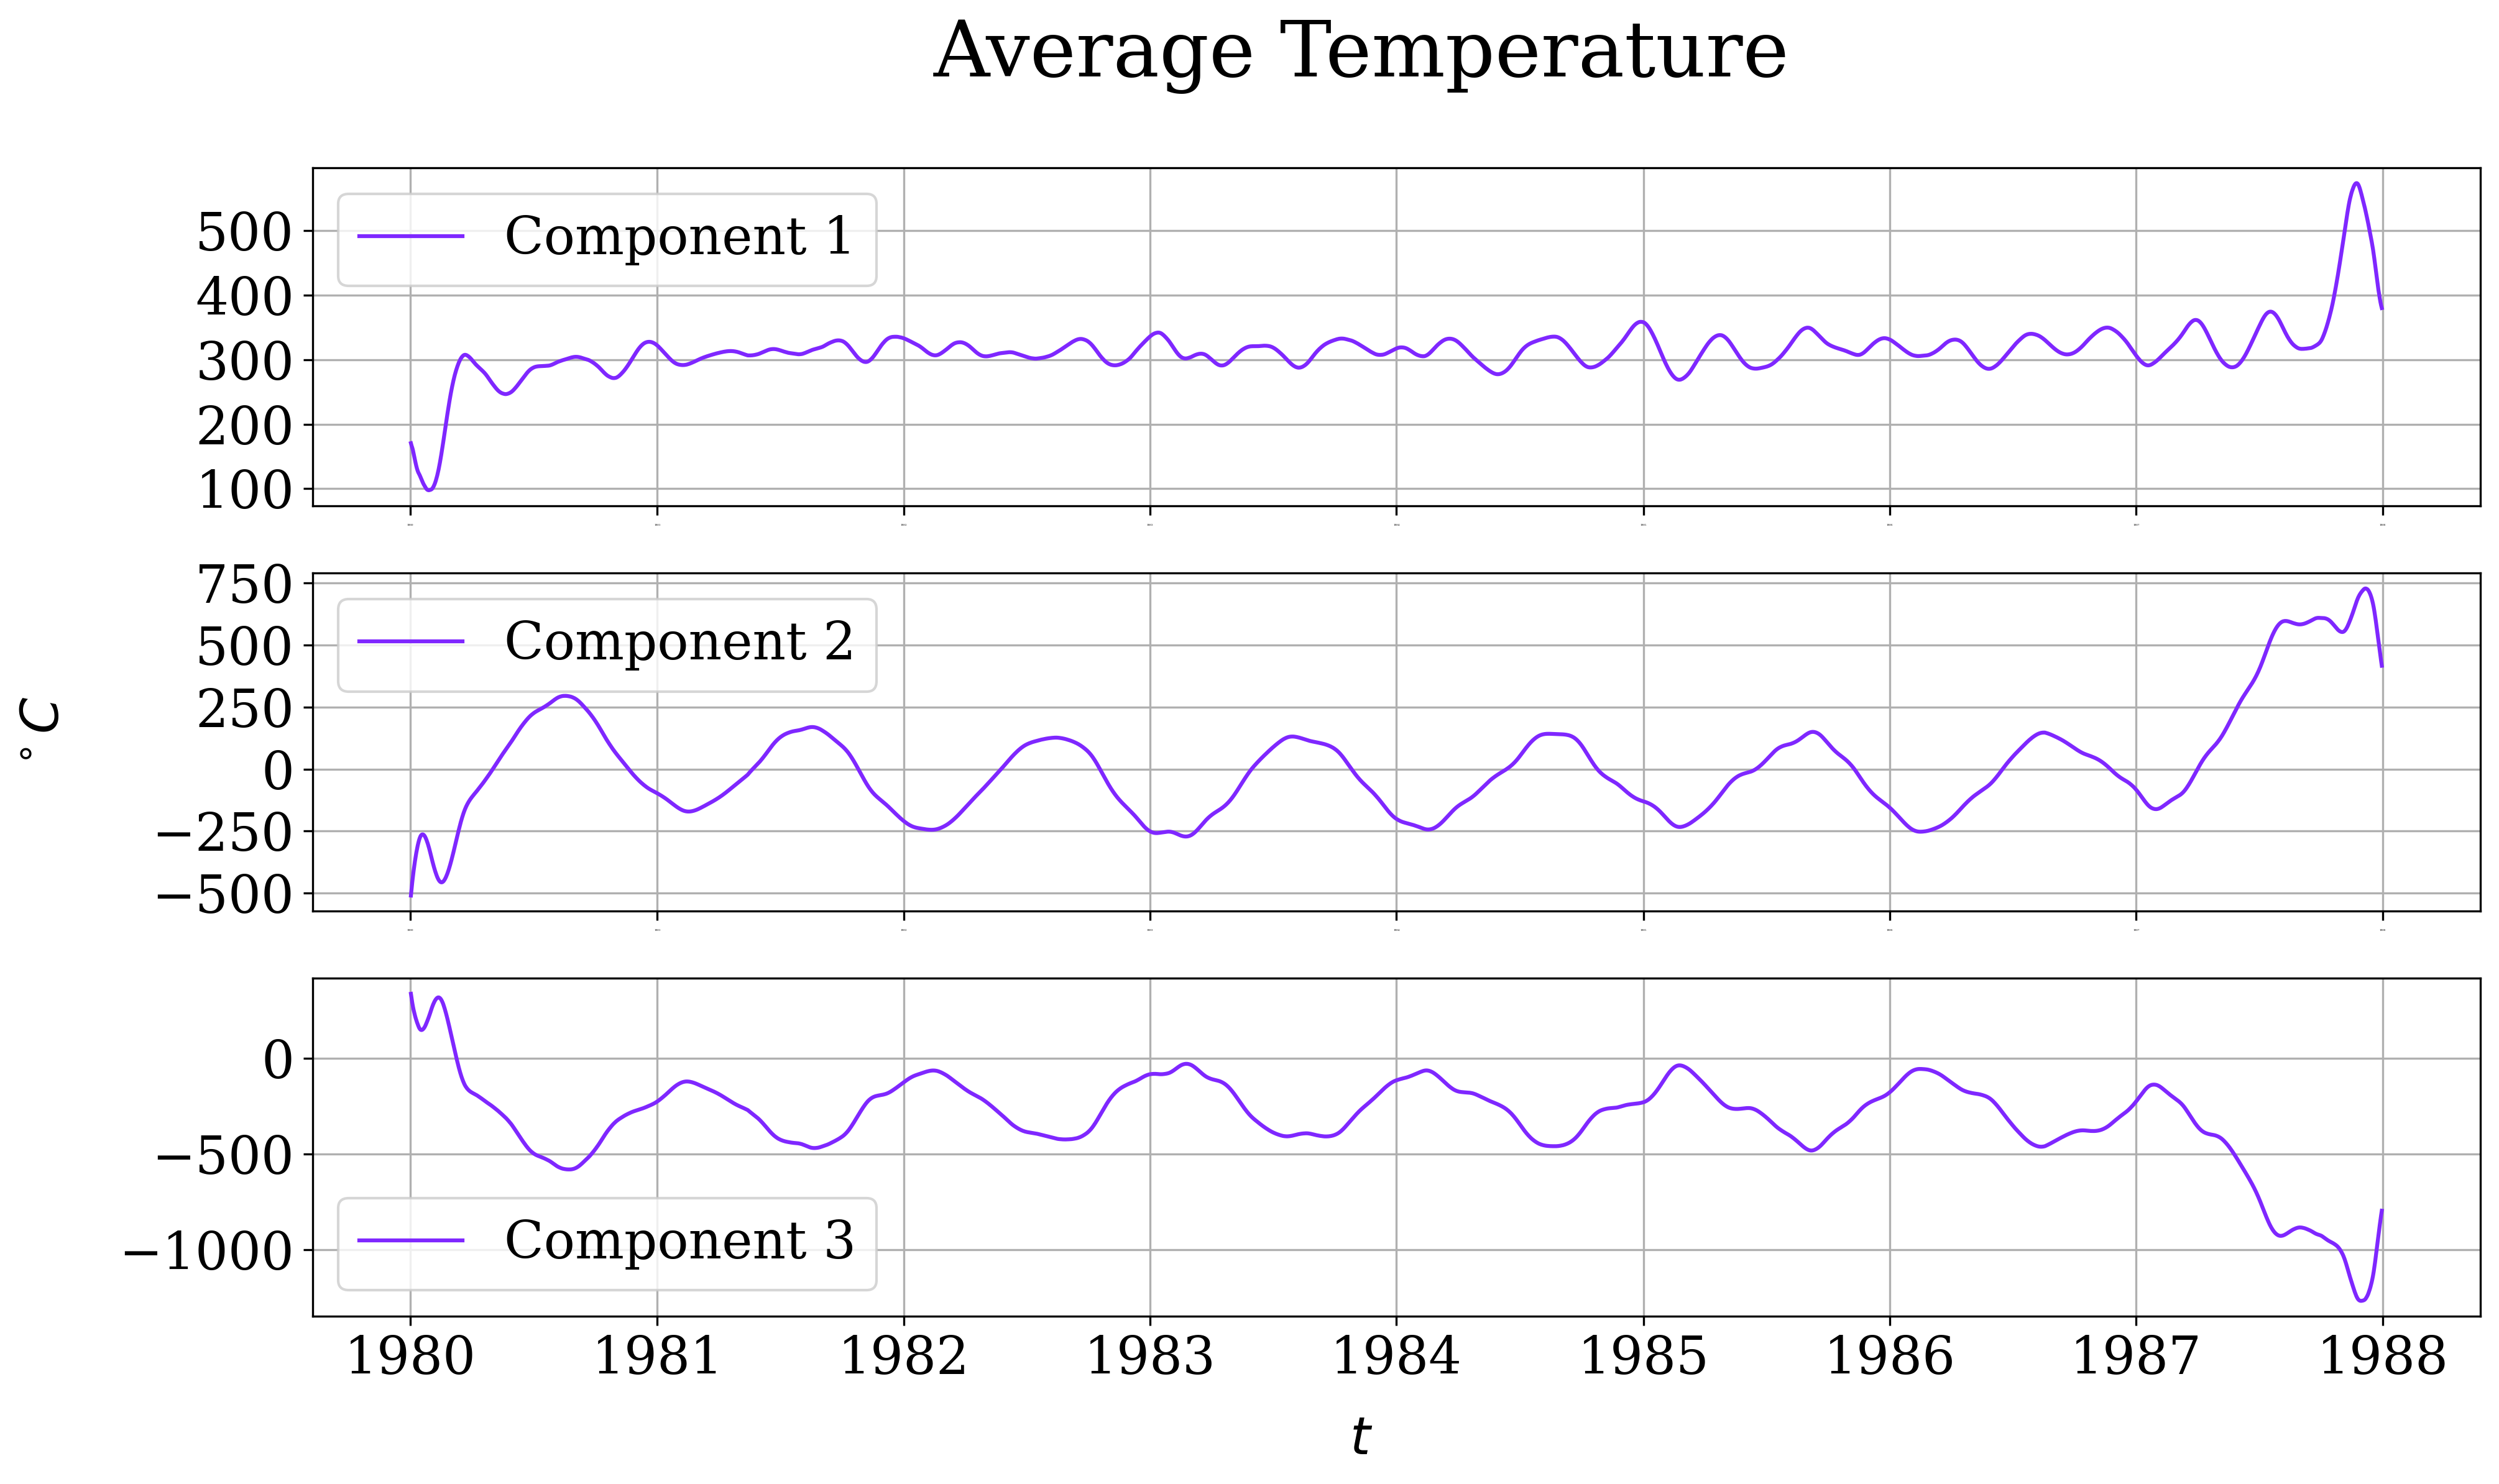

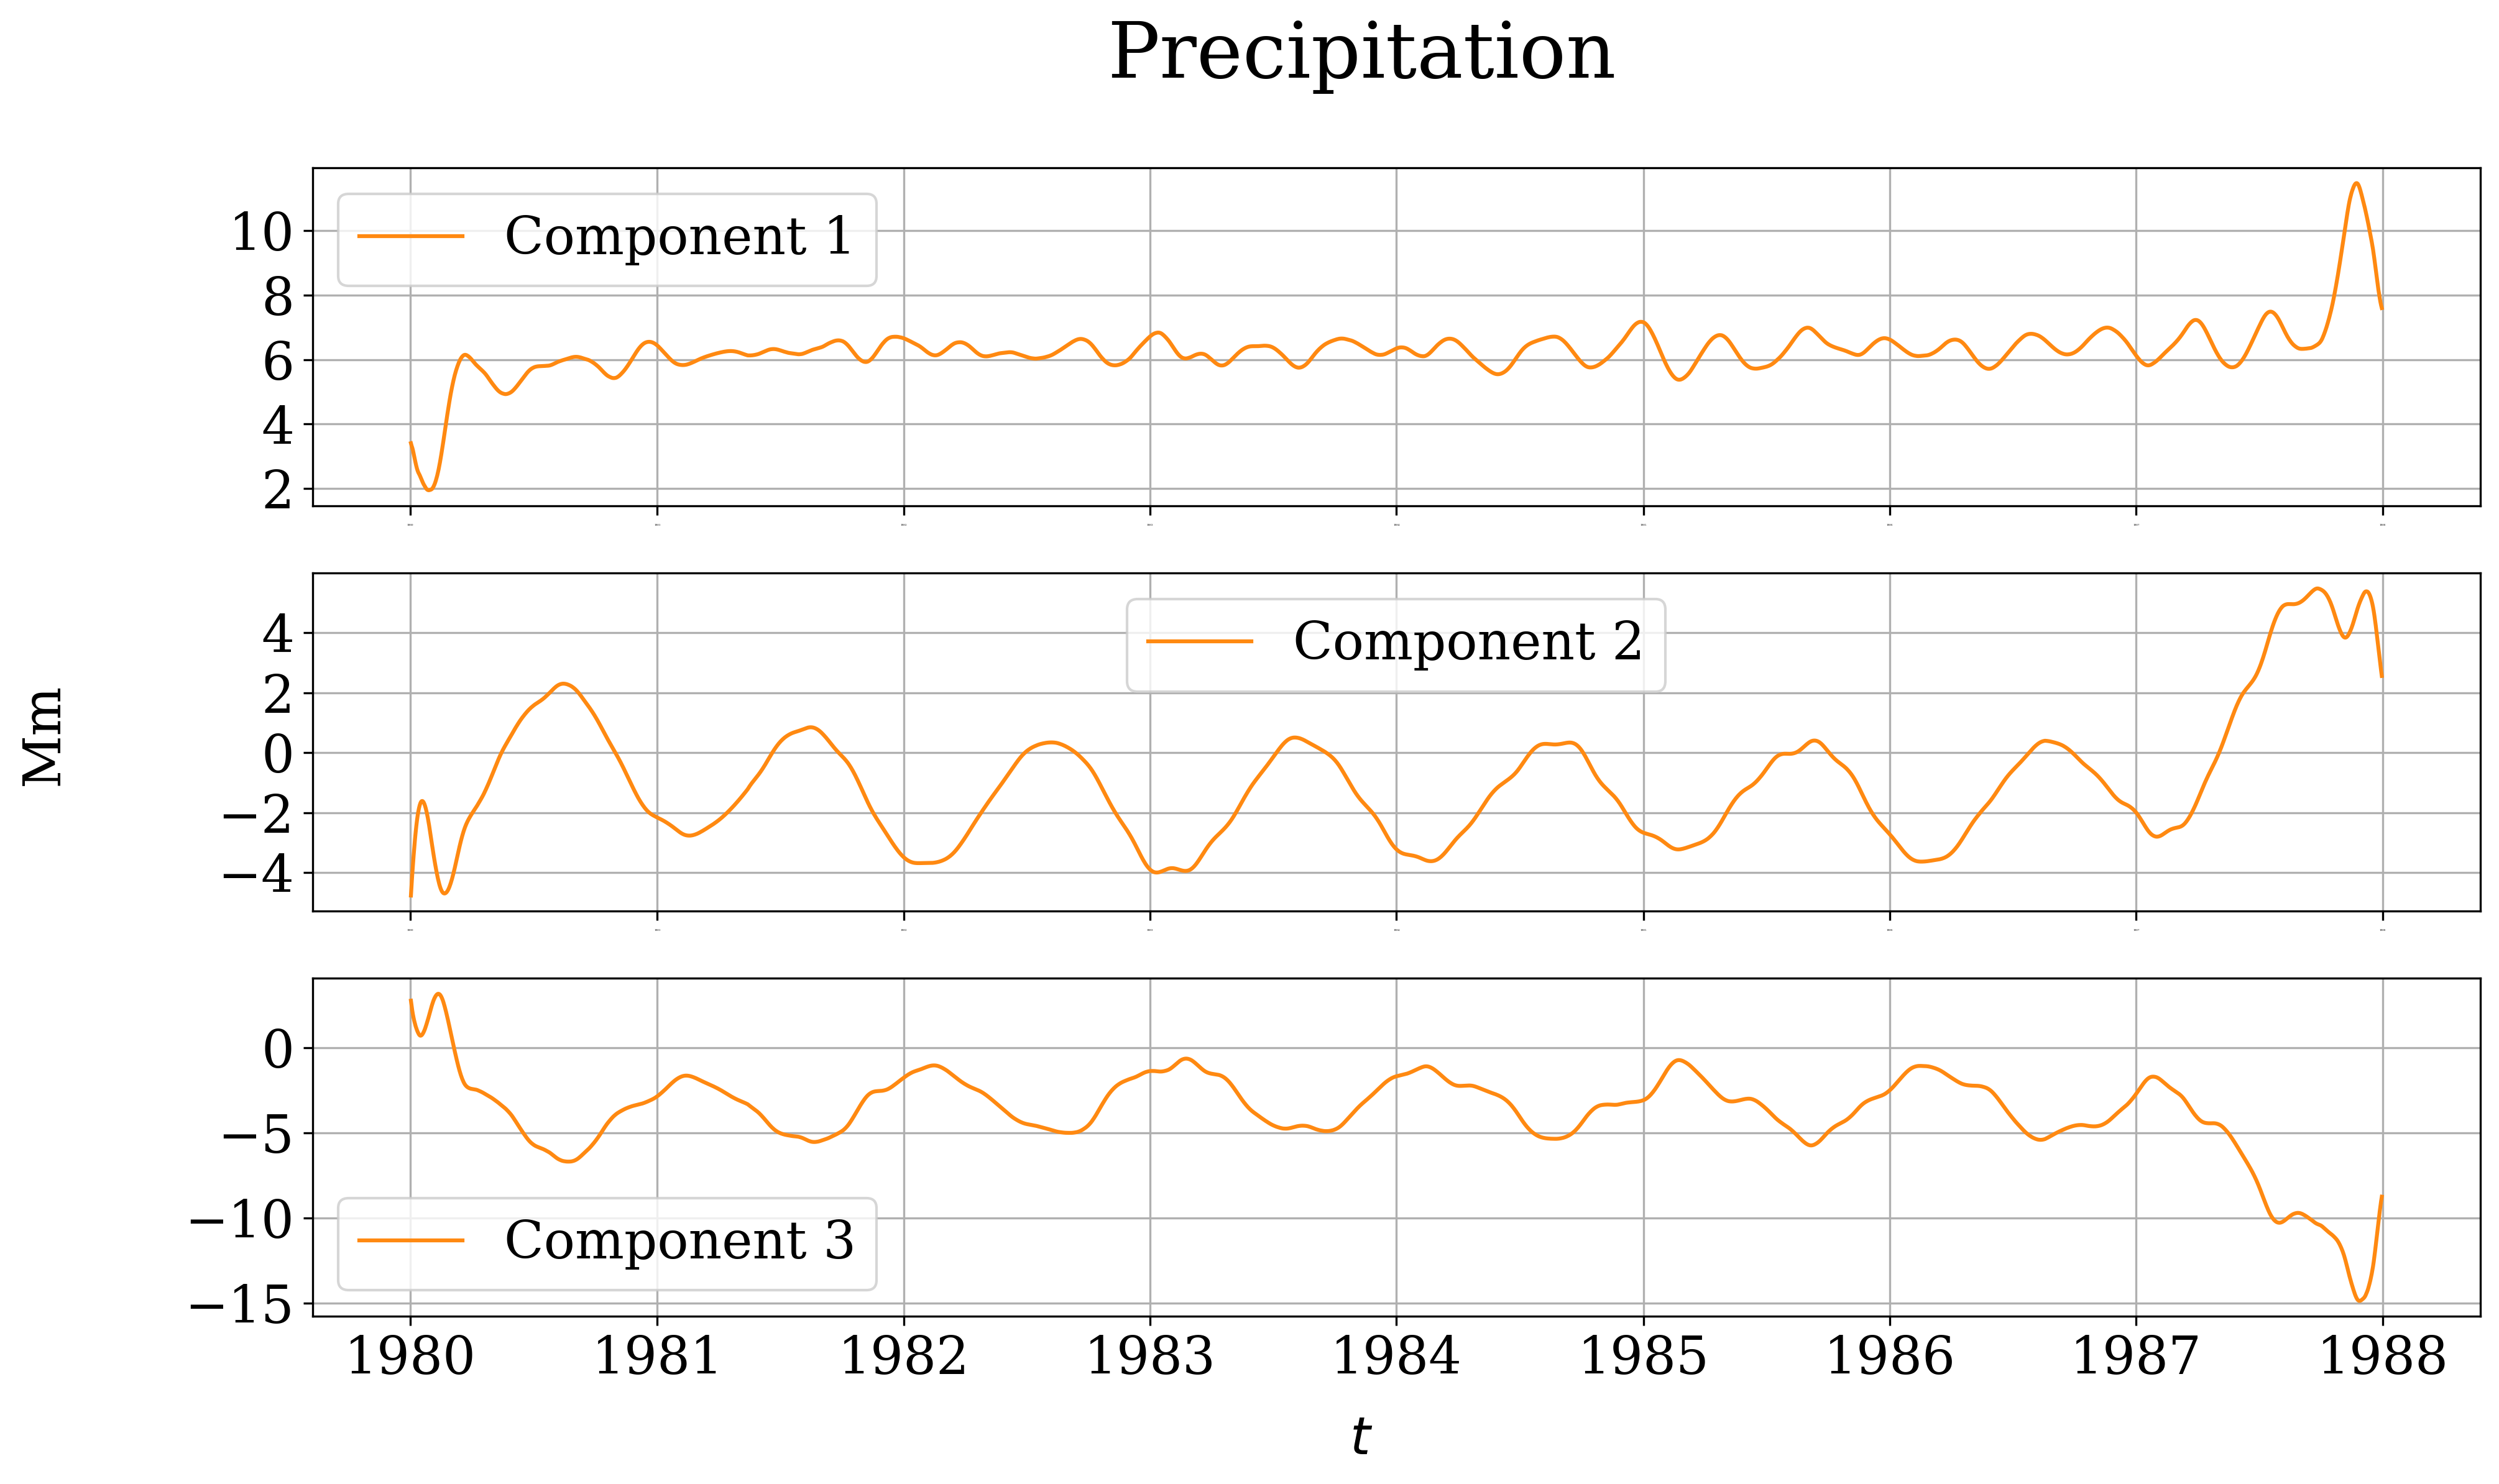

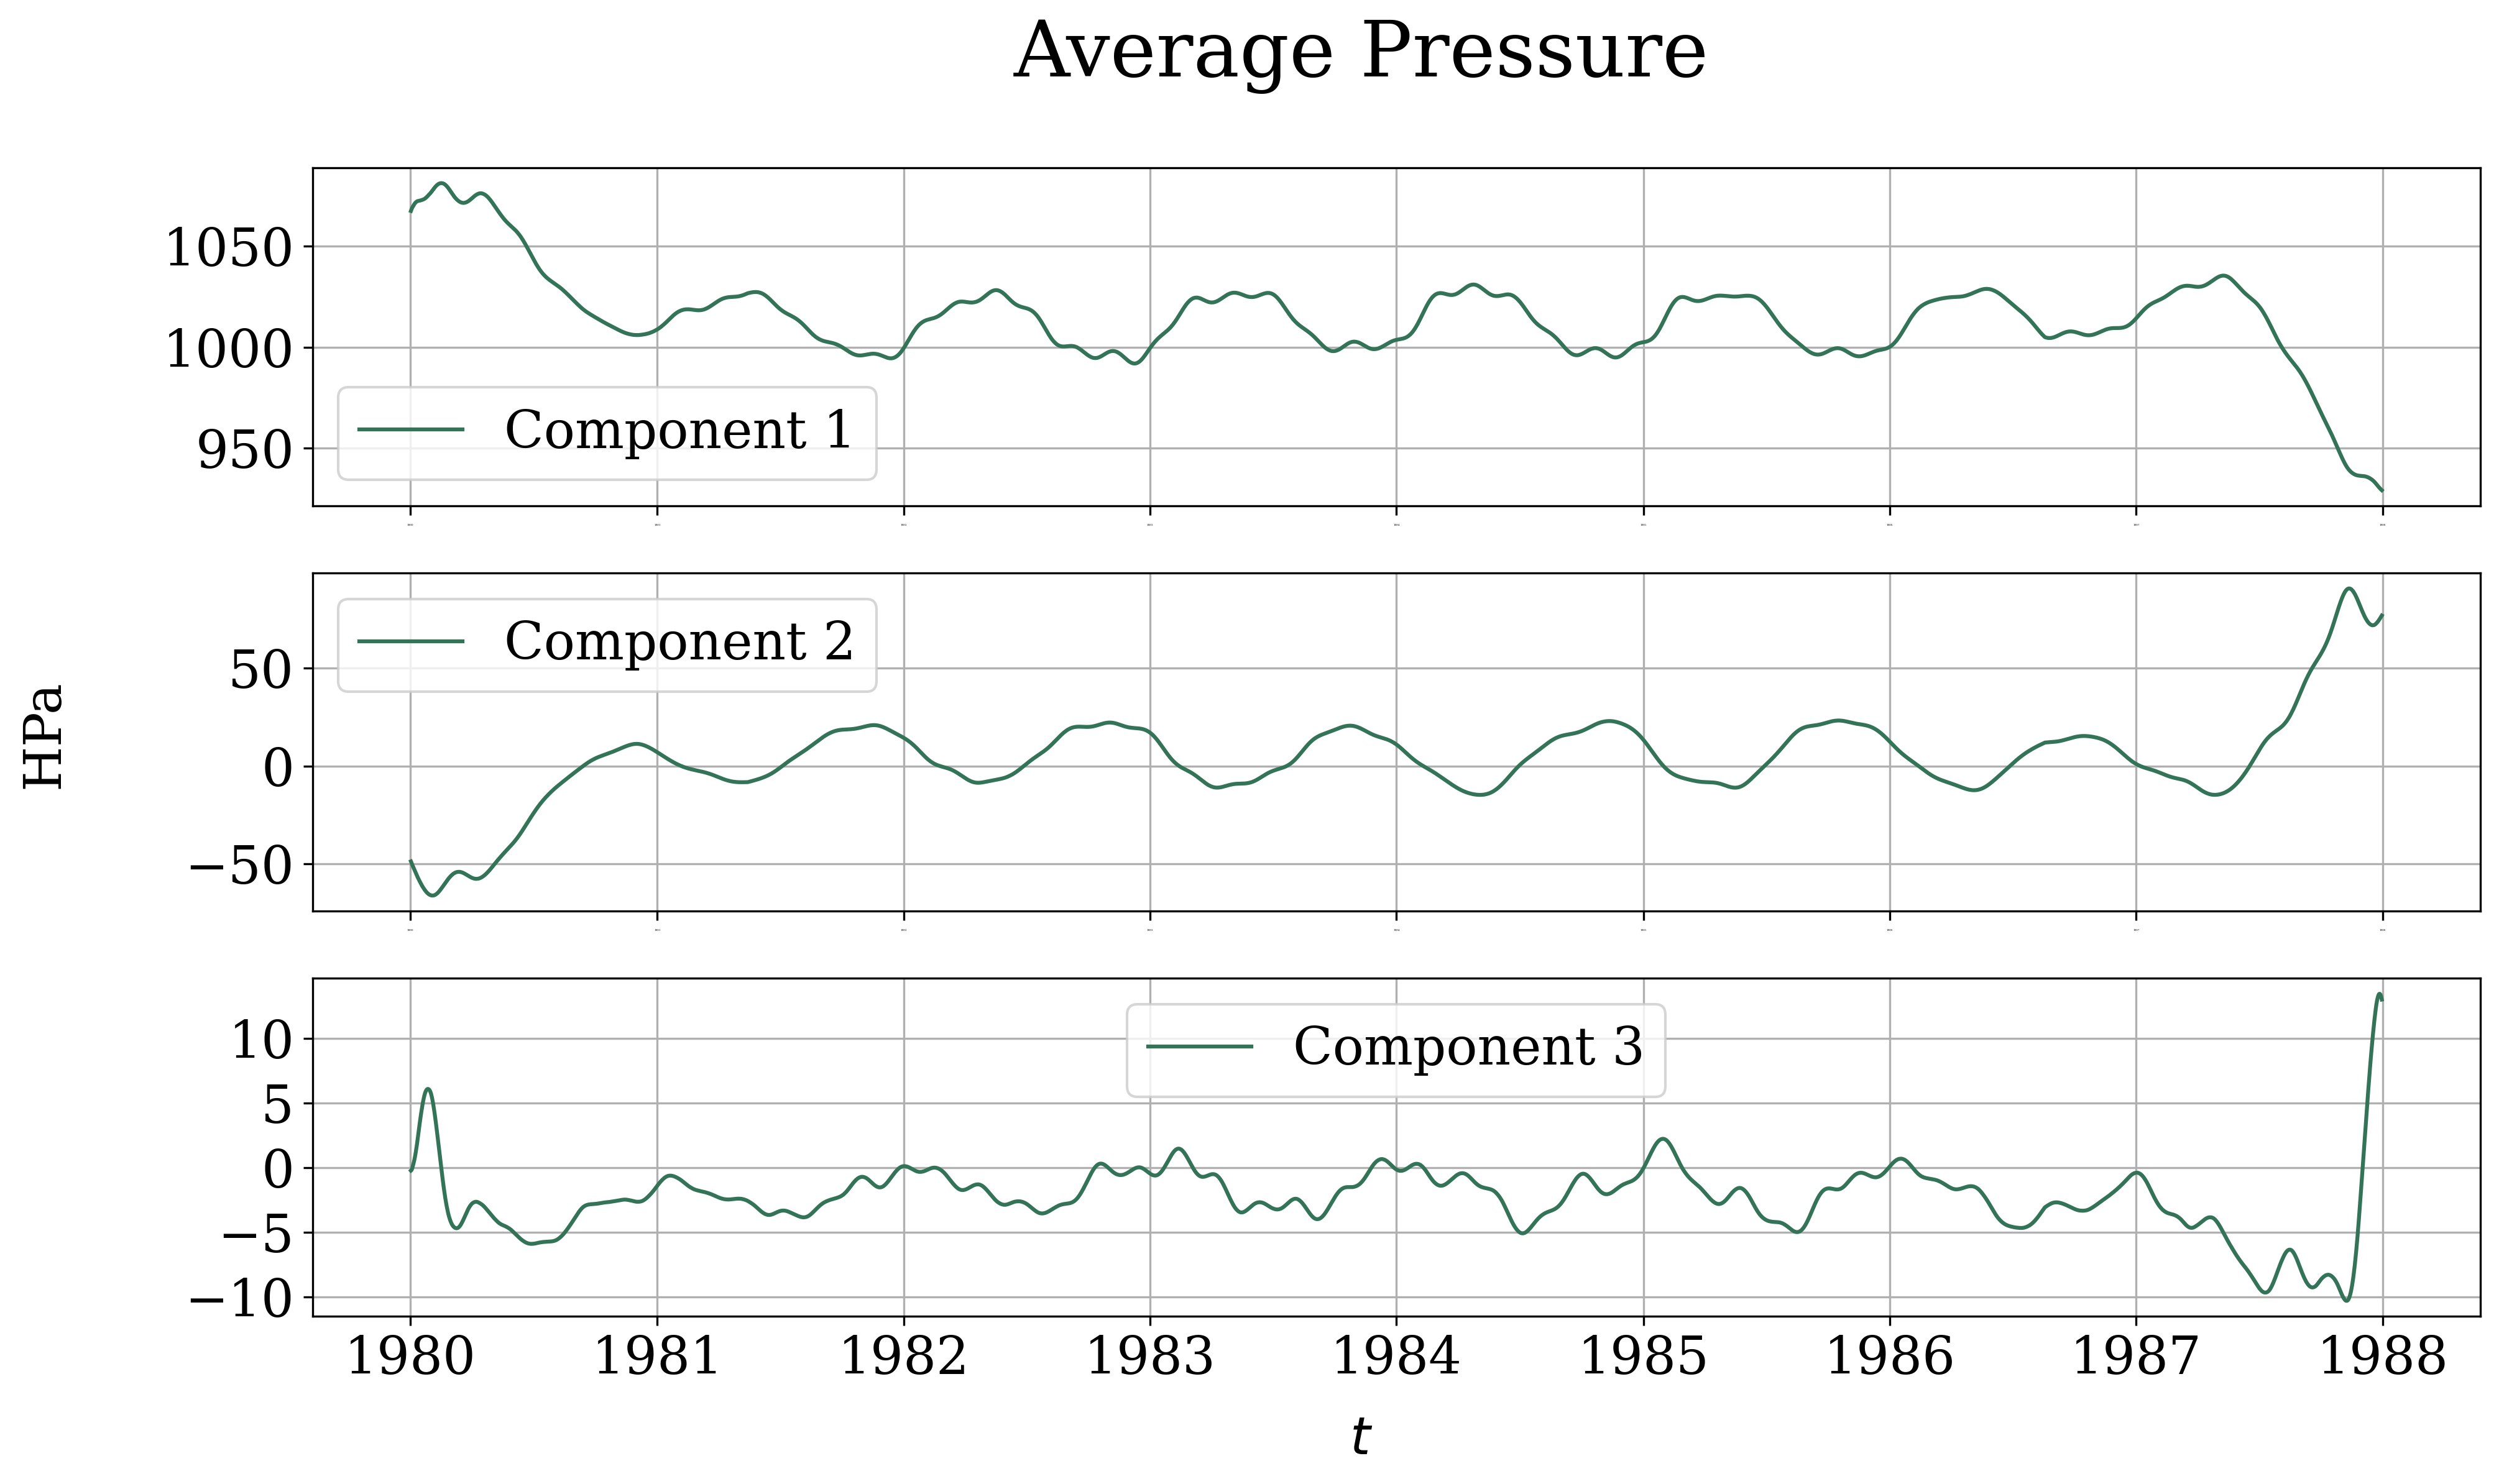

In [25]:
# use generator
if want_to_disect:
    # execute this cell as many times as needed changing 'groups_to_disect'
    # this is the list of groups to futher disect for each signal
    
    # disect chosen groups into two more
    groups_to_disect = [[1], [1], [0]]
    # enter unique grouping id (not 1)
    grouping_id = 2
    
    if (groups_to_disect is not None) and (grouping_id is not None):
        dichy_groups, dichy_hankel_resids = DichPartitionGenerator.send(groups_to_disect)

        # save generated grouping
        with open(f'./saved_grouping/cpd_rank_{cpd_rank}/grouping_{grouping_id}.pkl', 'wb') as f:
            pickle.dump(dichy_groups, f)
    
        component_figs = FitAndDescribe(dichy_groups)

        # make directory for figures (grouping on two always have index 1)
        pathlib.Path(f'./figs/decomposition/cpd_rank_{cpd_rank}/grouping_{grouping_id}').mkdir(parents=True, exist_ok=True)

        # save figures
        for i in range(len(component_figs)):
            component_figs[i].savefig(
                f'./figs/decomposition/cpd_rank_{cpd_rank}/grouping_{grouping_id}/{sig_names[i].replace(" ", "_")}.eps',
                format='eps'
            )

## Prediction

In [53]:
# make directory for figures
pathlib.Path(f'./figs/prediction/cpd_rank_{cp_rank}').mkdir(parents=True, exist_ok=True)

In [54]:
t_ssa_obj.remove_last_predictions()

# get prediction for cuurent number of factors left
forecast_tssa = np.empty(test_data.shape)

for i in range(test_data.shape[0]):
    forecast_tssa[i] = np.array(t_ssa_obj.predict_next())

# get MSE for every signal
signals_mse_tssa = np.mean((forecast_tssa - test_data) ** 2, axis=0)
# get MAPE for every signal
signals_mape_tssa = np.empty(num_signals)

for i in range(num_signals):
    non_zero_entries = (test_data[i] != 0)

    cur_mape = np.mean(
        np.abs((forecast_tssa[i][non_zero_entries] - test_data[i][non_zero_entries]) / test_data[i][non_zero_entries]), 
        axis=0
    )
    signals_mape_tssa[i] = cur_mape

print(f'MSE: {signals_mse_tssa}; Mean by signals = {np.mean(signals_mse_tssa):e}')
print(f'MAPE: {signals_mape_tssa}; Mean by signals = {np.mean(signals_mape_tssa)}')

MSE: [8089.05827346  705.83568667 7791.86040393]; Mean by signals = 5.528918e+03
MAPE: [0.46102668 2.06509425 0.83428369]; Mean by signals = 1.1201348727443217


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


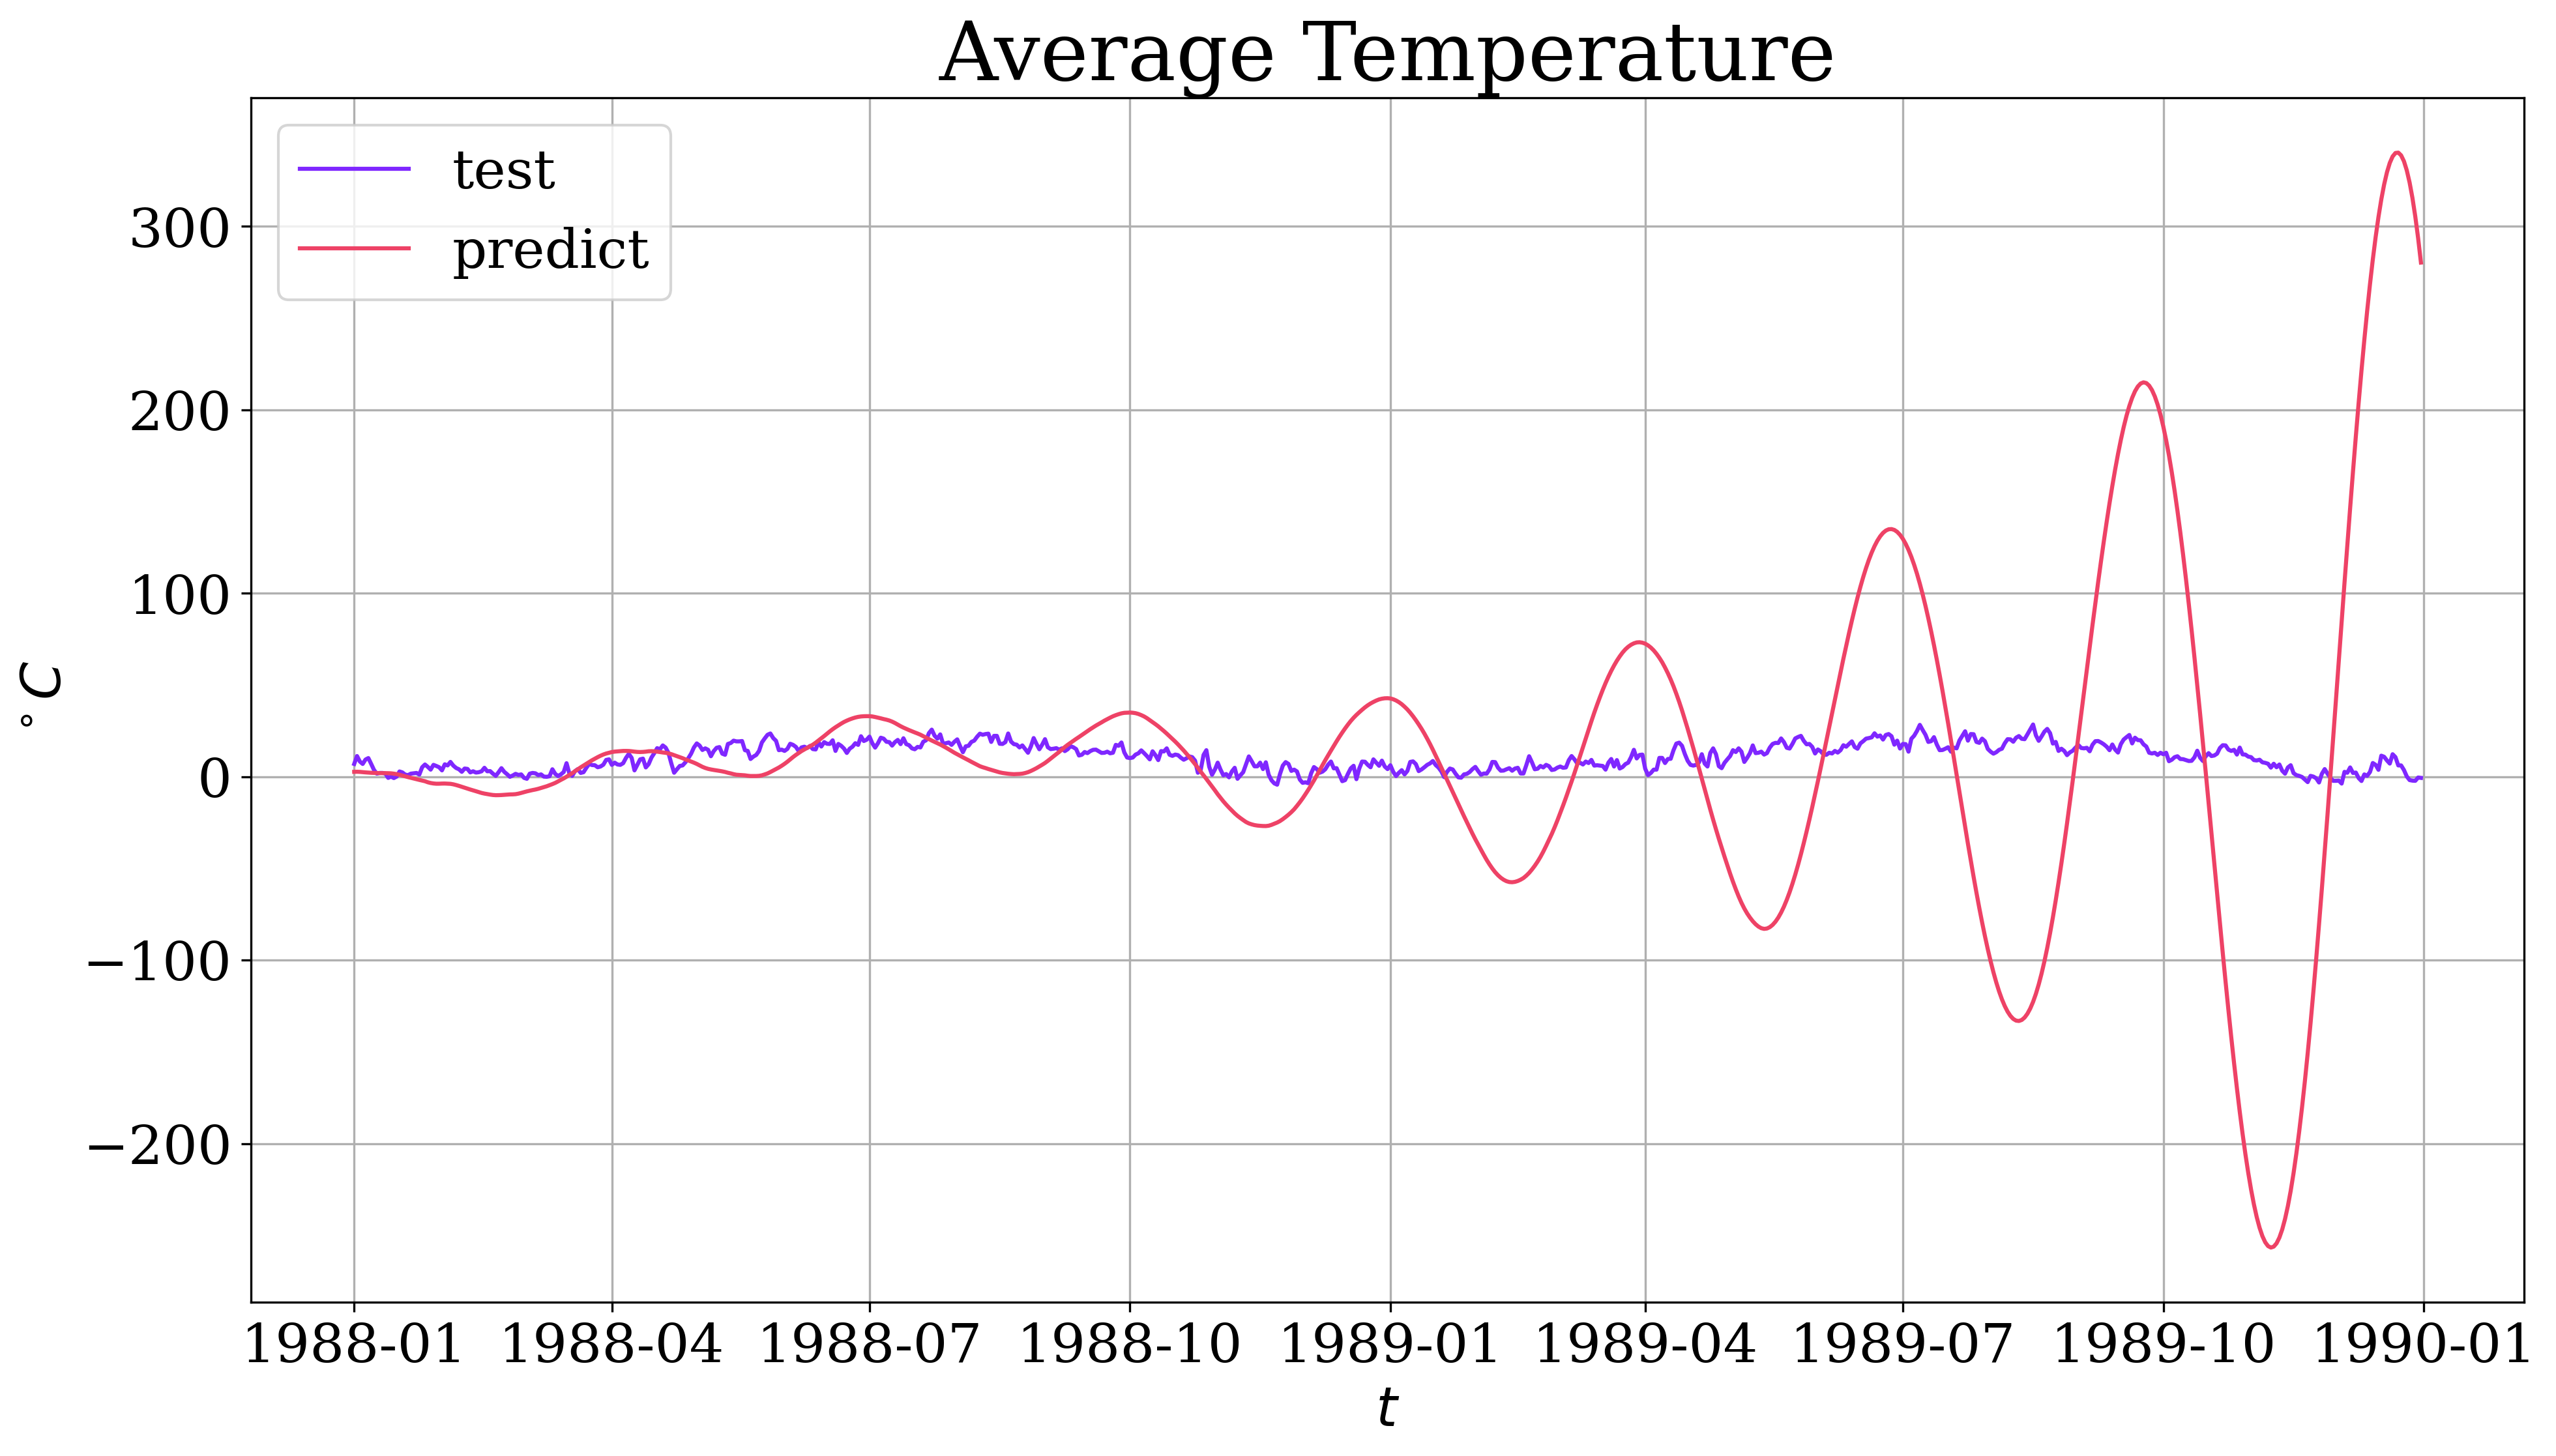

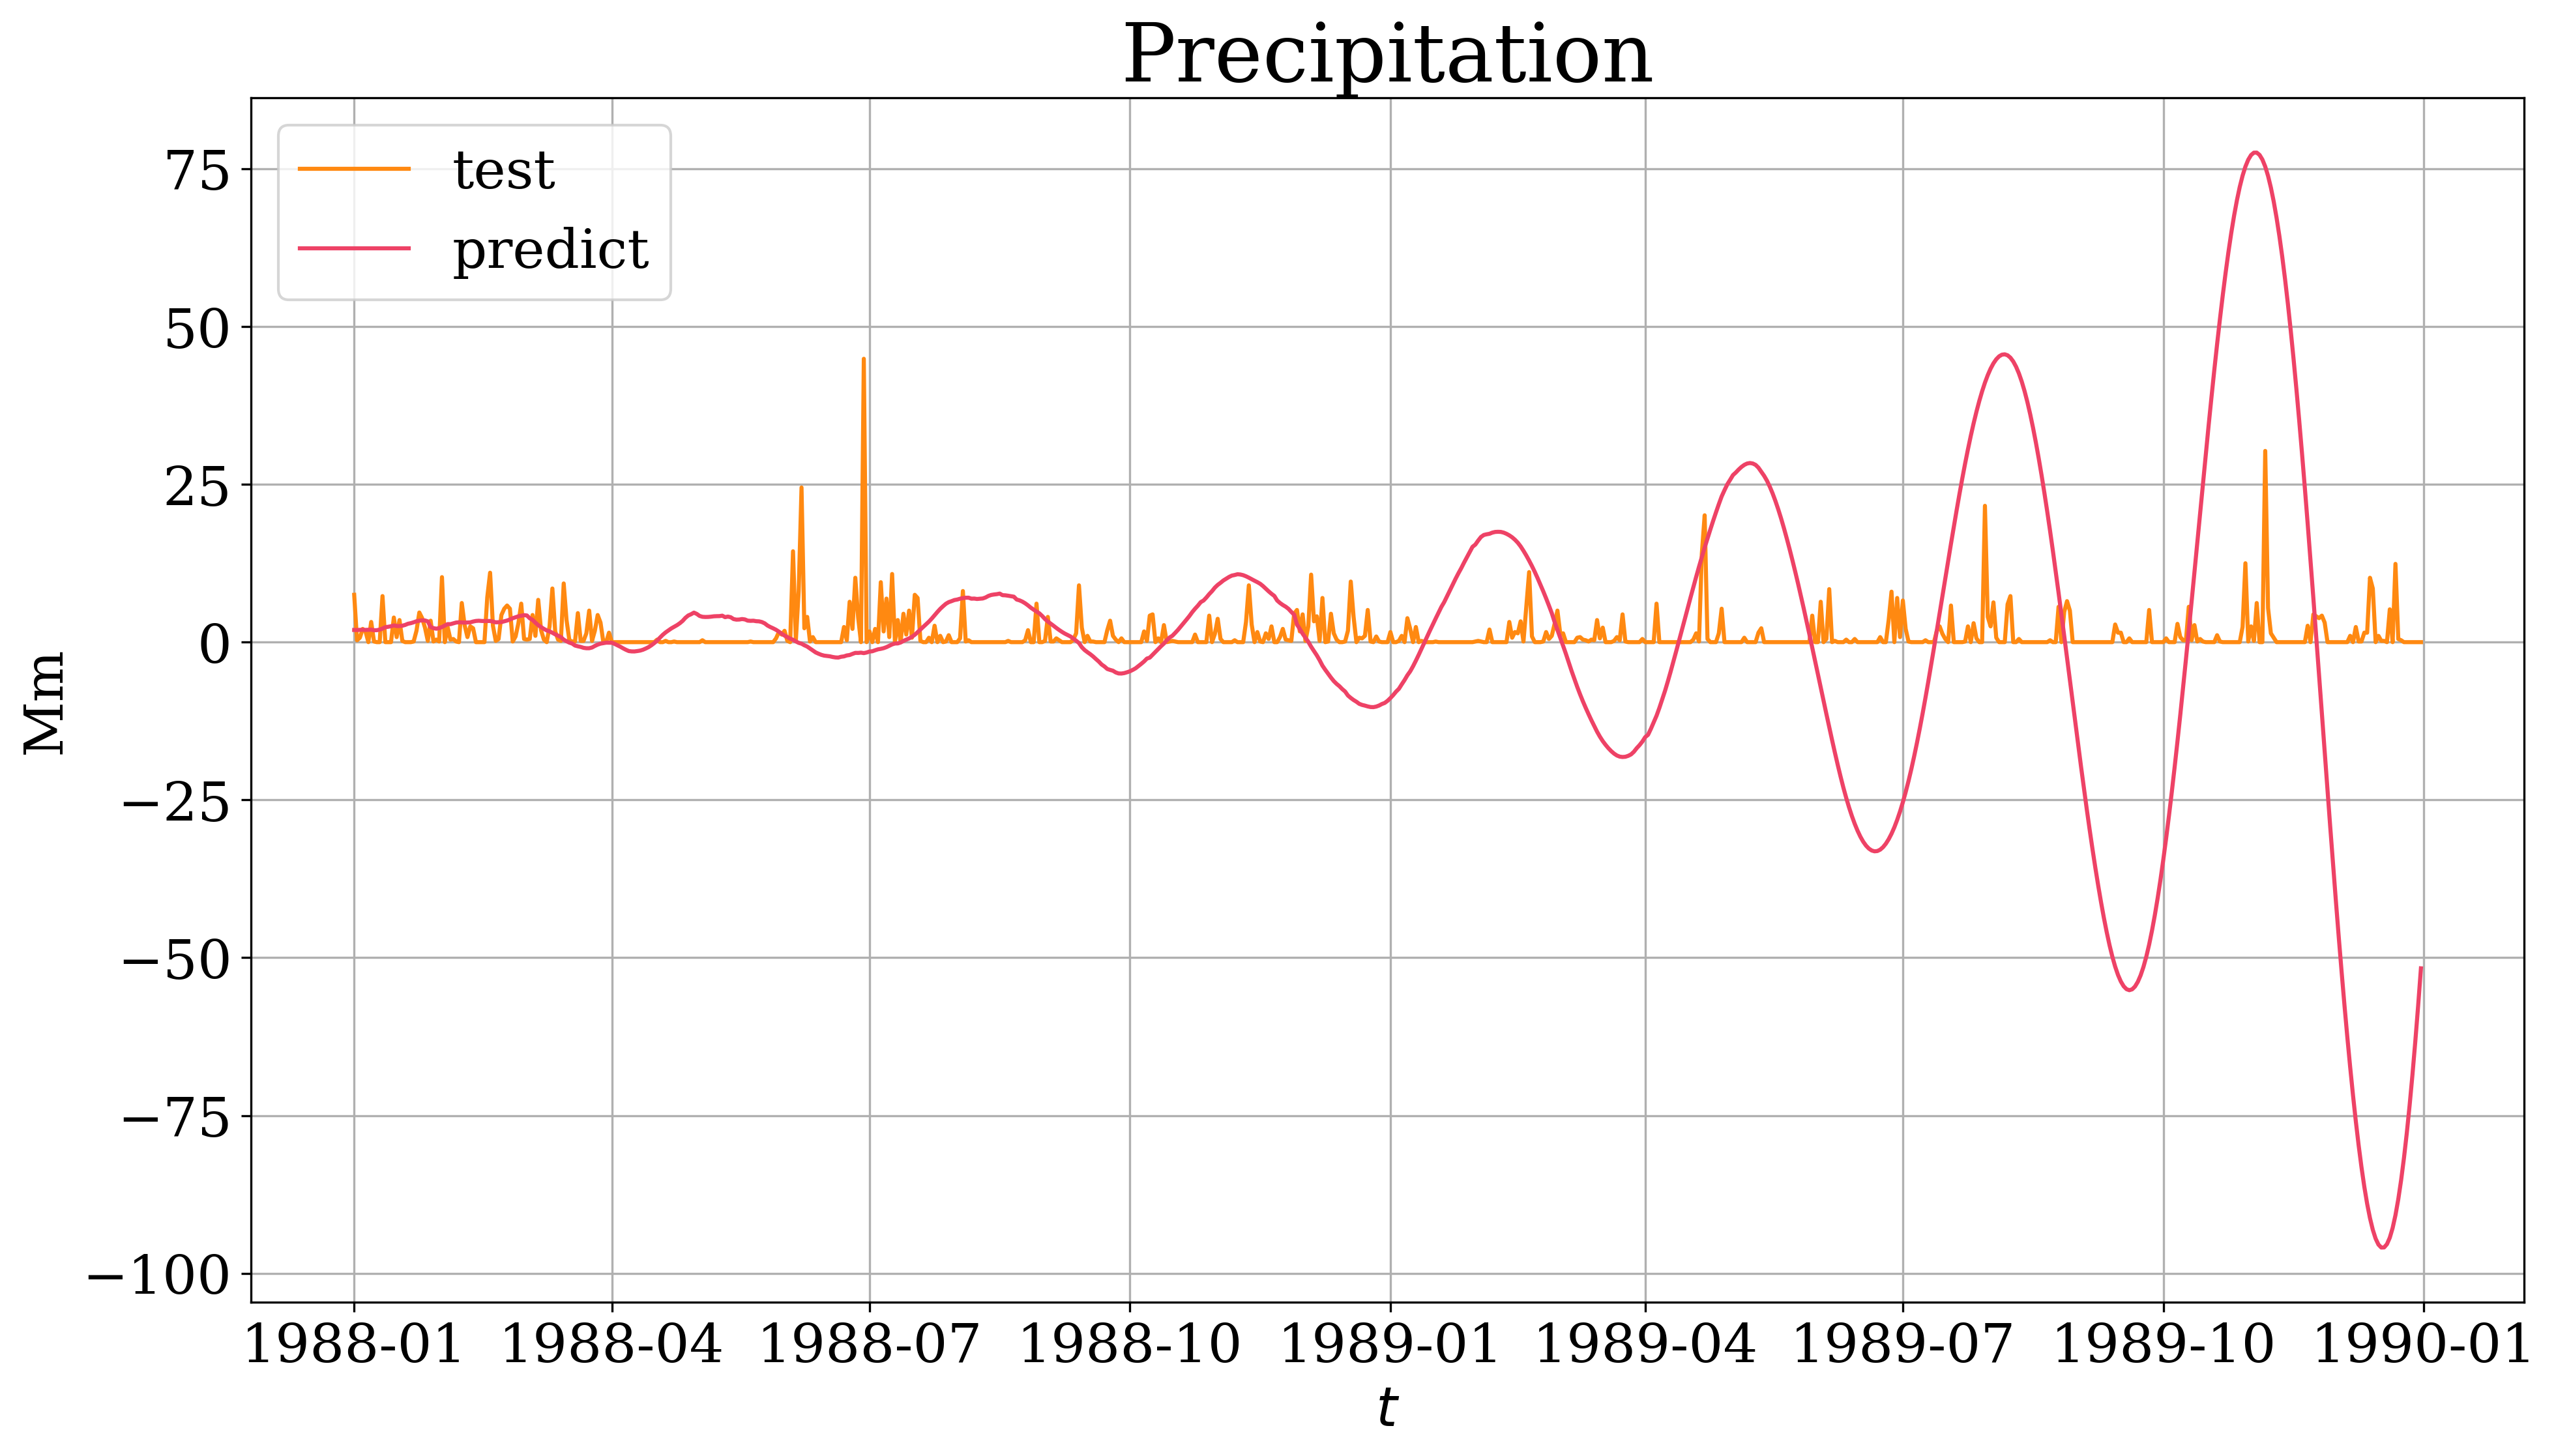

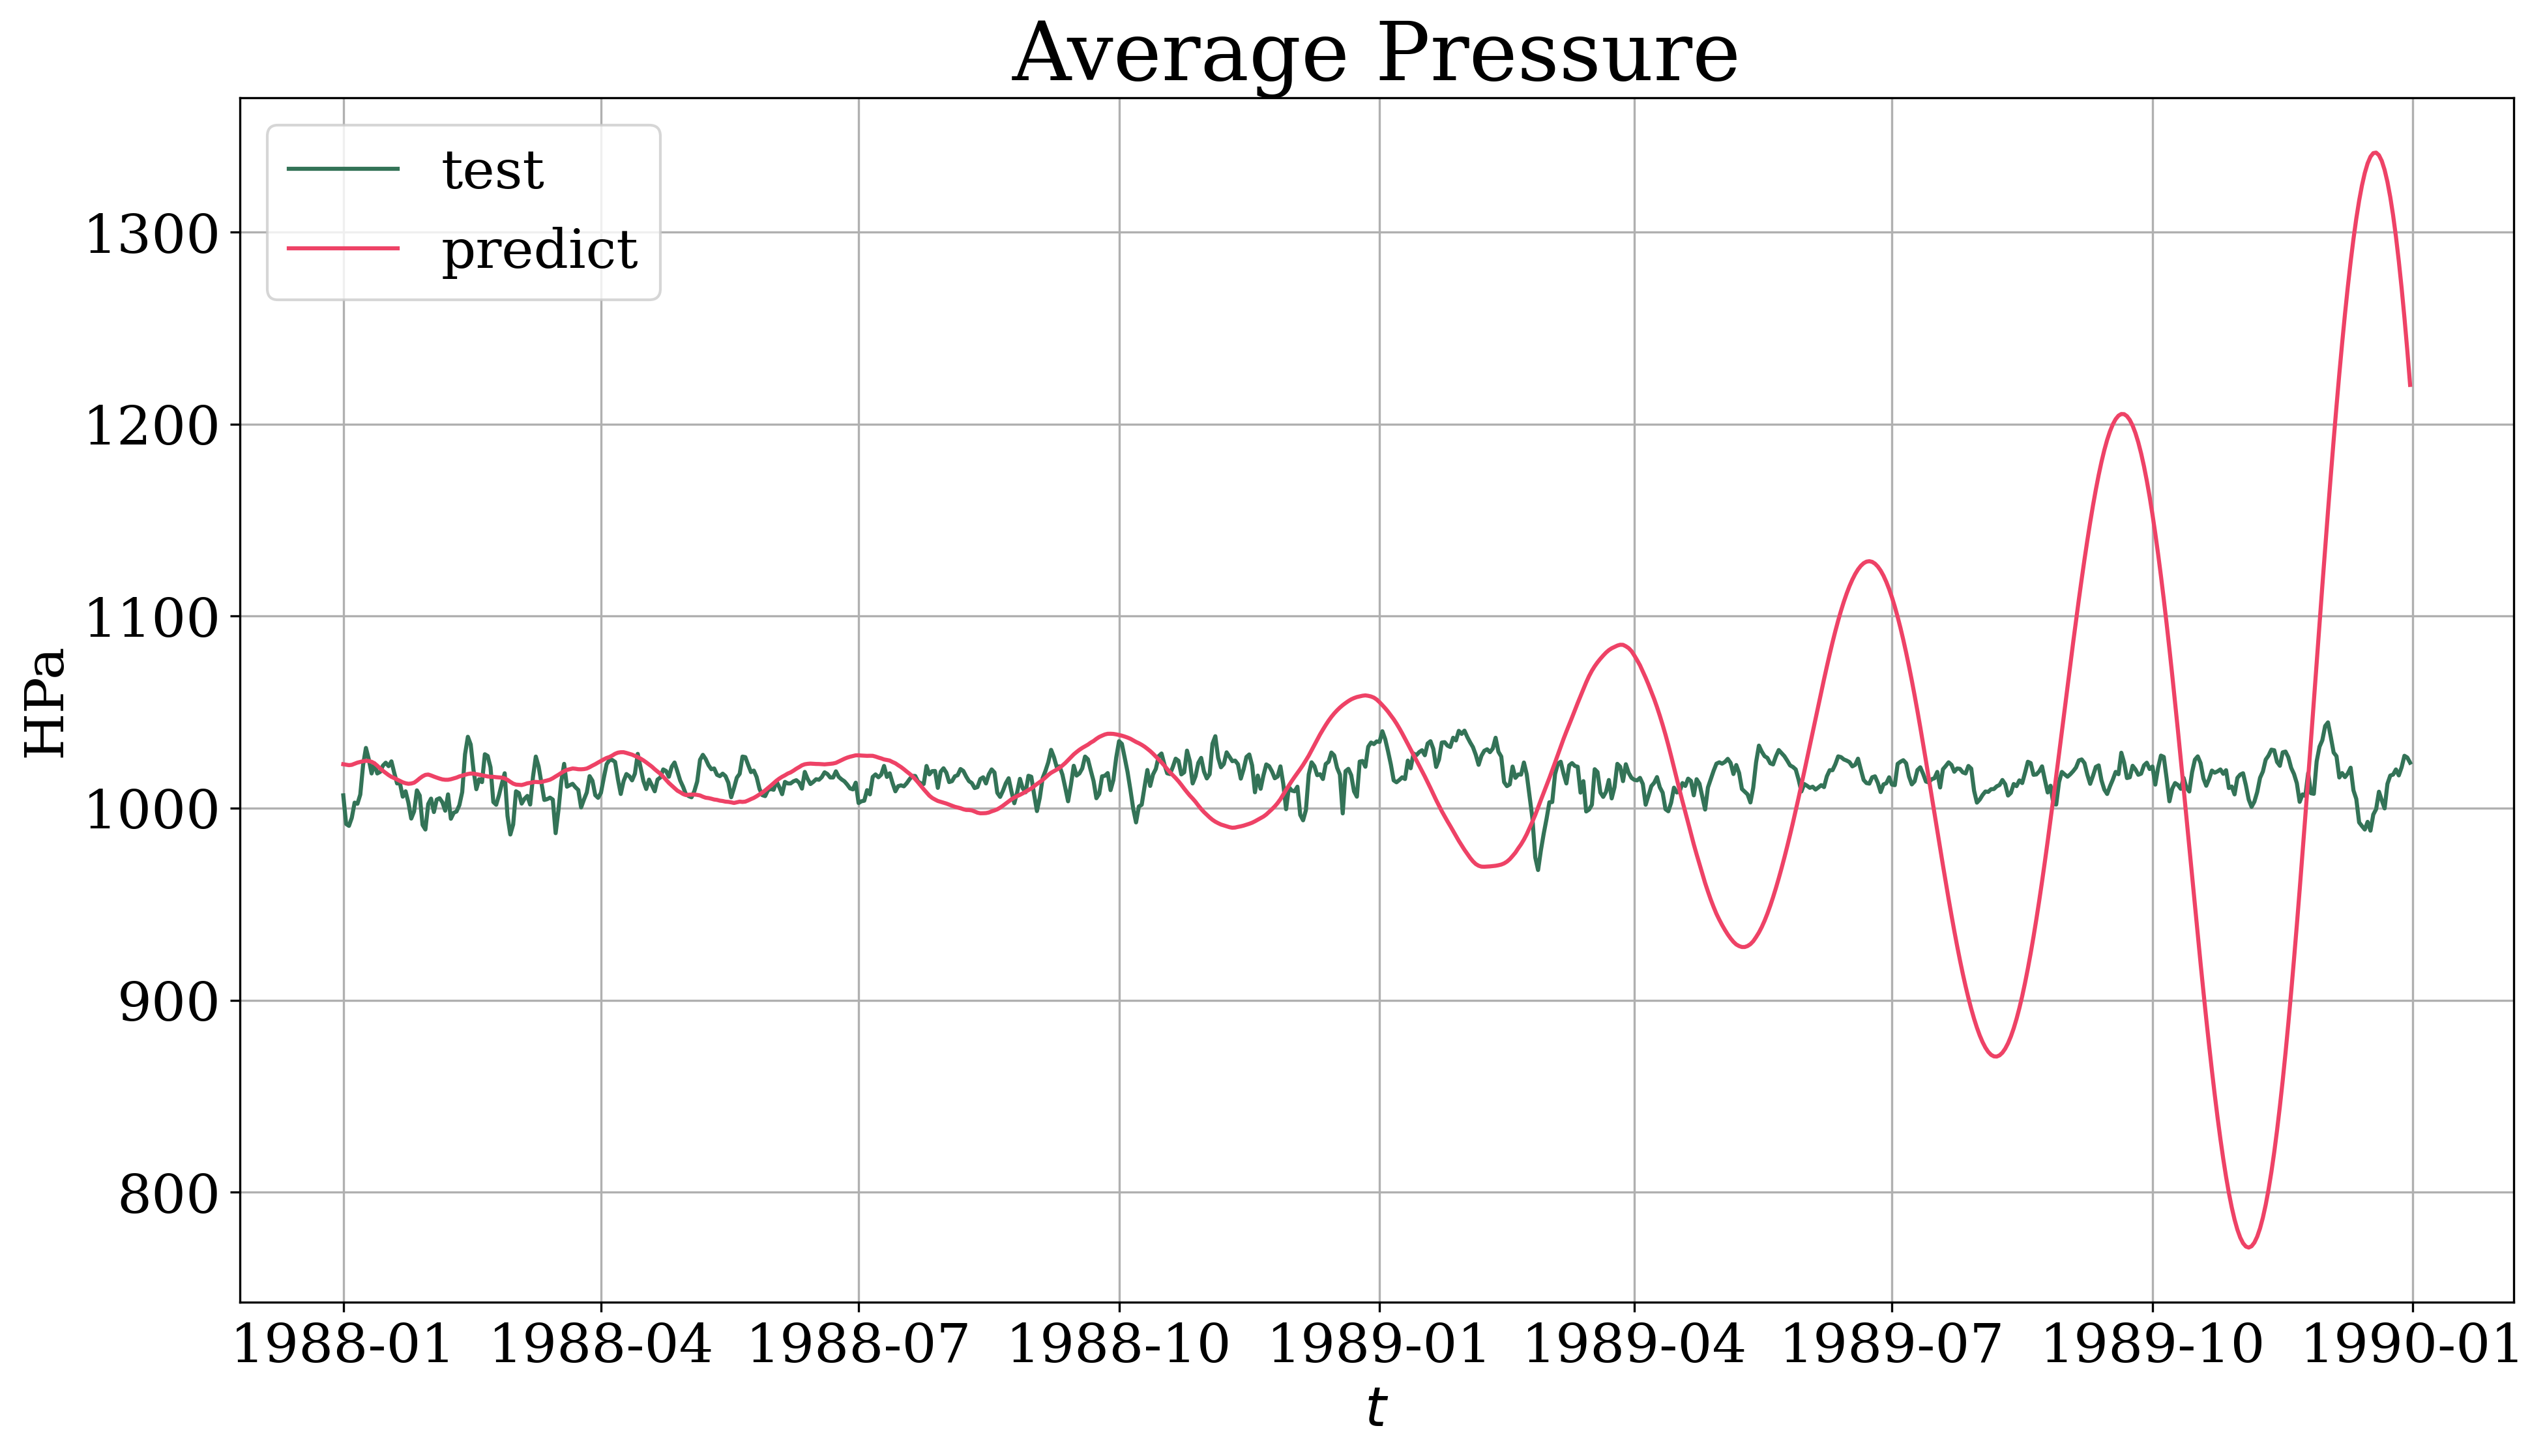

In [55]:
# plot prediction and real values
for i in range(test_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(time_grid_test, test_data.T[i], color=color_list[i], label='test')
        ax.plot(time_grid_test, forecast_tssa.T[i], color=color_list[-1], label='predict')

        ax.grid(True)
        ax.legend();
        ax.set_ylabel(f'{sig_units[i]}', fontsize=20)
        ax.set_xlabel('$t$', fontsize=20)
        ax.set_title(f'{sig_names[i]}', fontsize=30)

        fig.savefig(f'./figs/prediction/cpd_rank_{cp_rank}/{sig_names[i].replace(" ", "_")}.eps',
                             format='eps')